<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

In [3]:
from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
    TransitionTableType,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
import numpy as np
from functools import partial
import yaml
import matplotlib.pyplot as plt

In [267]:
path_from_state_folder = "FED/S312/fed_s312_prison_model_inputs.yaml"
display_compartments = ["prison"]
test_sim = SuperSimulationFactory.build_super_simulation(
    "../state/" + path_from_state_folder
)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 279.65rows/s]
/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


outflows_data returned 60 results


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 1352.63rows/s]


transitions_data returned 334 results


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 324.60rows/s]


total_population_data returned 60 results


In [268]:
policy_transitions = pd.read_csv("../state/FED/S312/policy_transitions.csv")
policy_transitions.head()

compartment   outflow_to  total_population  compartment_duration age
0      prison  home_detent         54.228571                   1.0   x
1      prison  home_detent        104.980952                   2.0   x
2      prison  home_detent        253.761905                   3.0   x
3      prison  home_detent        200.923810                   4.0   x
4      prison  home_detent        452.600000                   5.0   x

# Policy Simulation

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.8/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


initialization time:  13.440834045410156
initialization time:  6.202780723571777
simulation_time:  5.0561370849609375
simulation_time:  4.950774192810059
18838.234207424004


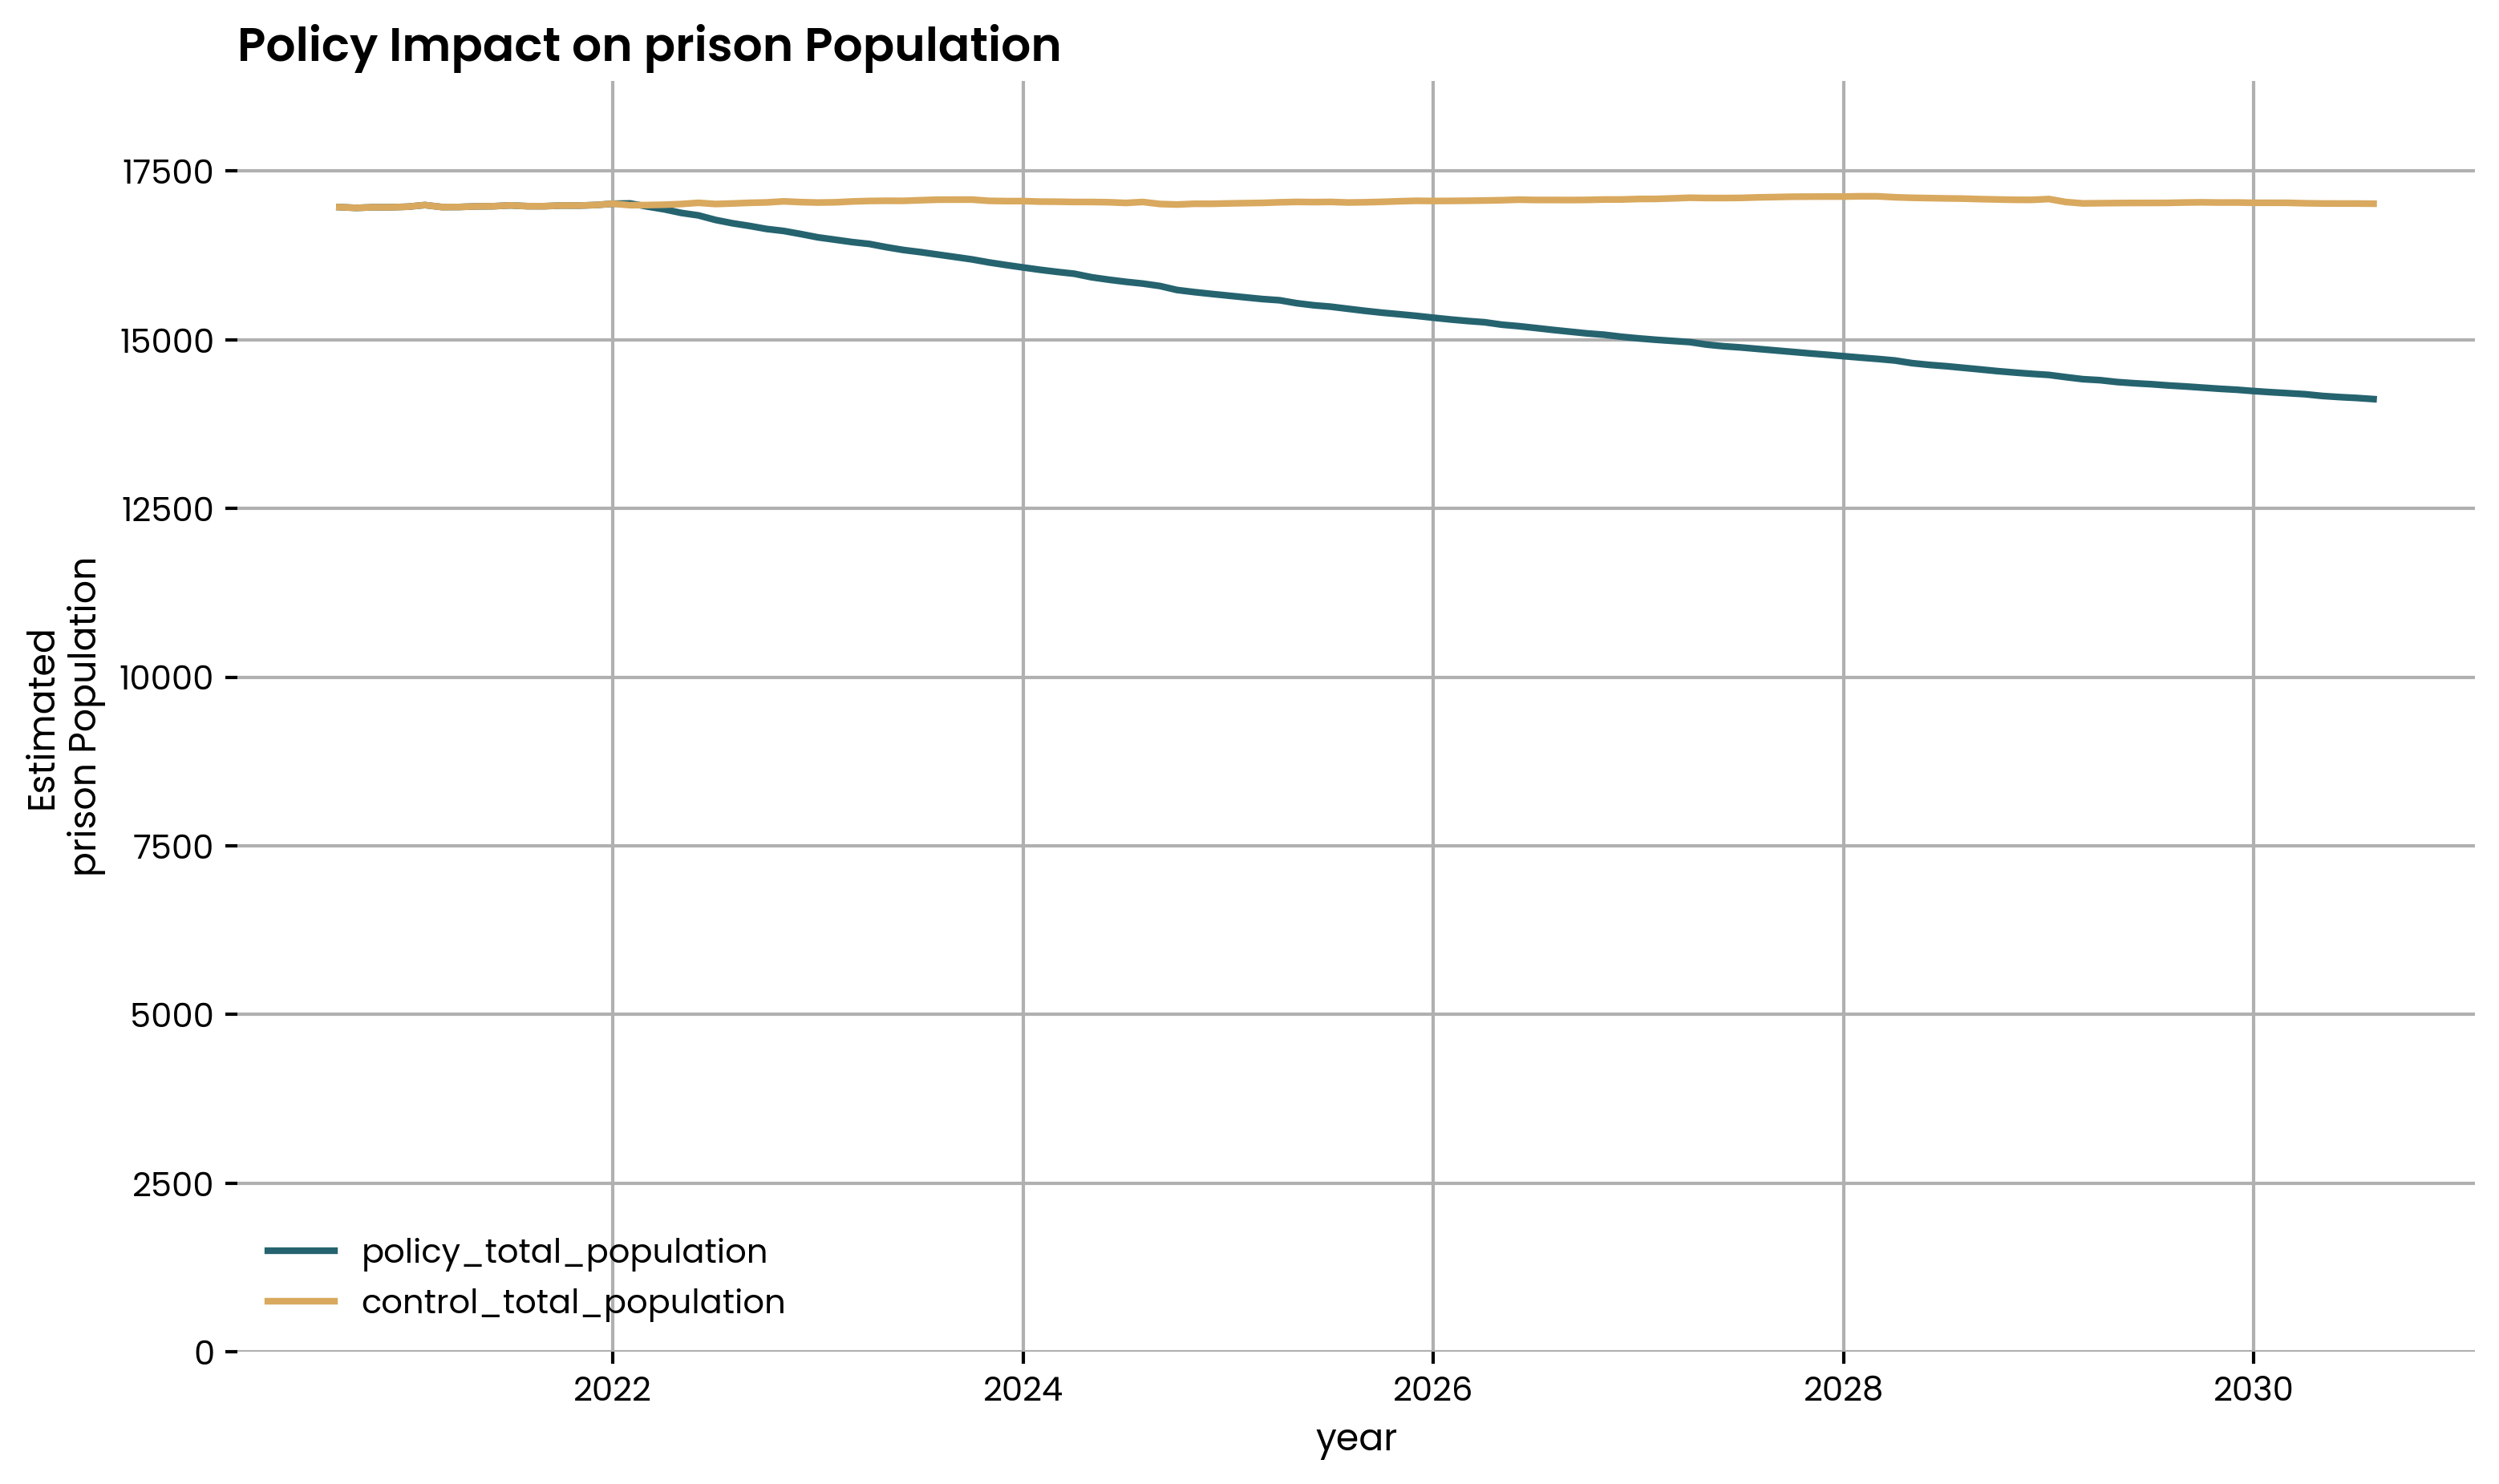

In [269]:
def apply_home_detention(compartment):
    alternate_historical_transitions = policy_transitions[
        policy_transitions["compartment"] == compartment
    ]
    retroactive = True if compartment == "prison" else False
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alternate_historical_transitions,
        retroactive=retroactive,
    )


policy_list = [
    SparkPolicy(
        policy_fn=apply_home_detention("prison"),
        spark_compartment="prison",
        sub_population={"age": "x"},
        policy_ts=17,
        apply_retroactive=True,
    ),
    SparkPolicy(
        policy_fn=apply_home_detention("home_detent"),
        spark_compartment="home_detent",
        sub_population={"age": "x"},
        policy_ts=17,
        apply_retroactive=False,
    ),
]

test_results = test_sim.simulate_policy(policy_list, "prison")

<AxesSubplot:xlabel='year'>

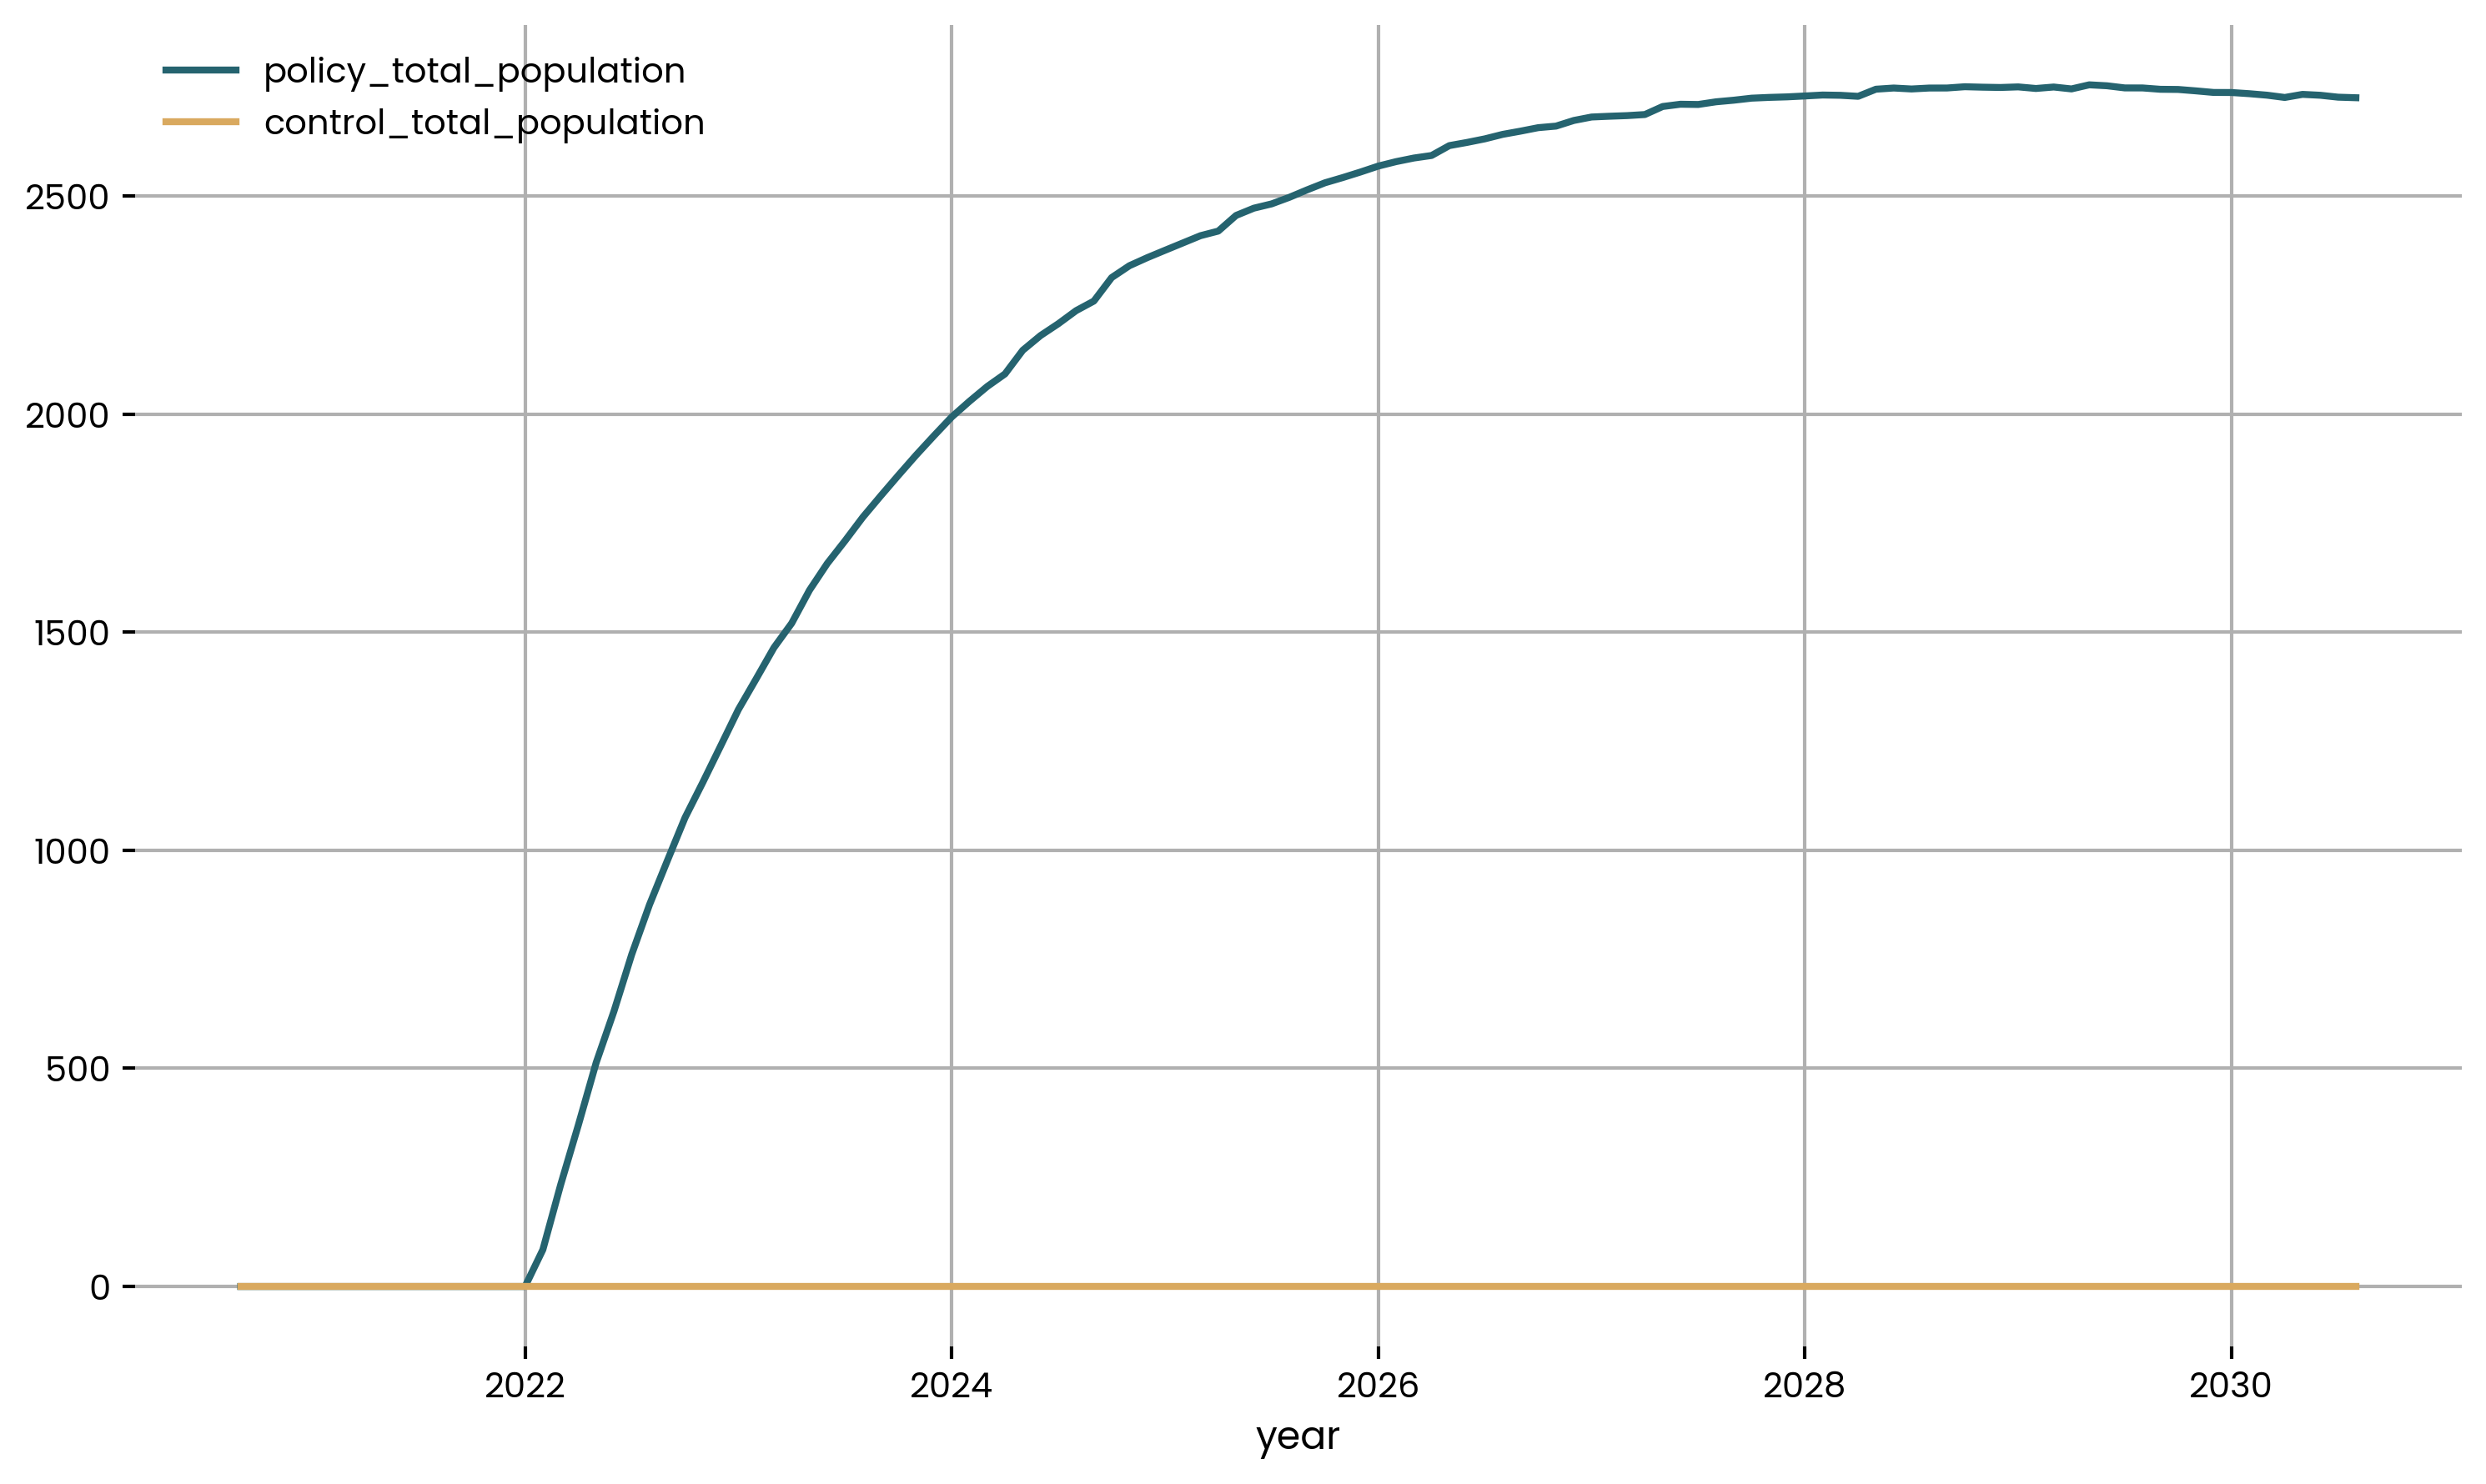

In [270]:
test_results[test_results["compartment"] == "home_detent"].plot(
    y=["policy_total_population", "control_total_population"]
)

In [271]:
simulation_tag = "fed_s213"
results_dict = test_sim.upload_policy_simulation_results_to_bq(simulation_tag)

1it [00:02,  2.83s/it]
1it [00:09,  9.76s/it]
1it [00:05,  5.02s/it]
1it [00:02,  2.87s/it]


In [9]:
def convert_time_step(df):
    if "time_step" in df.index.names:
        df = df.reset_index("time_step", drop=False)
    df["time_step"] = round(
        test_sim.initializer.time_converter.convert_time_steps_to_year(df["time_step"]),
        5,
    )
    df["month"] = (12 * (df["time_step"] % 1)).round(0).astype(int) + 1
    df["year"] = df["time_step"].astype(int)
    df["day"] = 1
    df["time_step"] = pd.to_datetime(df[["year", "month", "day"]])
    df = df.drop(["year", "month", "day"], axis=1)
    return df

In [12]:
simulation_outflows = test_sim.simulator.pop_simulations["control"].get_outflows()
simulation_outflows = simulation_outflows[
    simulation_outflows.index.get_level_values("outflow_to")
    != simulation_outflows["compartment"]
].copy()
simulation_outflows = convert_time_step(simulation_outflows)
simulation_outflows.head()

time_step  total_population compartment simulation_group
outflow_to                                                          
prison     2010-09-01             235.0    pretrial                x
prison     2010-10-01             235.0    pretrial                x
prison     2010-11-01             235.0    pretrial                x
prison     2010-12-01             235.0    pretrial                x
prison     2011-01-01             235.0    pretrial                x

[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

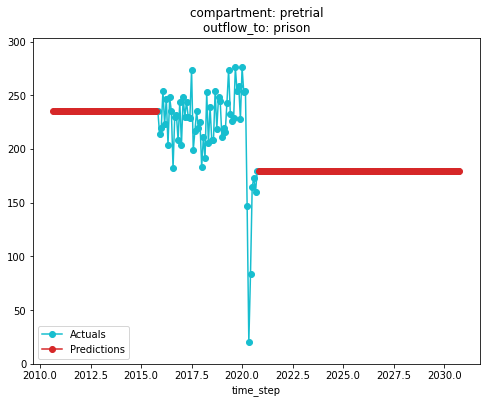

In [203]:
test_sim.get_arima_output_plots("control")

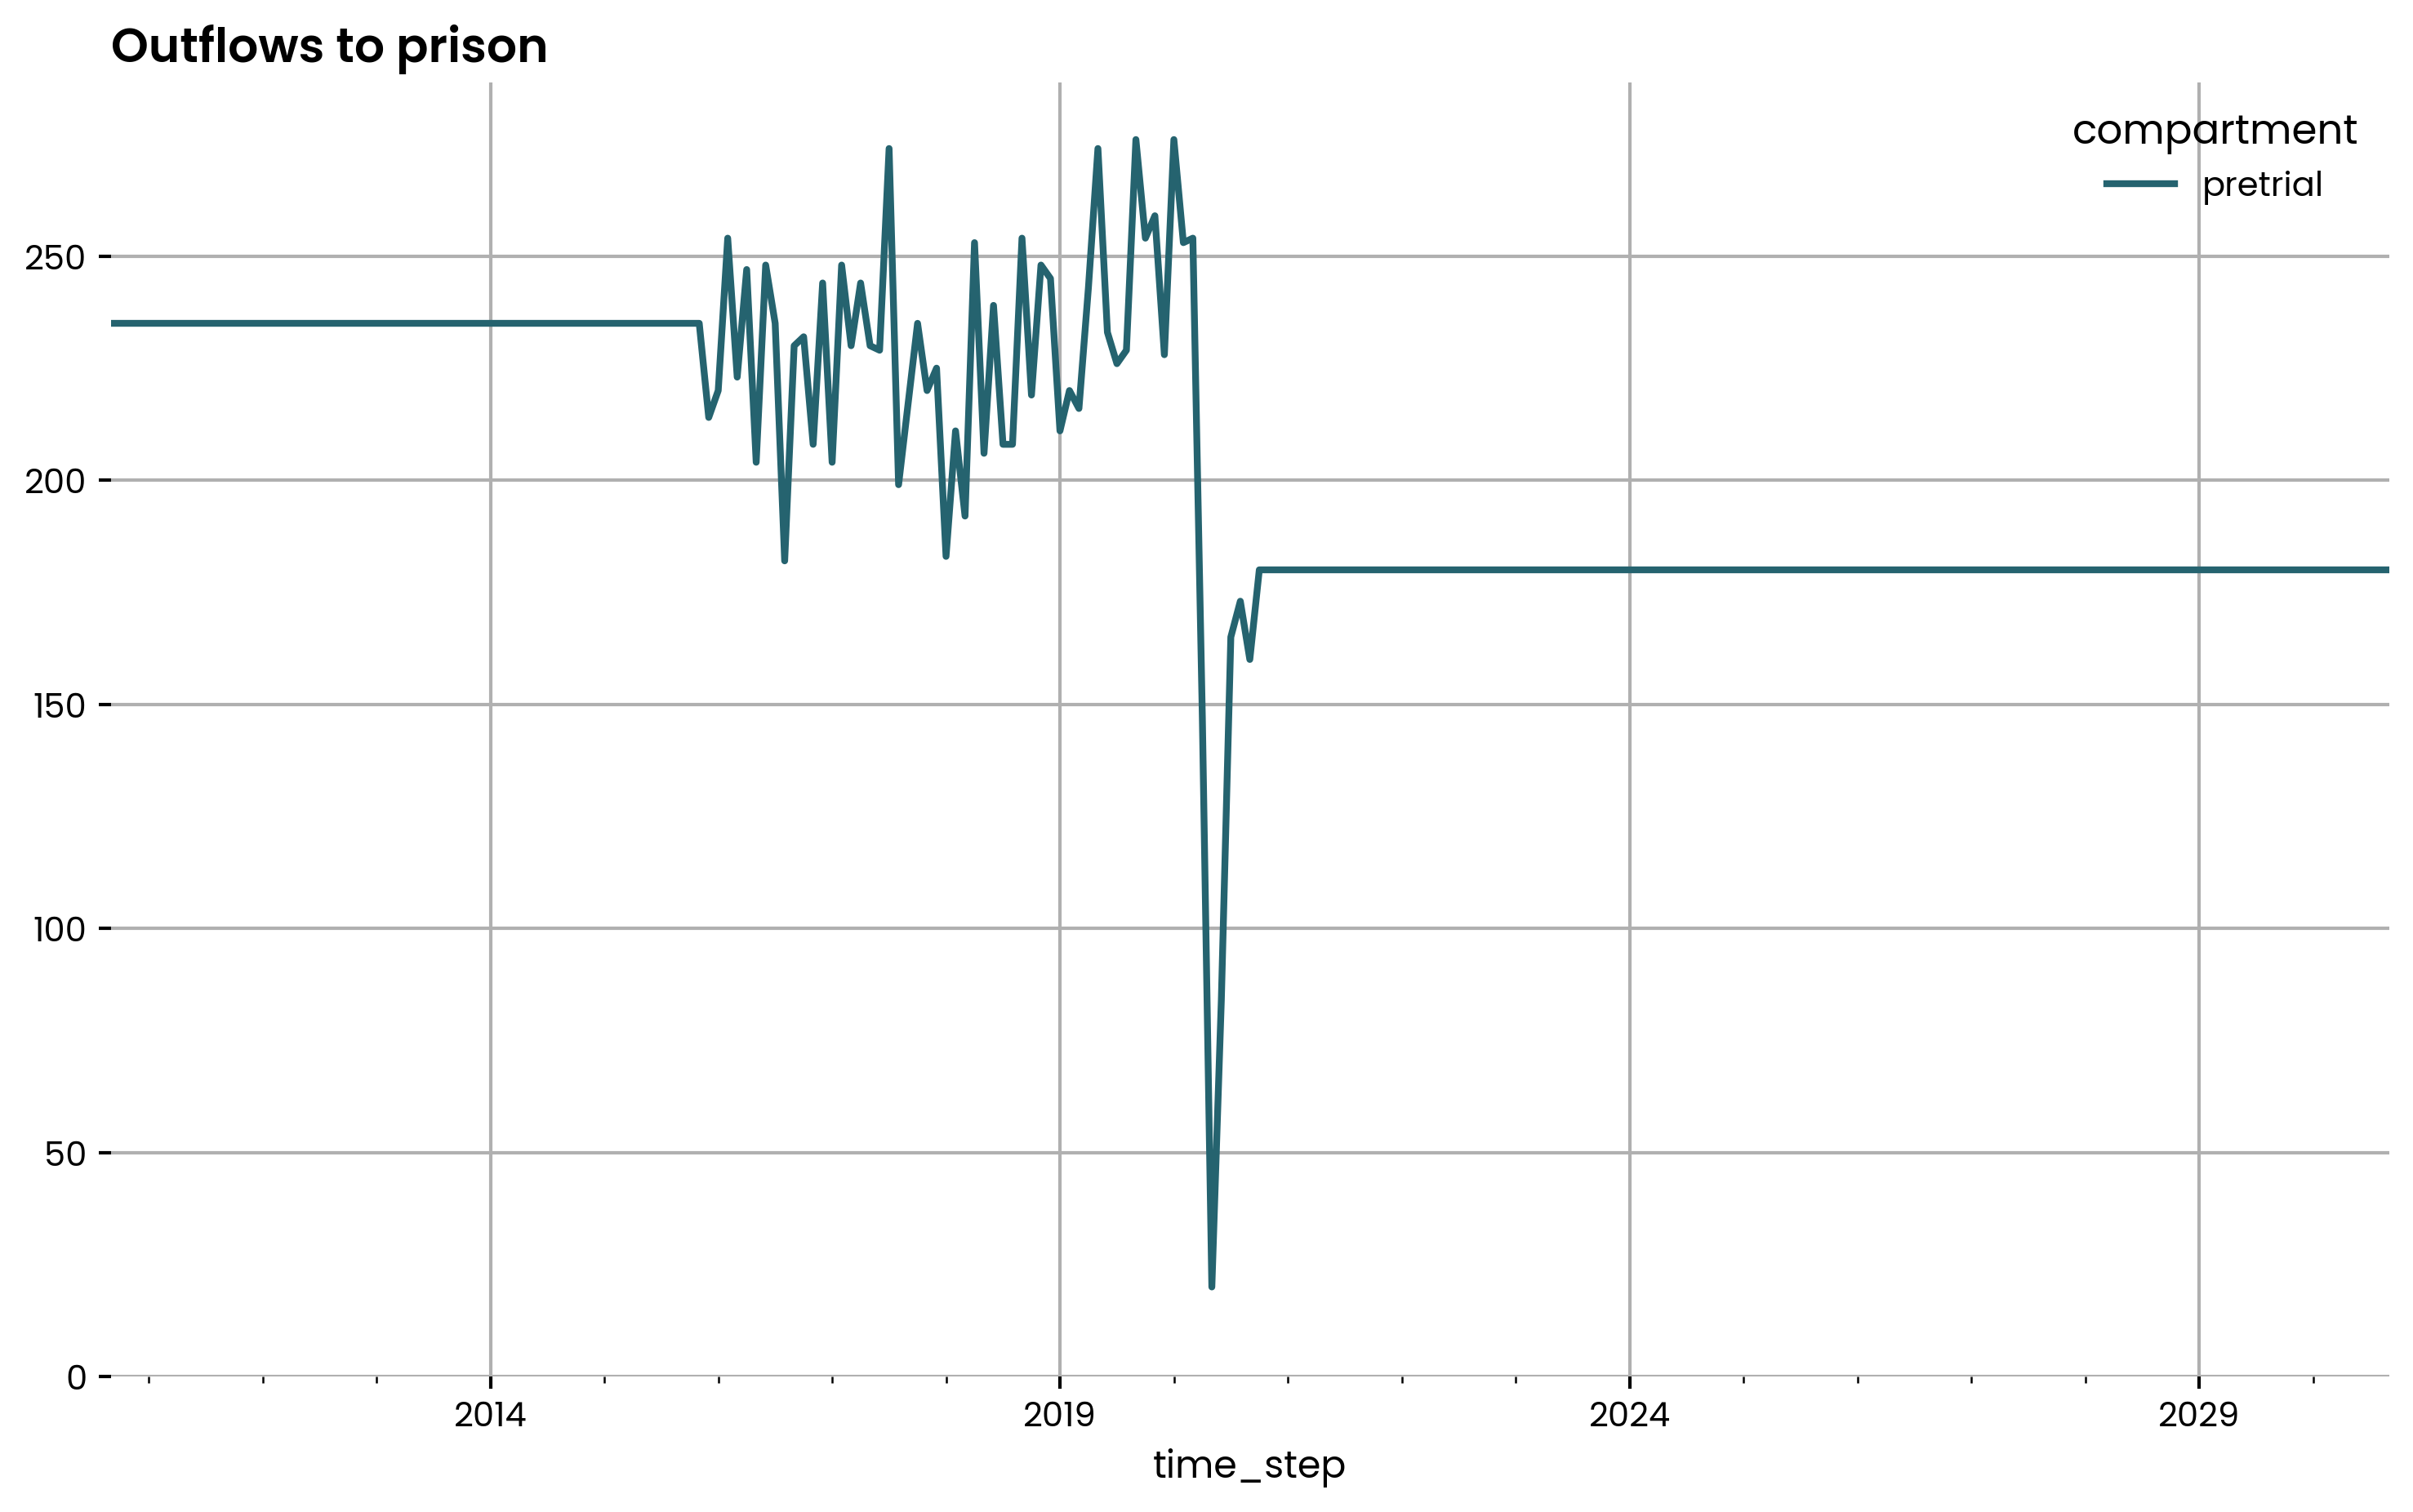

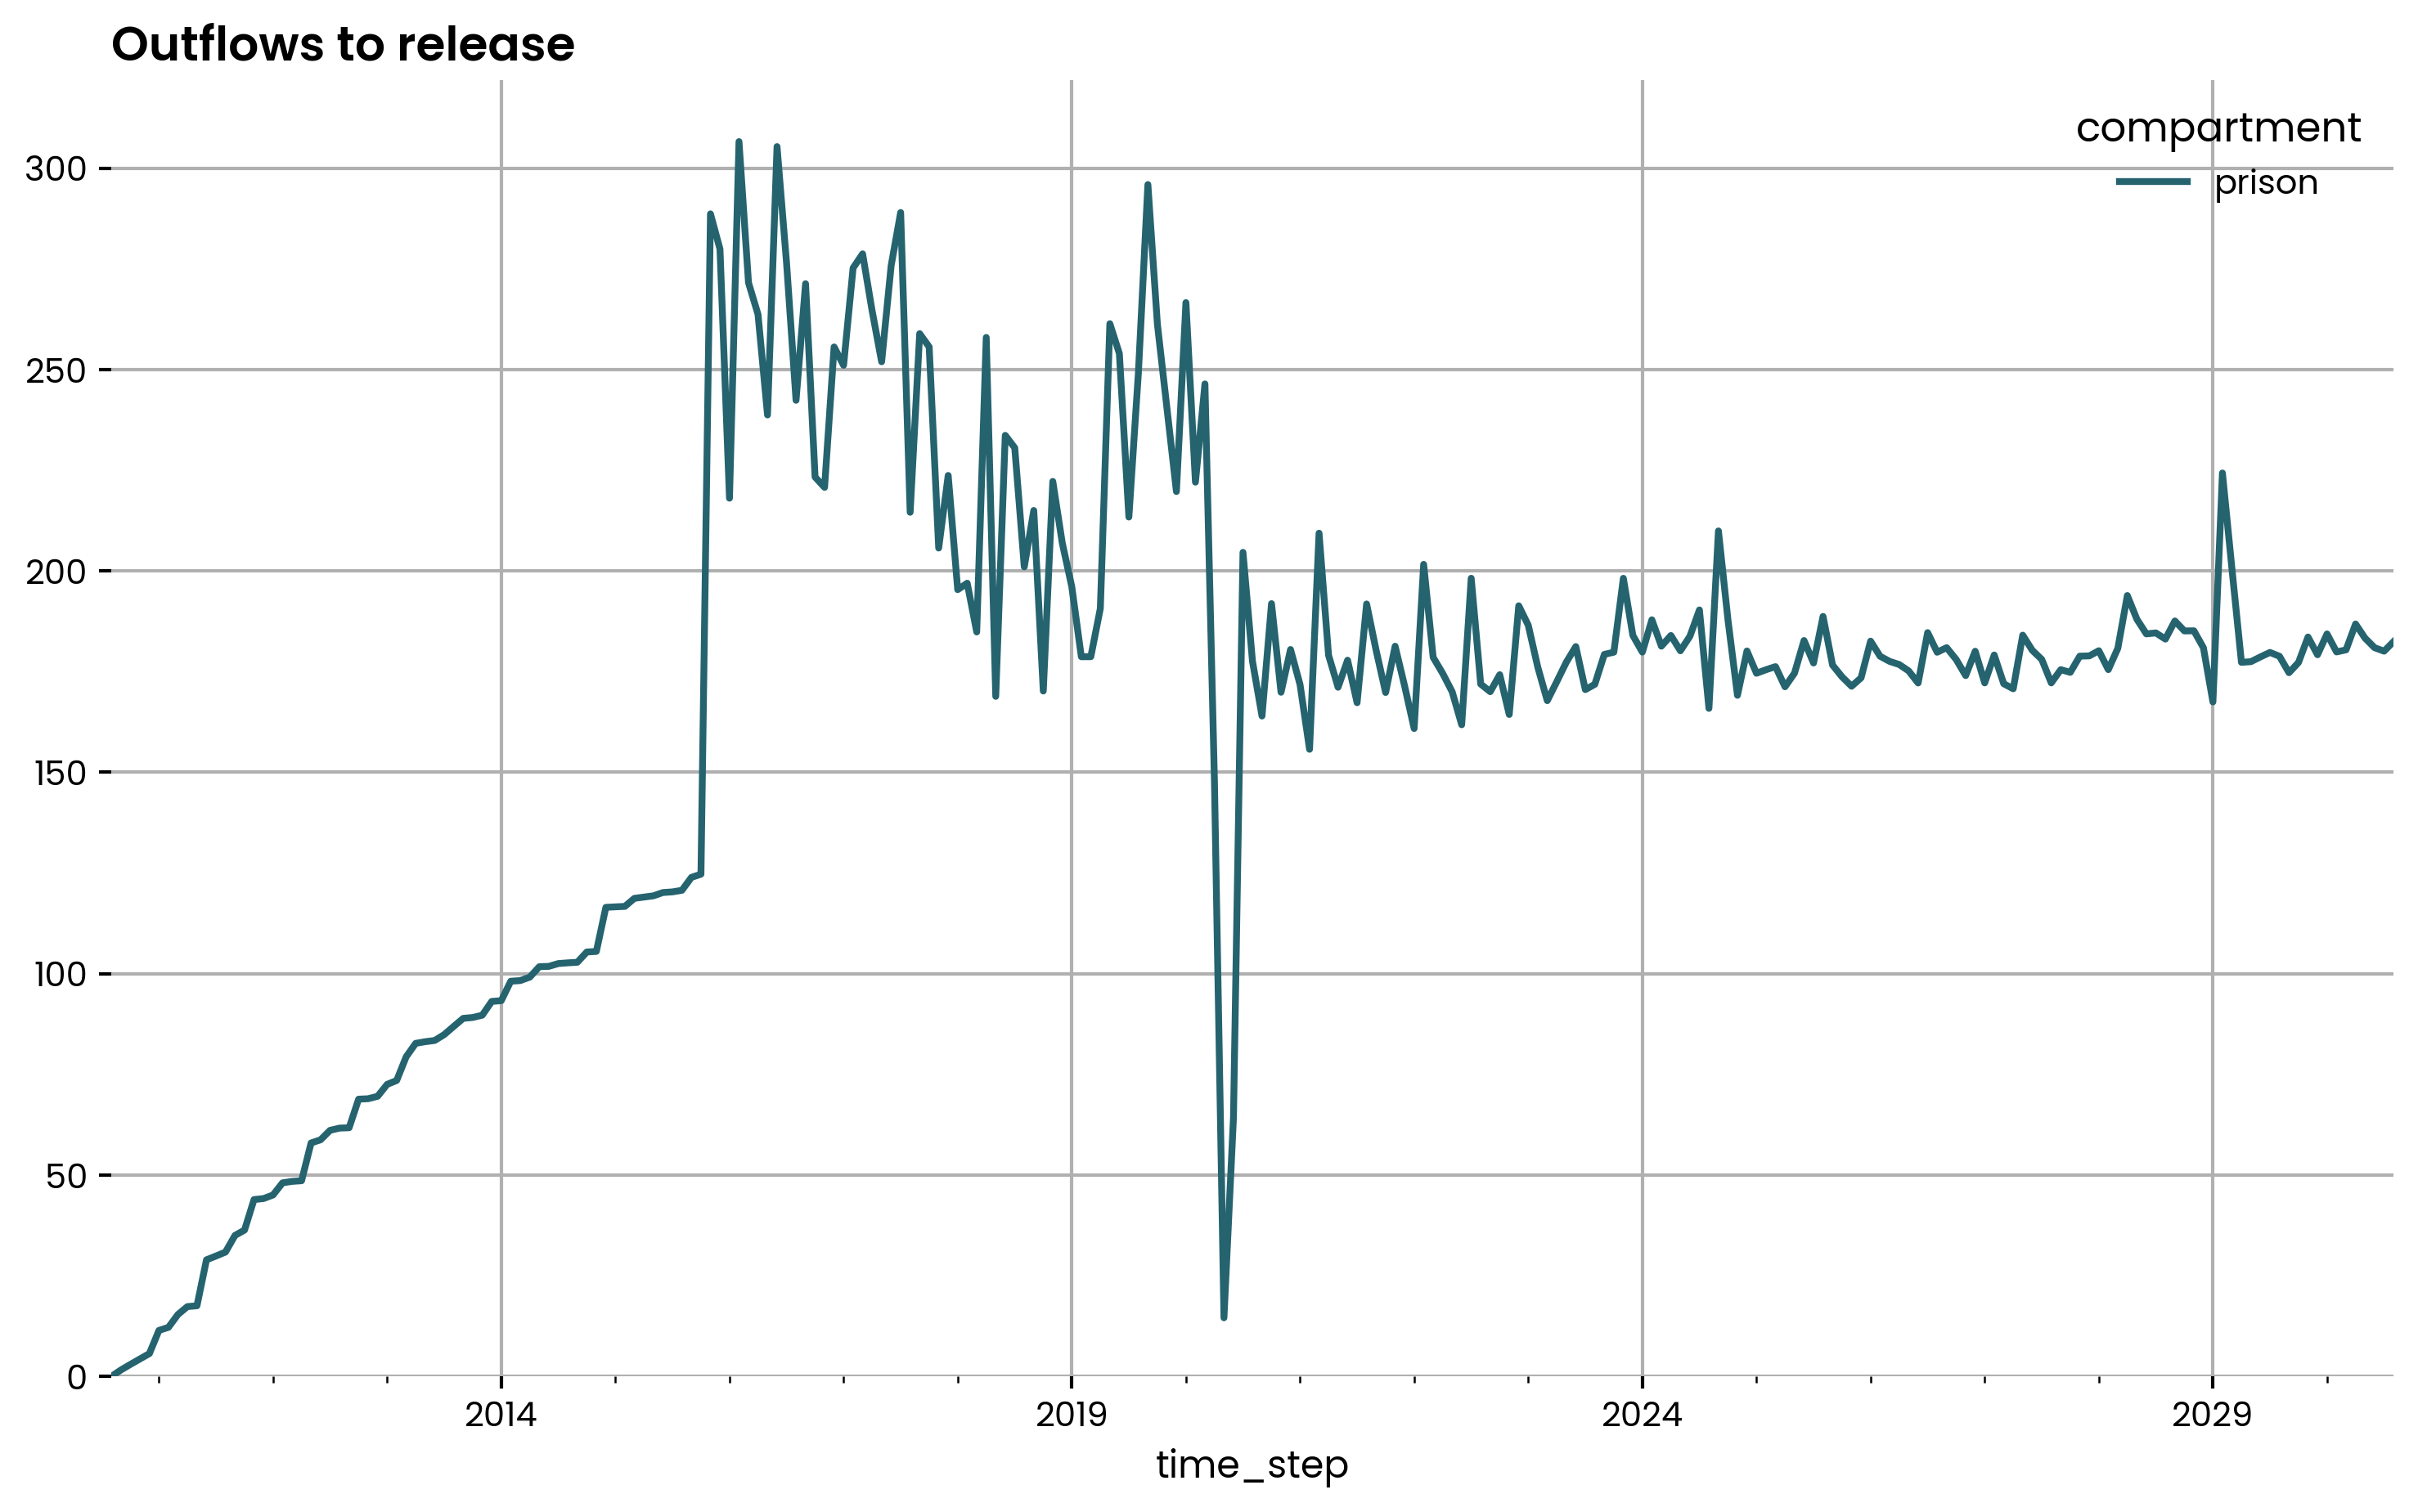

In [14]:
# Output without the arima (constant_admissions=True)
for outflow_to in simulation_outflows.index.unique():
    simulation_outflows.loc[outflow_to].groupby(["time_step", "compartment"]).sum()[
        "total_population"
    ].unstack("compartment").plot()
    plt.title(f"Outflows to {outflow_to}")
    plt.ylim([0, None])

(0.0, 28870.75)

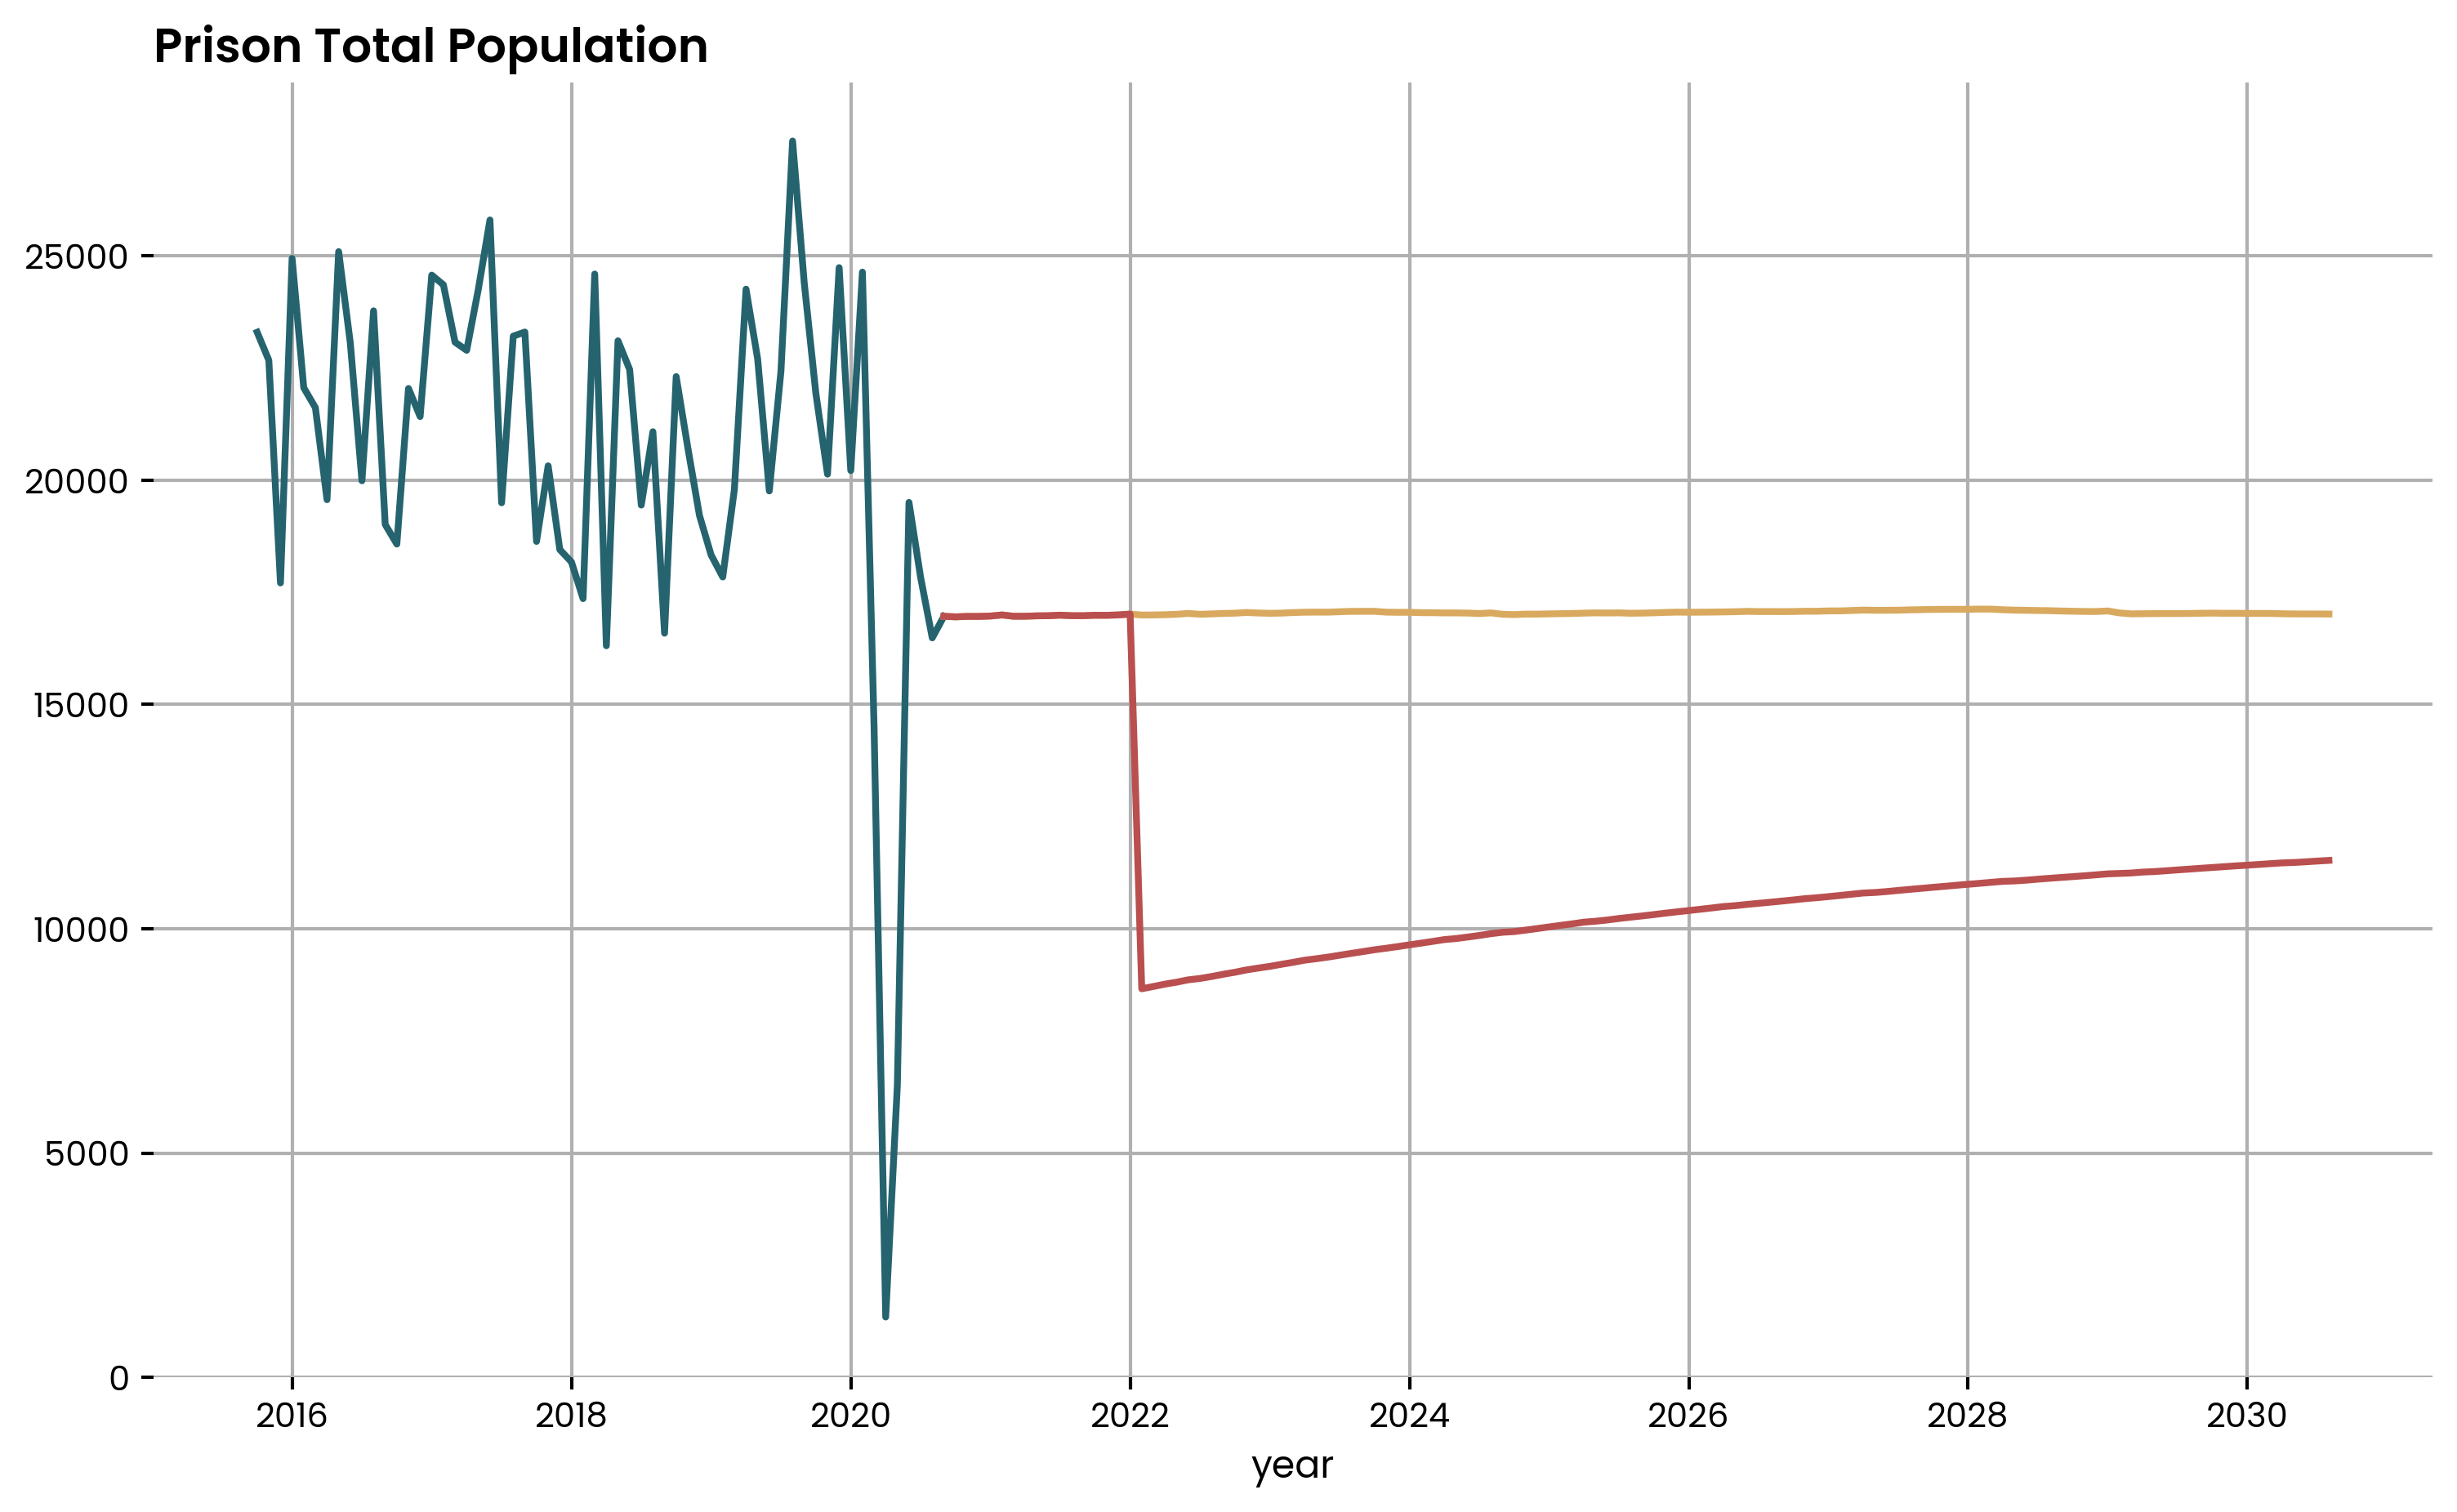

In [222]:
compartment = "prison"
total_prison_pop = test_sim.initializer.data_dict["total_population_data"].copy()
total_prison_pop = total_prison_pop[total_prison_pop["compartment"] == "prison"]
total_prison_pop[
    "year"
] = test_sim.initializer.time_converter.convert_time_steps_to_year(
    total_prison_pop["time_step"]
)

ax = total_prison_pop.groupby("year").sum()["total_population"].plot(label="historical")
test_results[test_results["compartment"] == compartment].plot(
    x="year", y=["control_total_population", "policy_total_population"], ax=ax
)
plt.title(f"{compartment.title()} Total Population")
plt.legend().remove()
plt.ylim([0, None])

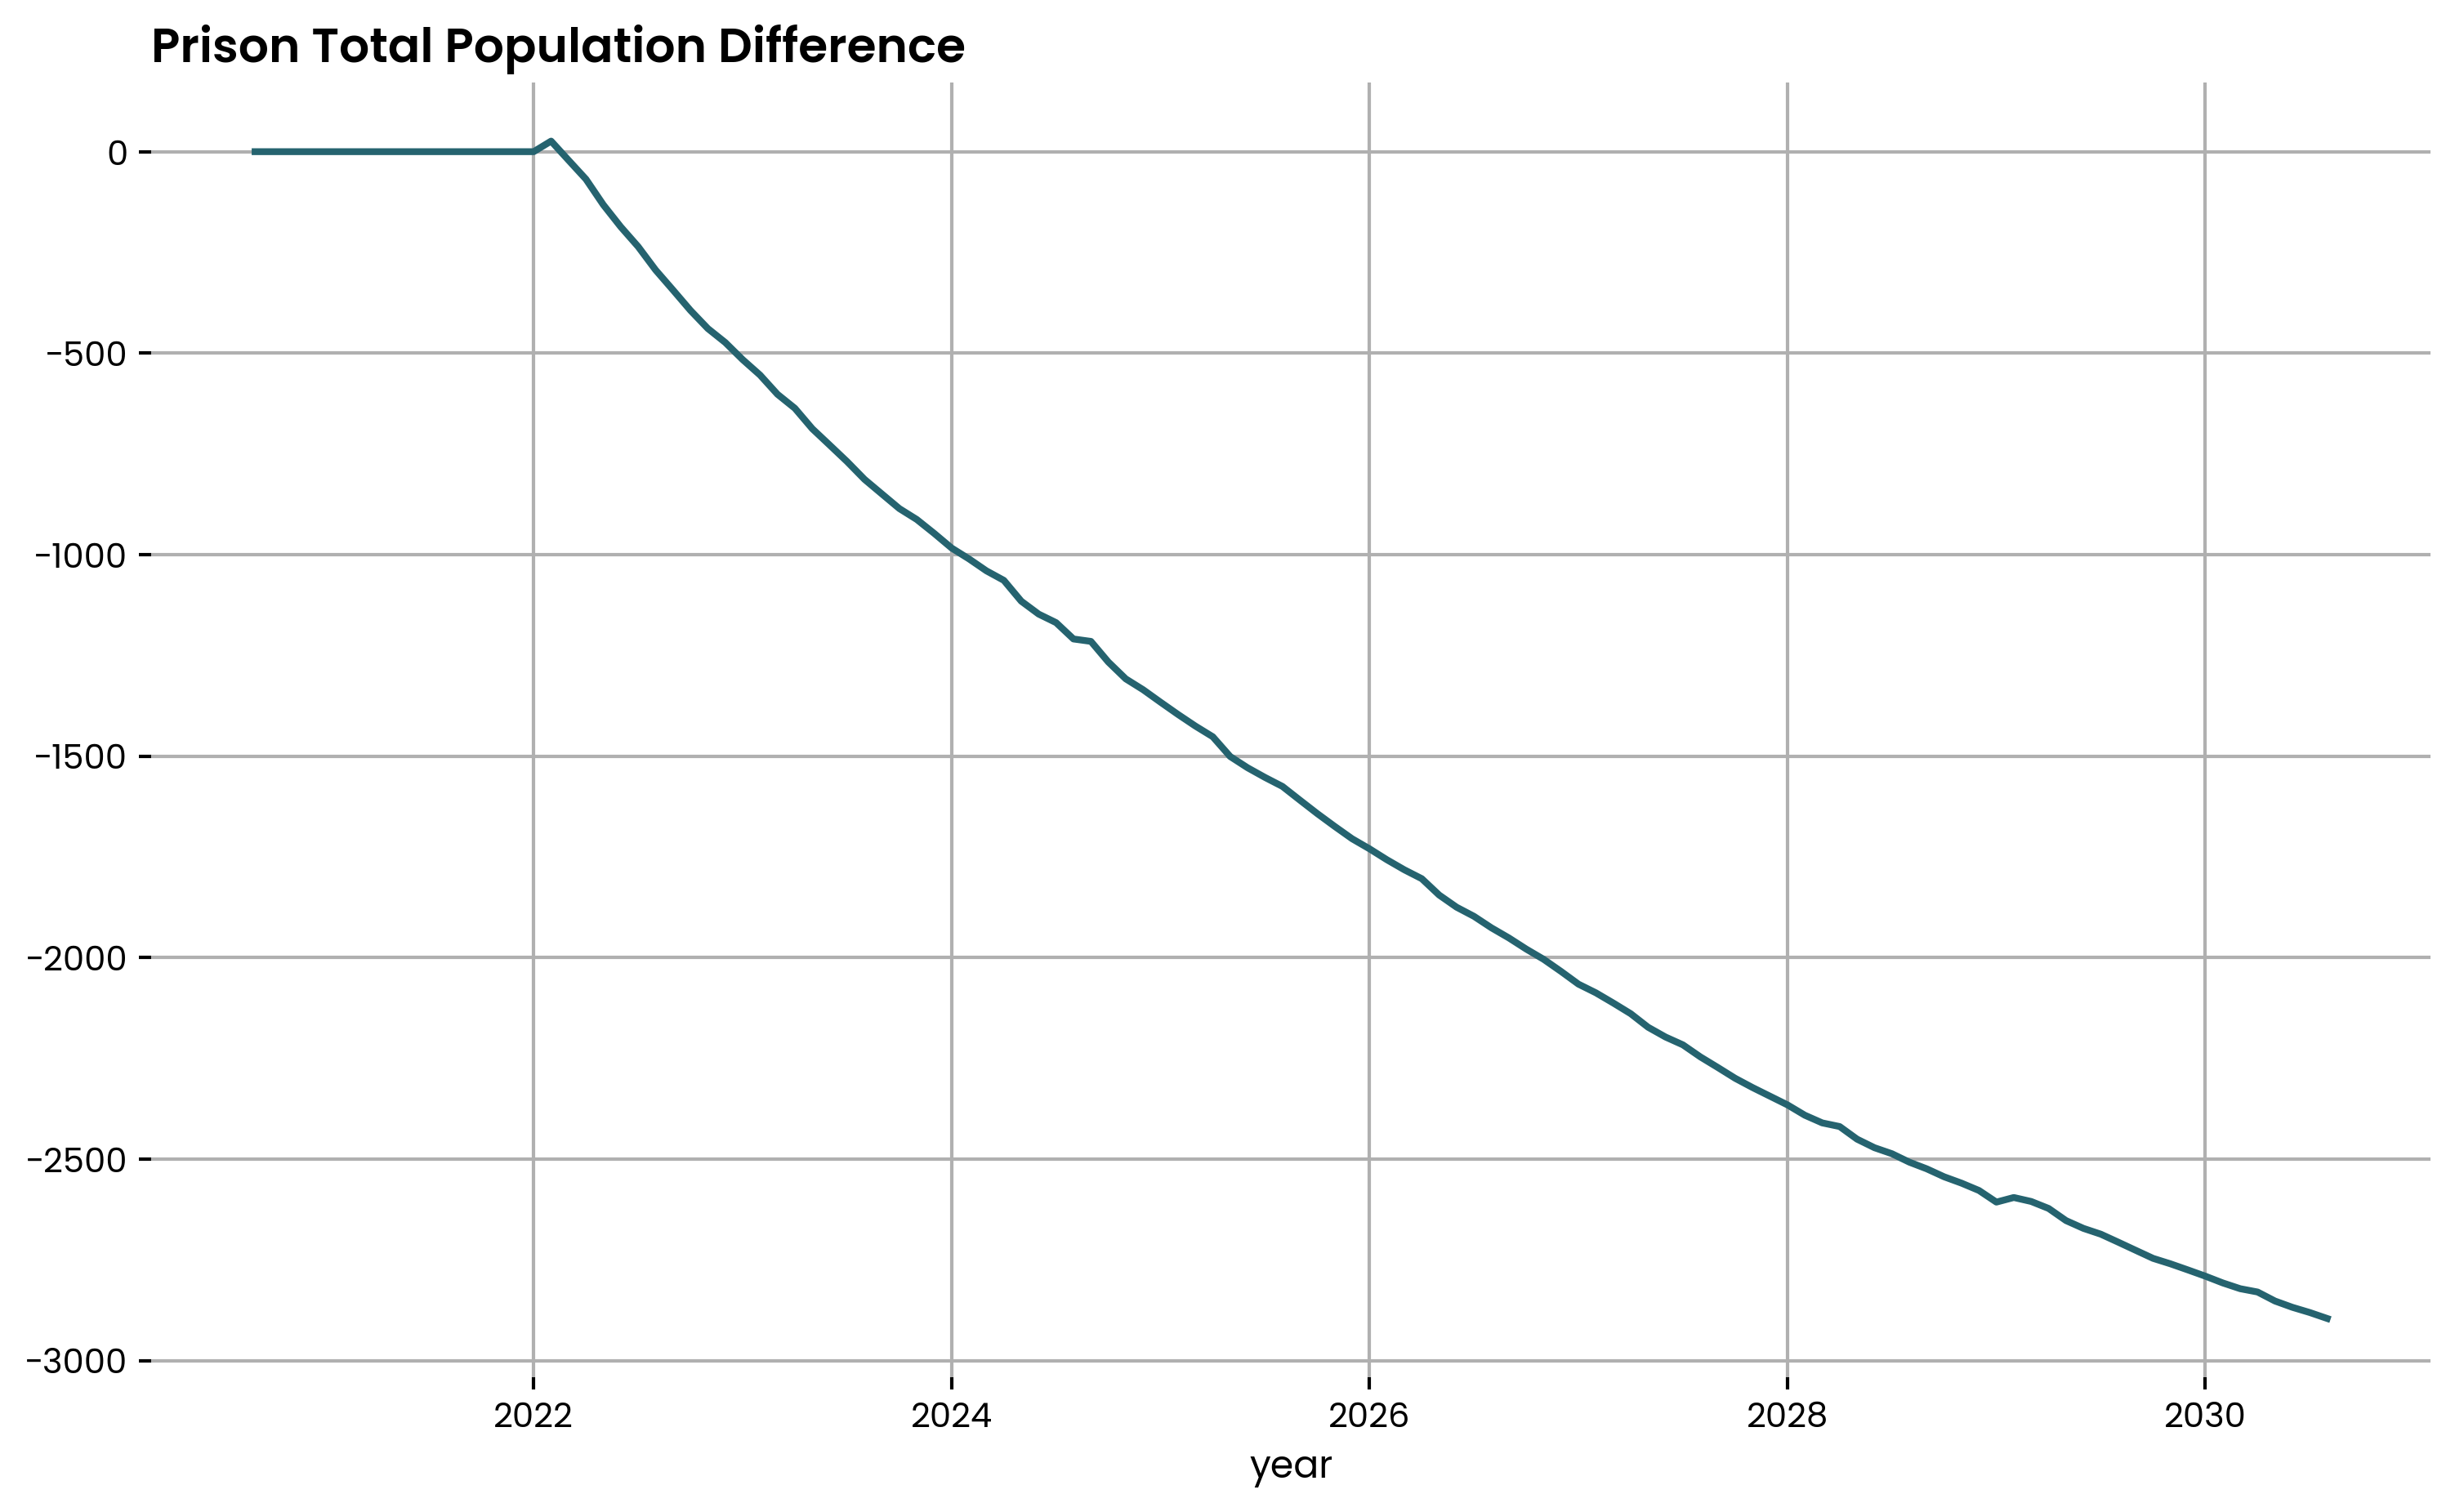

In [231]:
test_results["population_difference"] = (
    test_results["policy_total_population"] - test_results["control_total_population"]
)
test_results[test_results["compartment"] == "prison"].plot(
    x="year", y="population_difference"
)
plt.title(f"{compartment.title()} Total Population Difference")
plt.legend().remove()

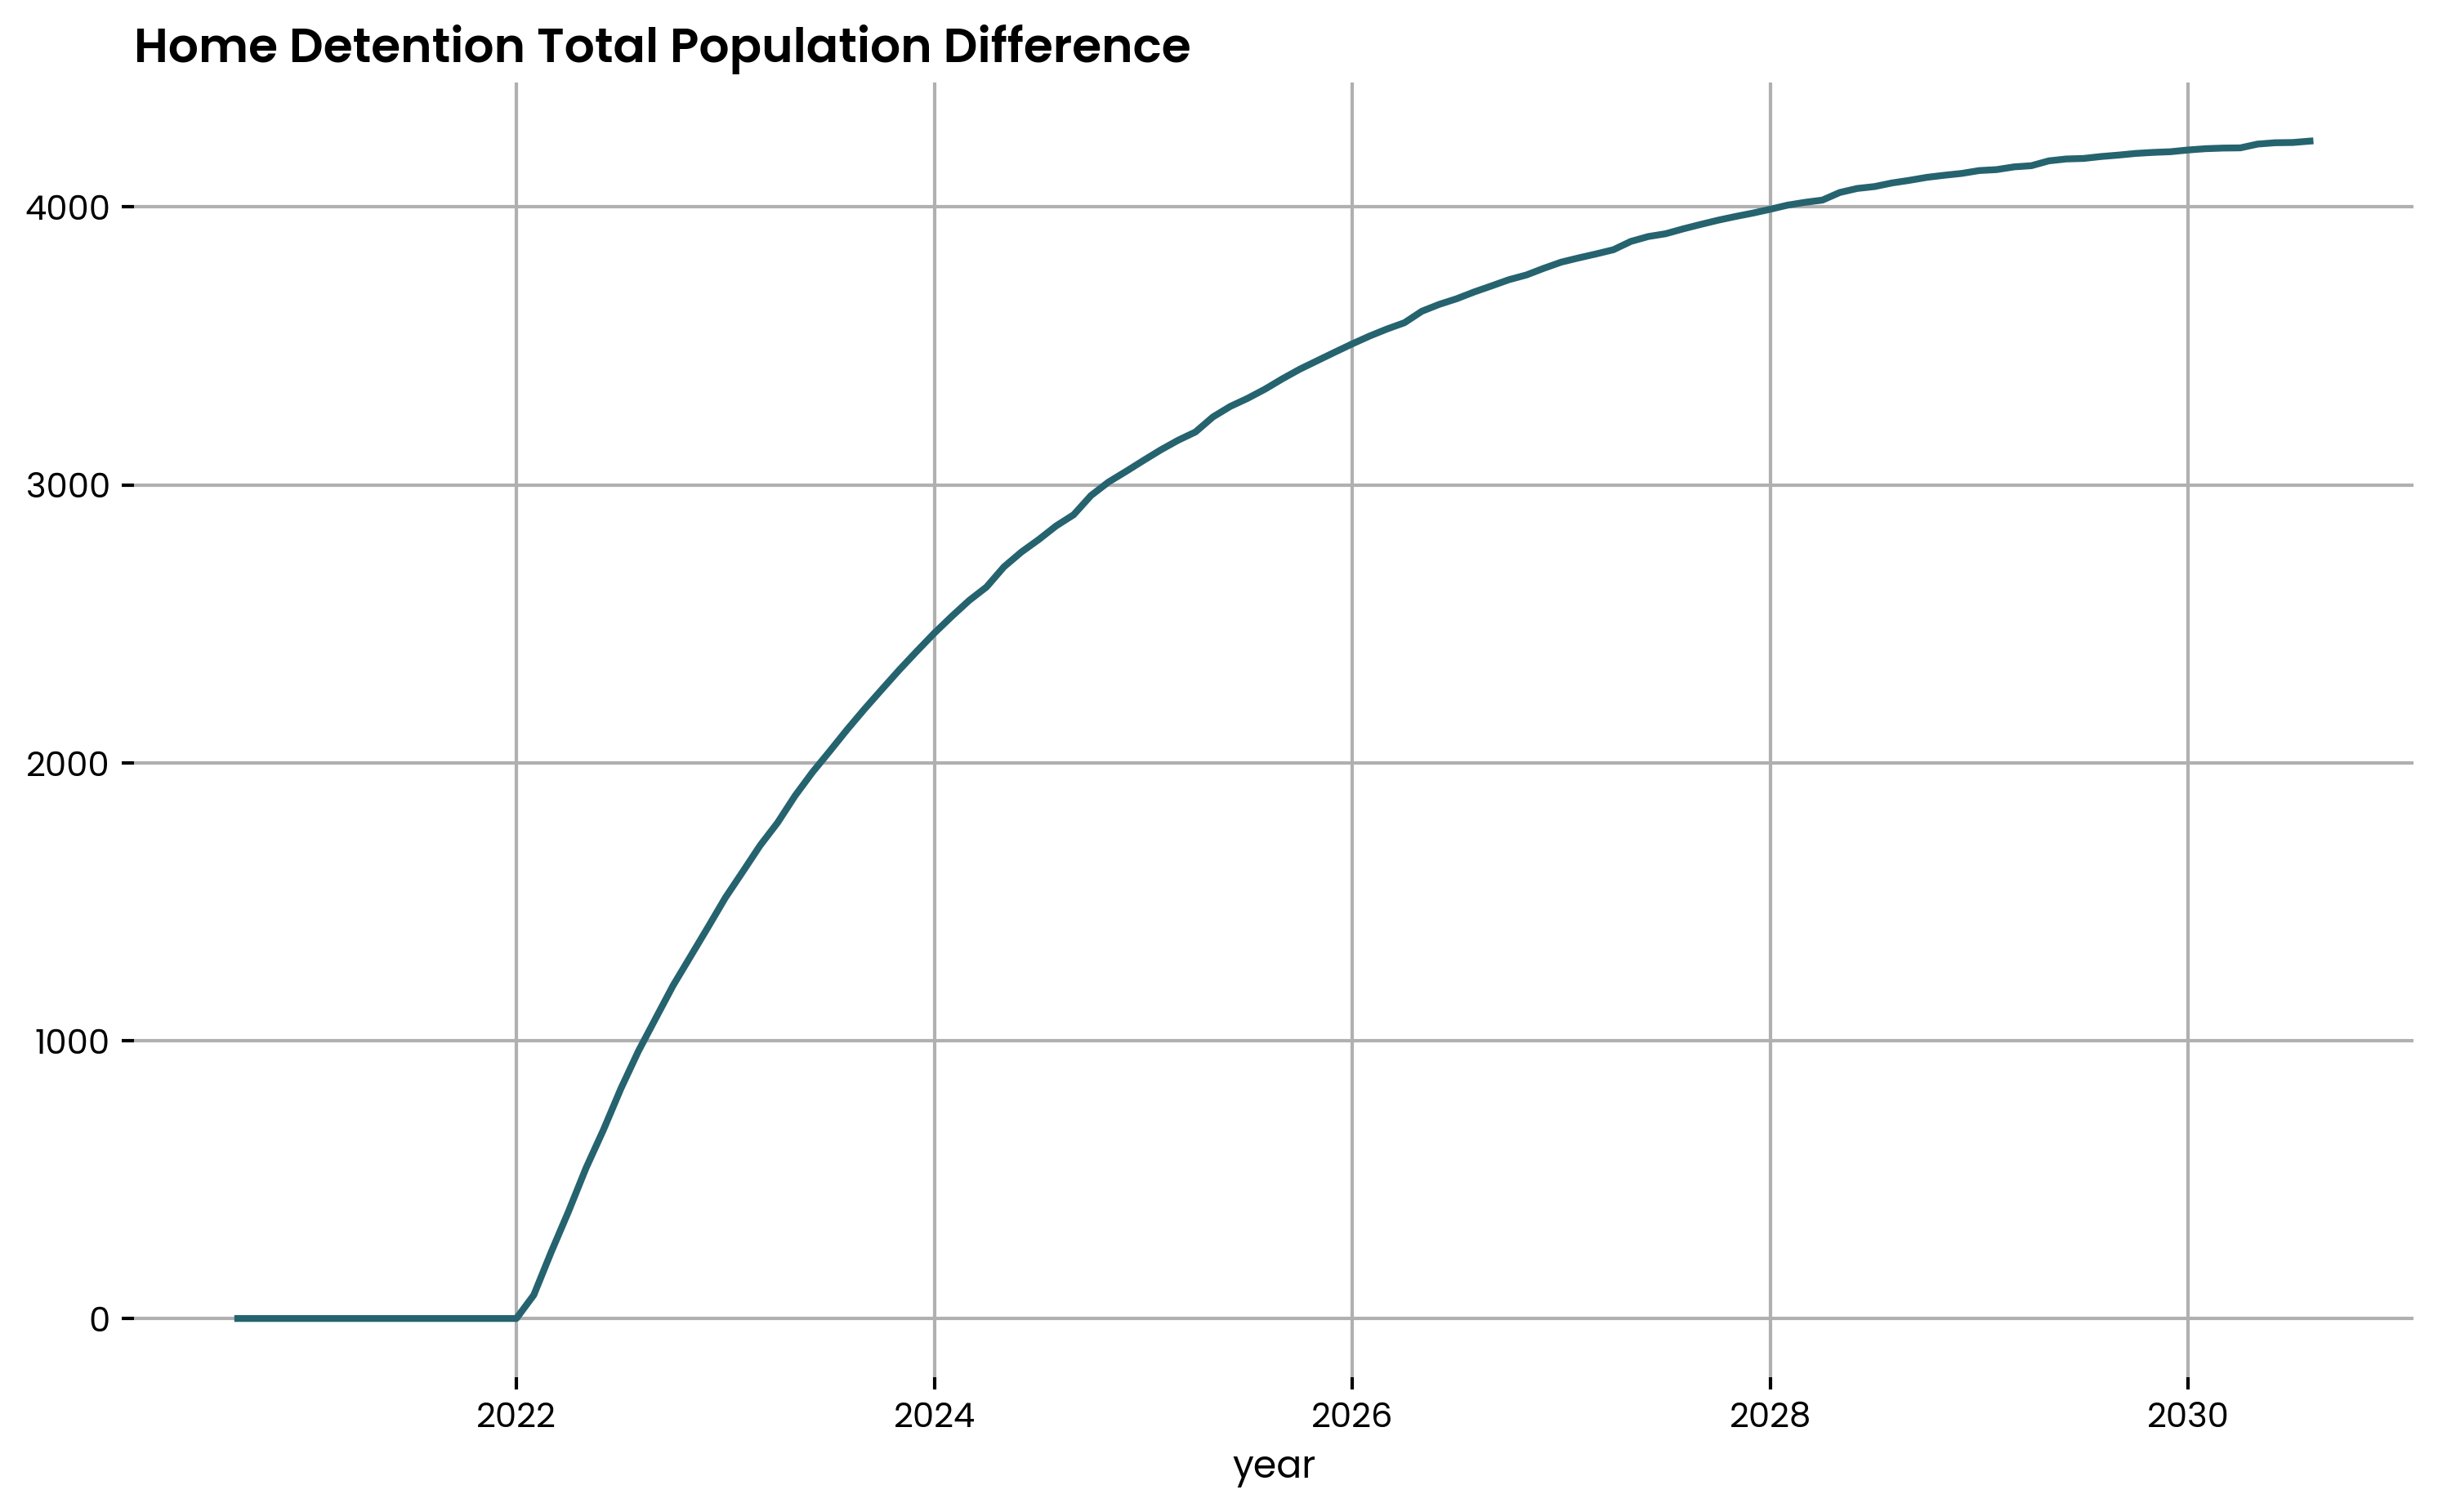

In [232]:
test_results[test_results["compartment"] == "home_detent"].plot(
    x="year", y="population_difference"
)
plt.title(f"Home Detention Total Population Difference")
plt.legend().remove()

Text(0.0, 1.0, 'Baseline Simulation Projected Transitions')

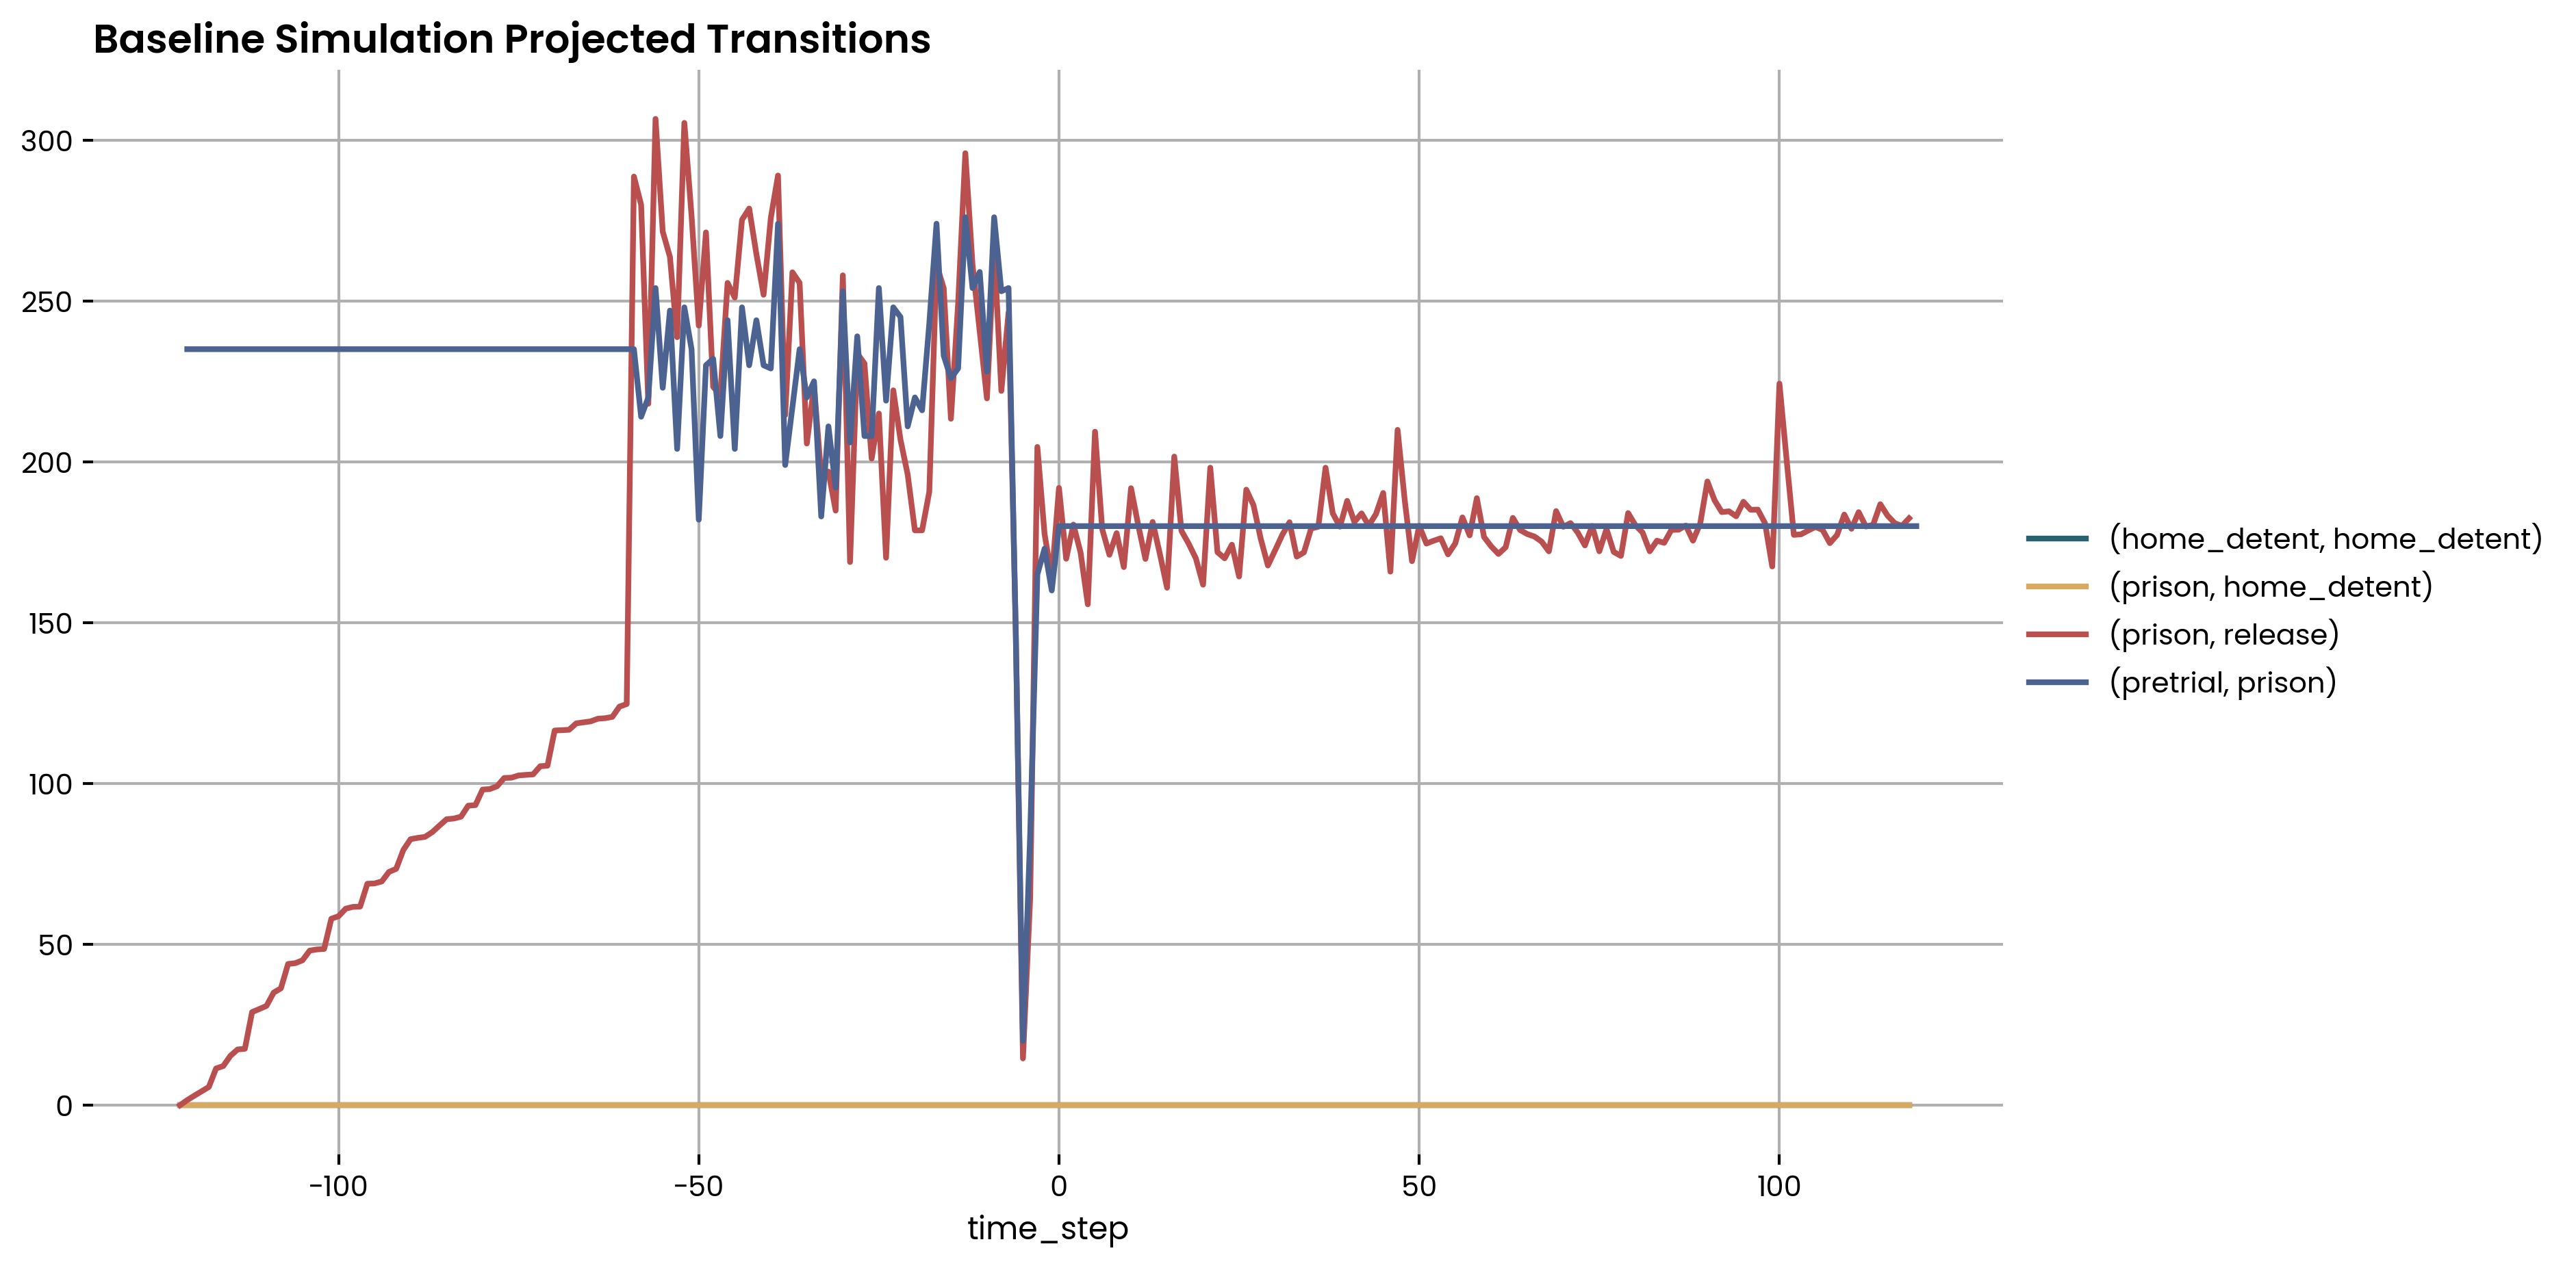

In [219]:
baseline_outflows = test_sim.validator.pop_simulations["control"].get_outflows().copy()
baseline_outflows = baseline_outflows[baseline_outflows["compartment"] != "release"]
baseline_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Baseline Simulation Projected Transitions")

Text(0.0, 1.0, 'Policy Simulation Projected Transitions')

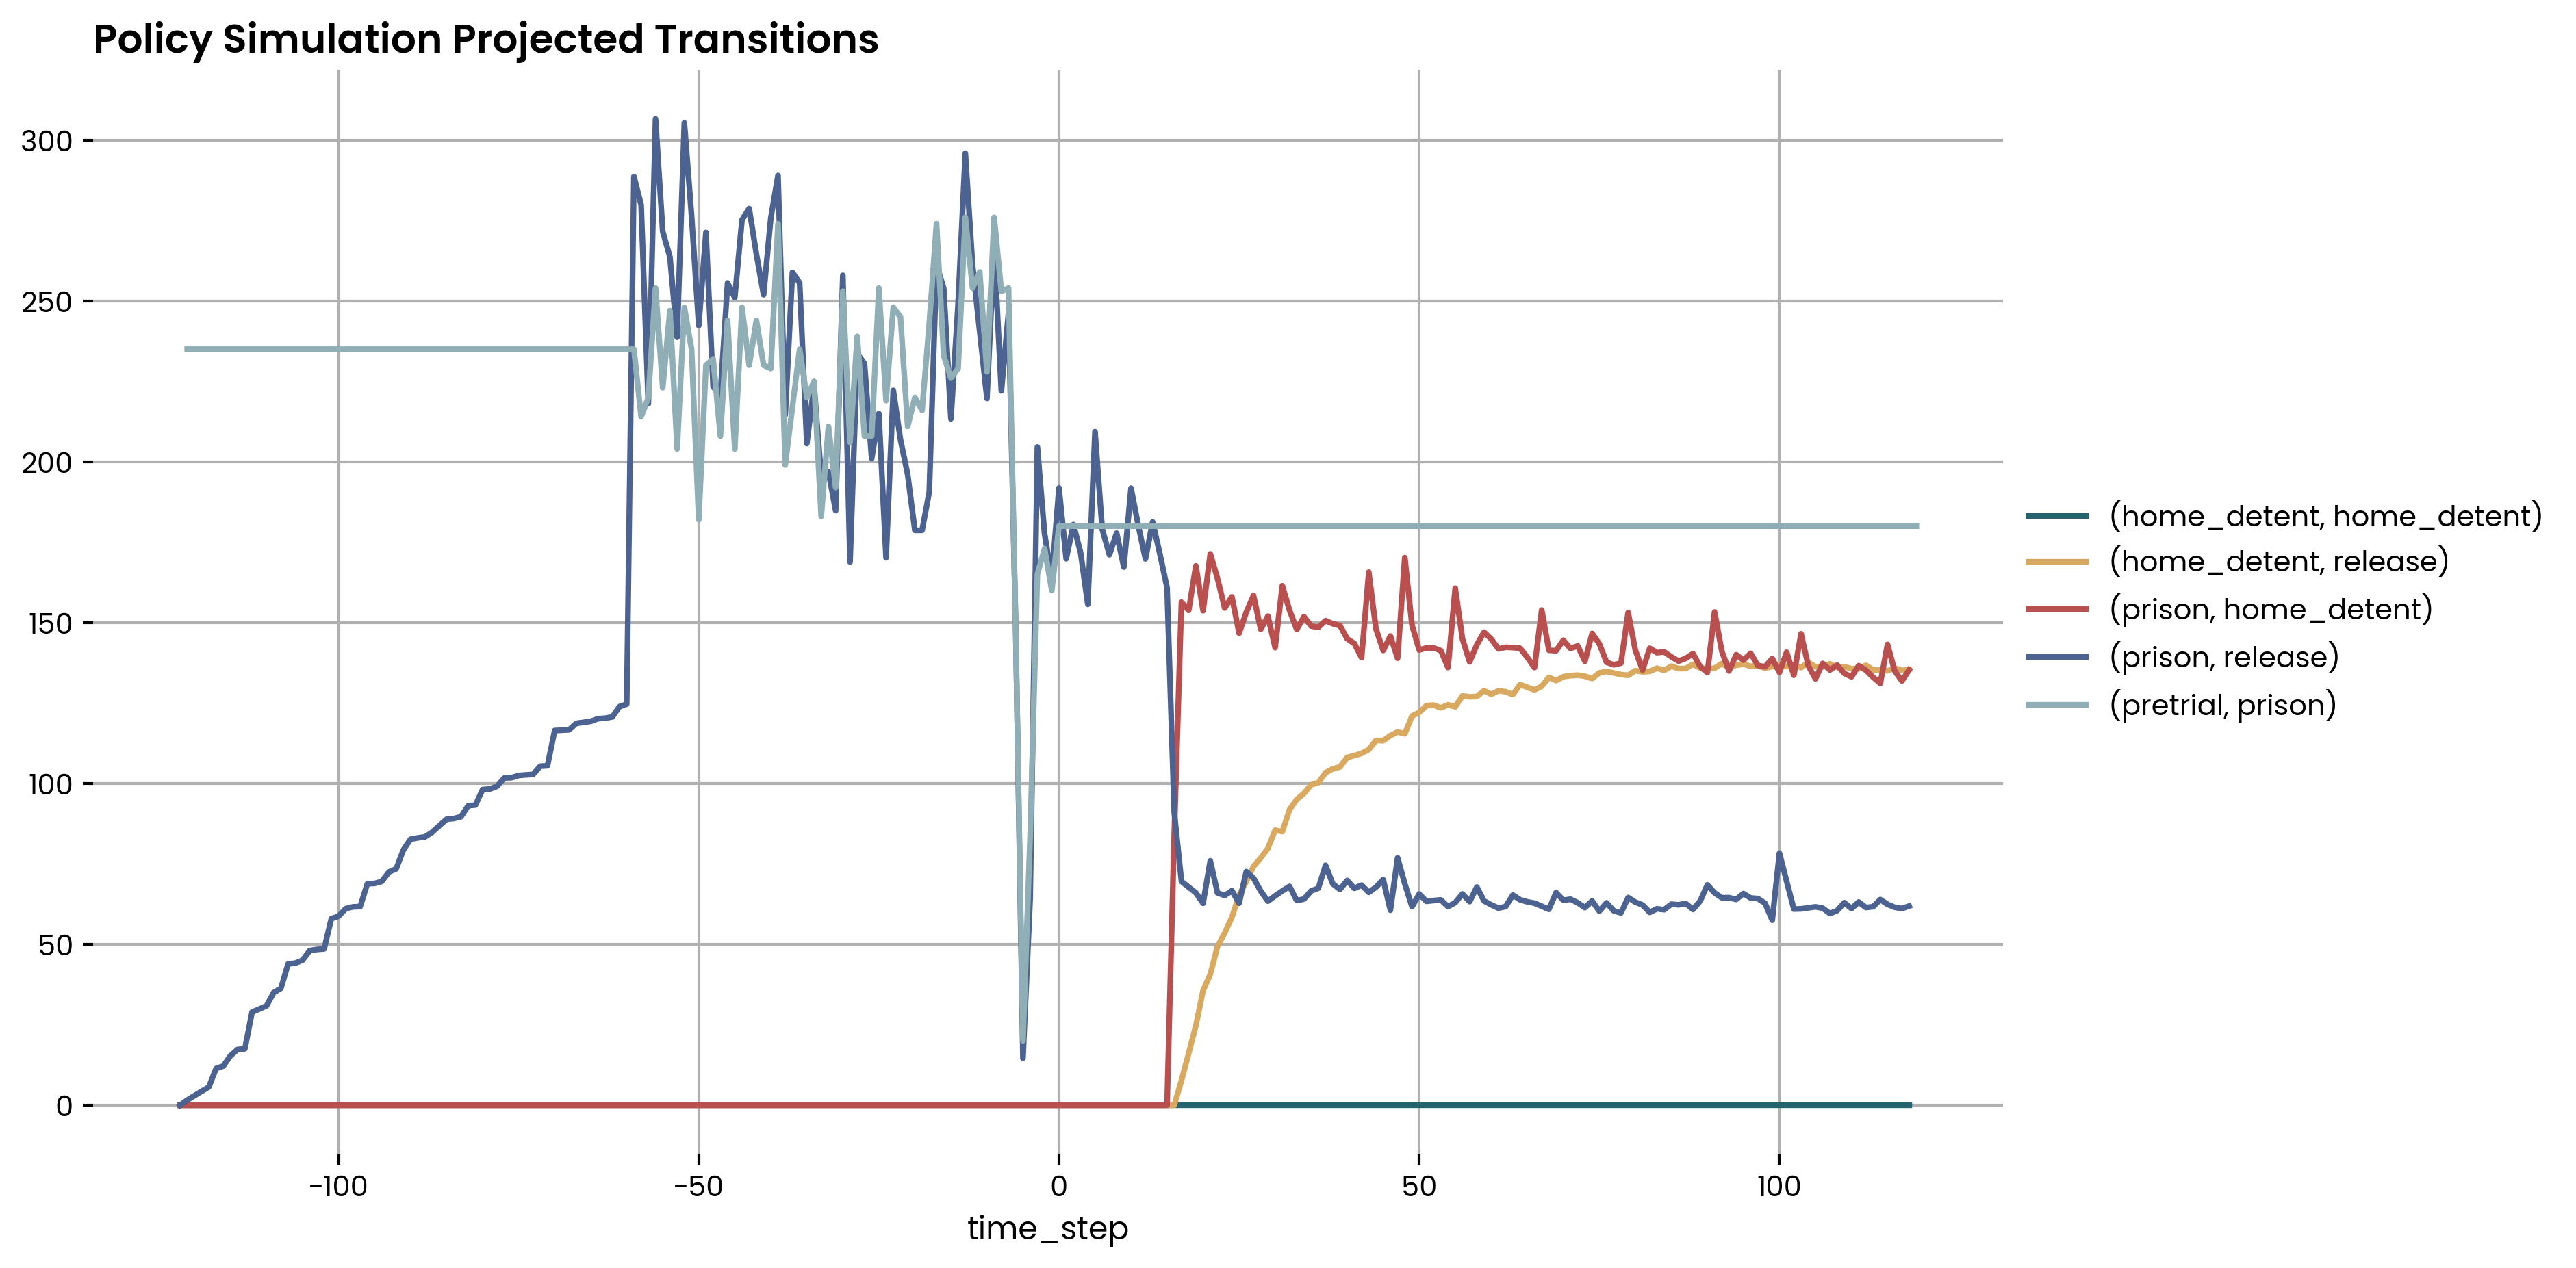

In [259]:
policy_outflows = test_sim.validator.pop_simulations["policy"].get_outflows().copy()
policy_outflows = policy_outflows[policy_outflows["compartment"] != "release"]
policy_outflows.groupby(["time_step", "compartment", "outflow_to"]).sum()[
    "total_population"
].unstack(["compartment", "outflow_to"]).plot()
add_legend()
plt.title("Policy Simulation Projected Transitions")

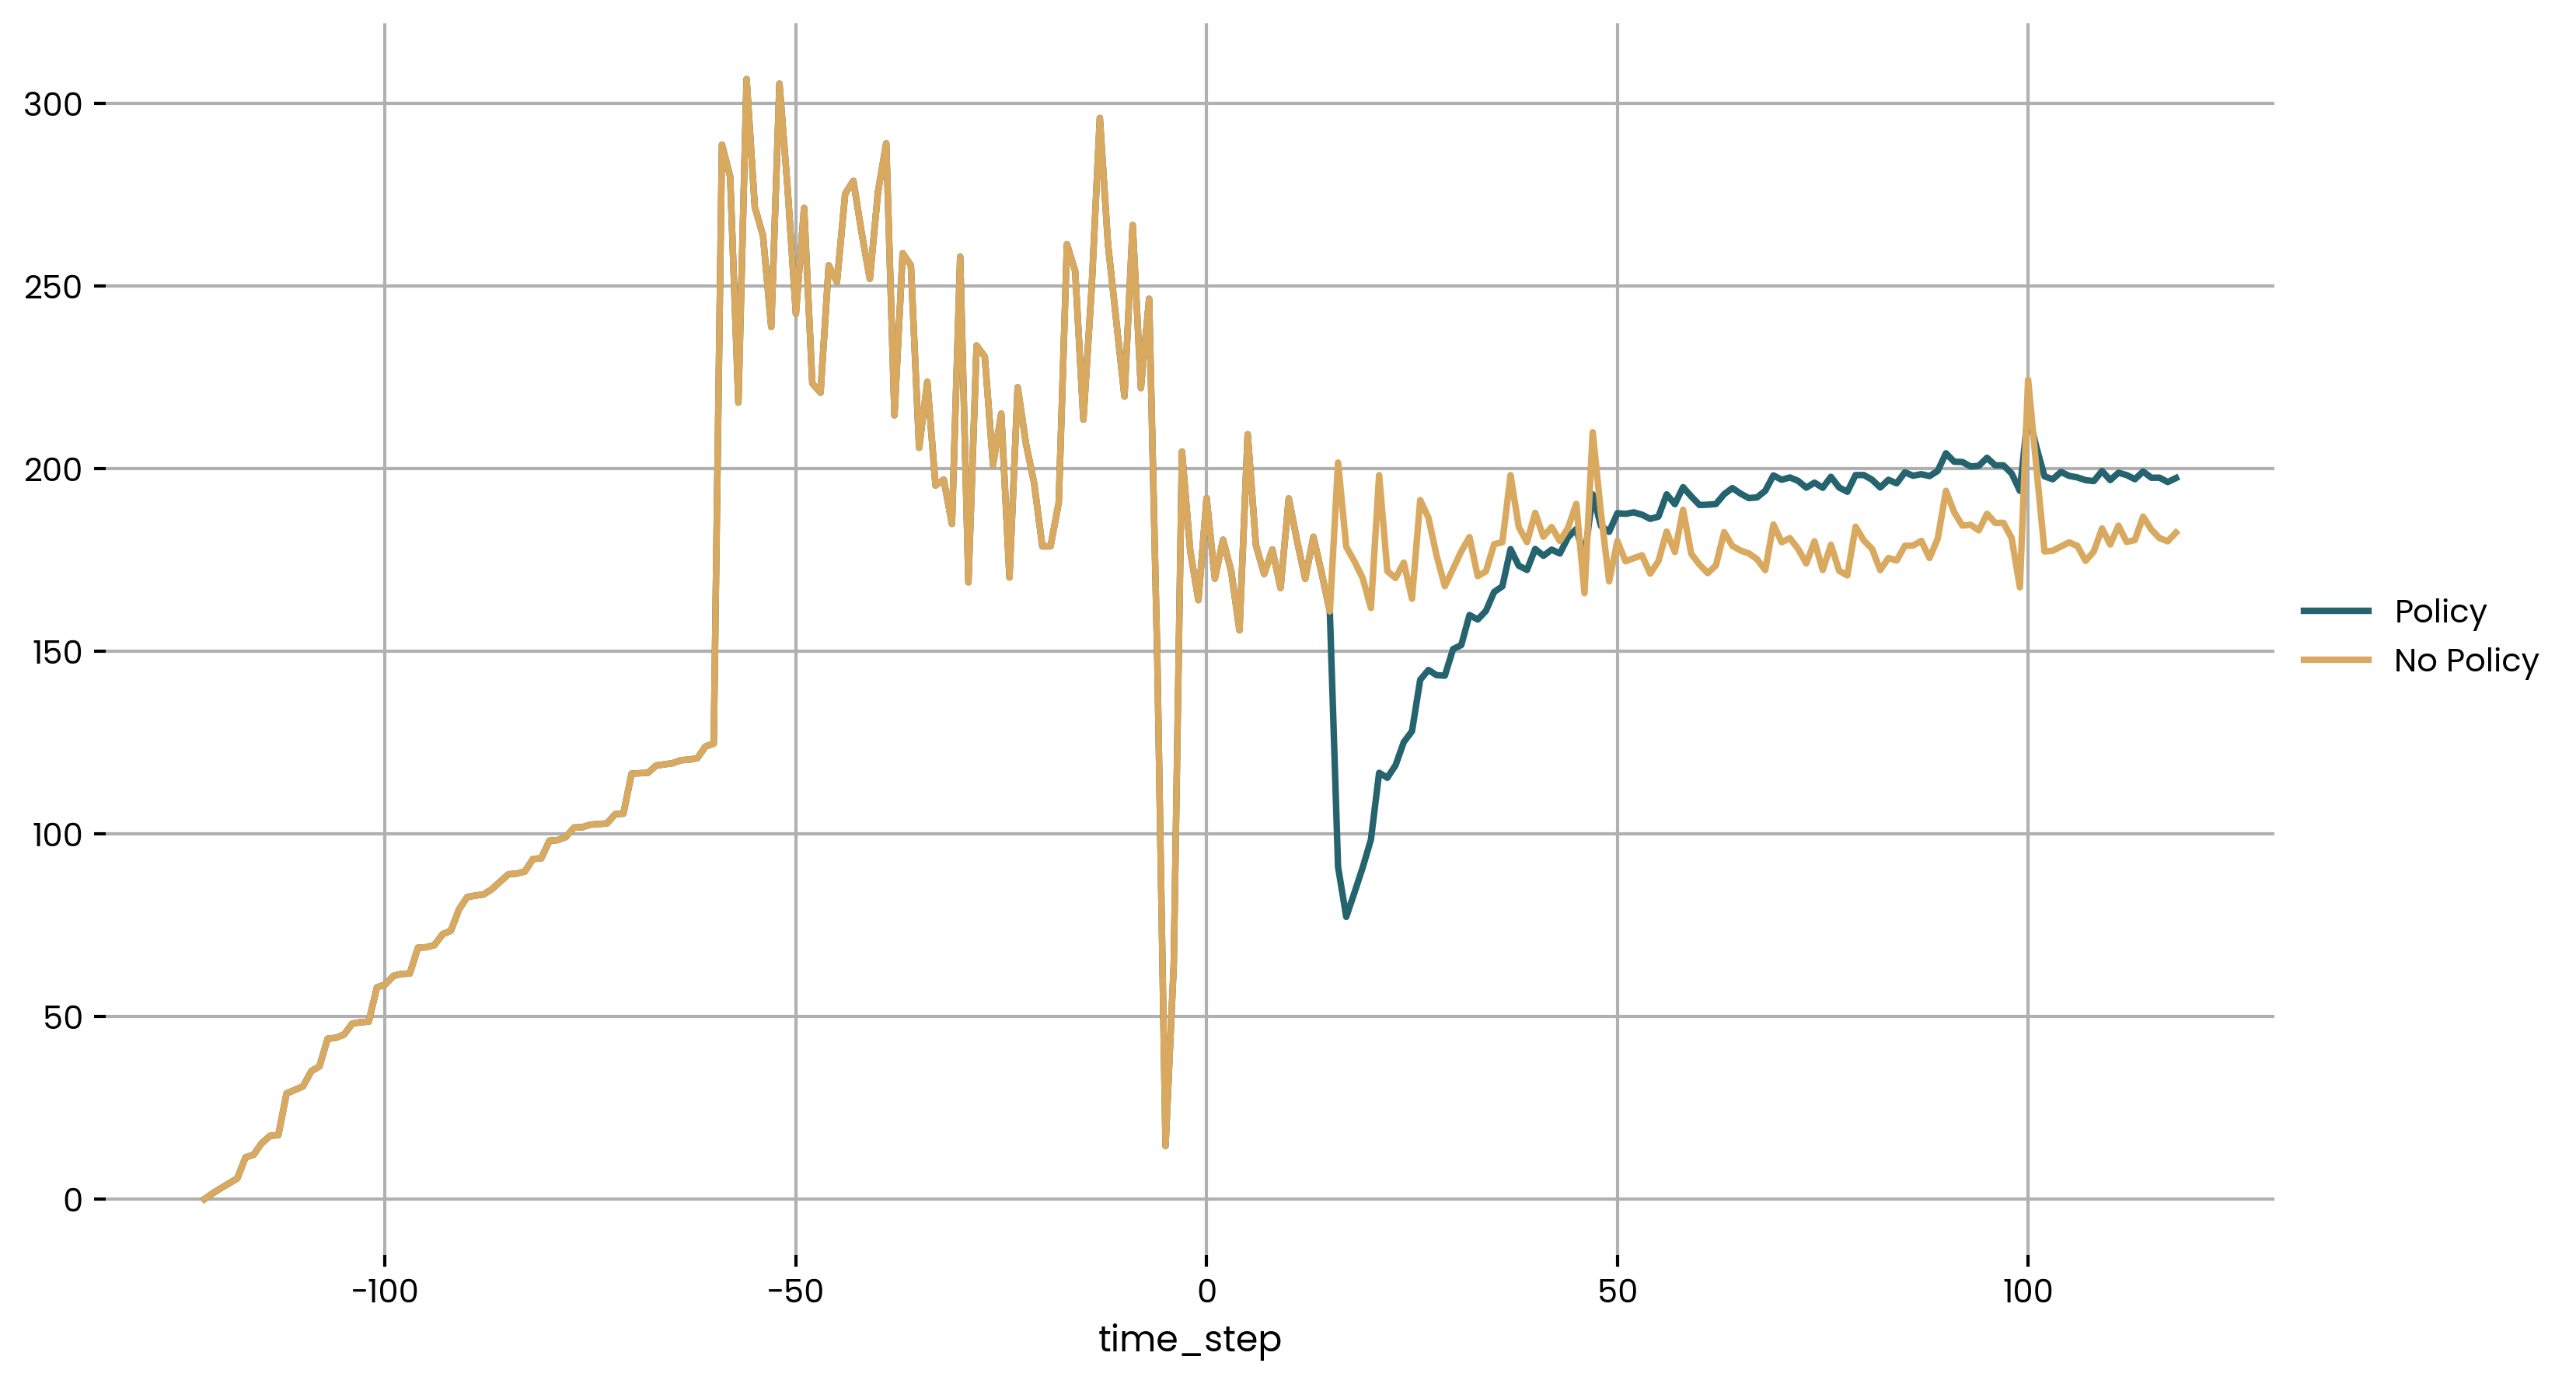

In [260]:
prison_to_release = policy_outflows[policy_outflows["compartment"] == "prison"].loc[
    "release"
]
home_to_release = policy_outflows[policy_outflows["compartment"] == "home_detent"].loc[
    "release"
]
ax = (prison_to_release["total_population"] + home_to_release["total_population"]).plot(
    label="Policy"
)

baseline_outflows[baseline_outflows["compartment"] == "prison"].loc[
    "release", "total_population"
].plot(ax=ax, label="No Policy")
add_legend()

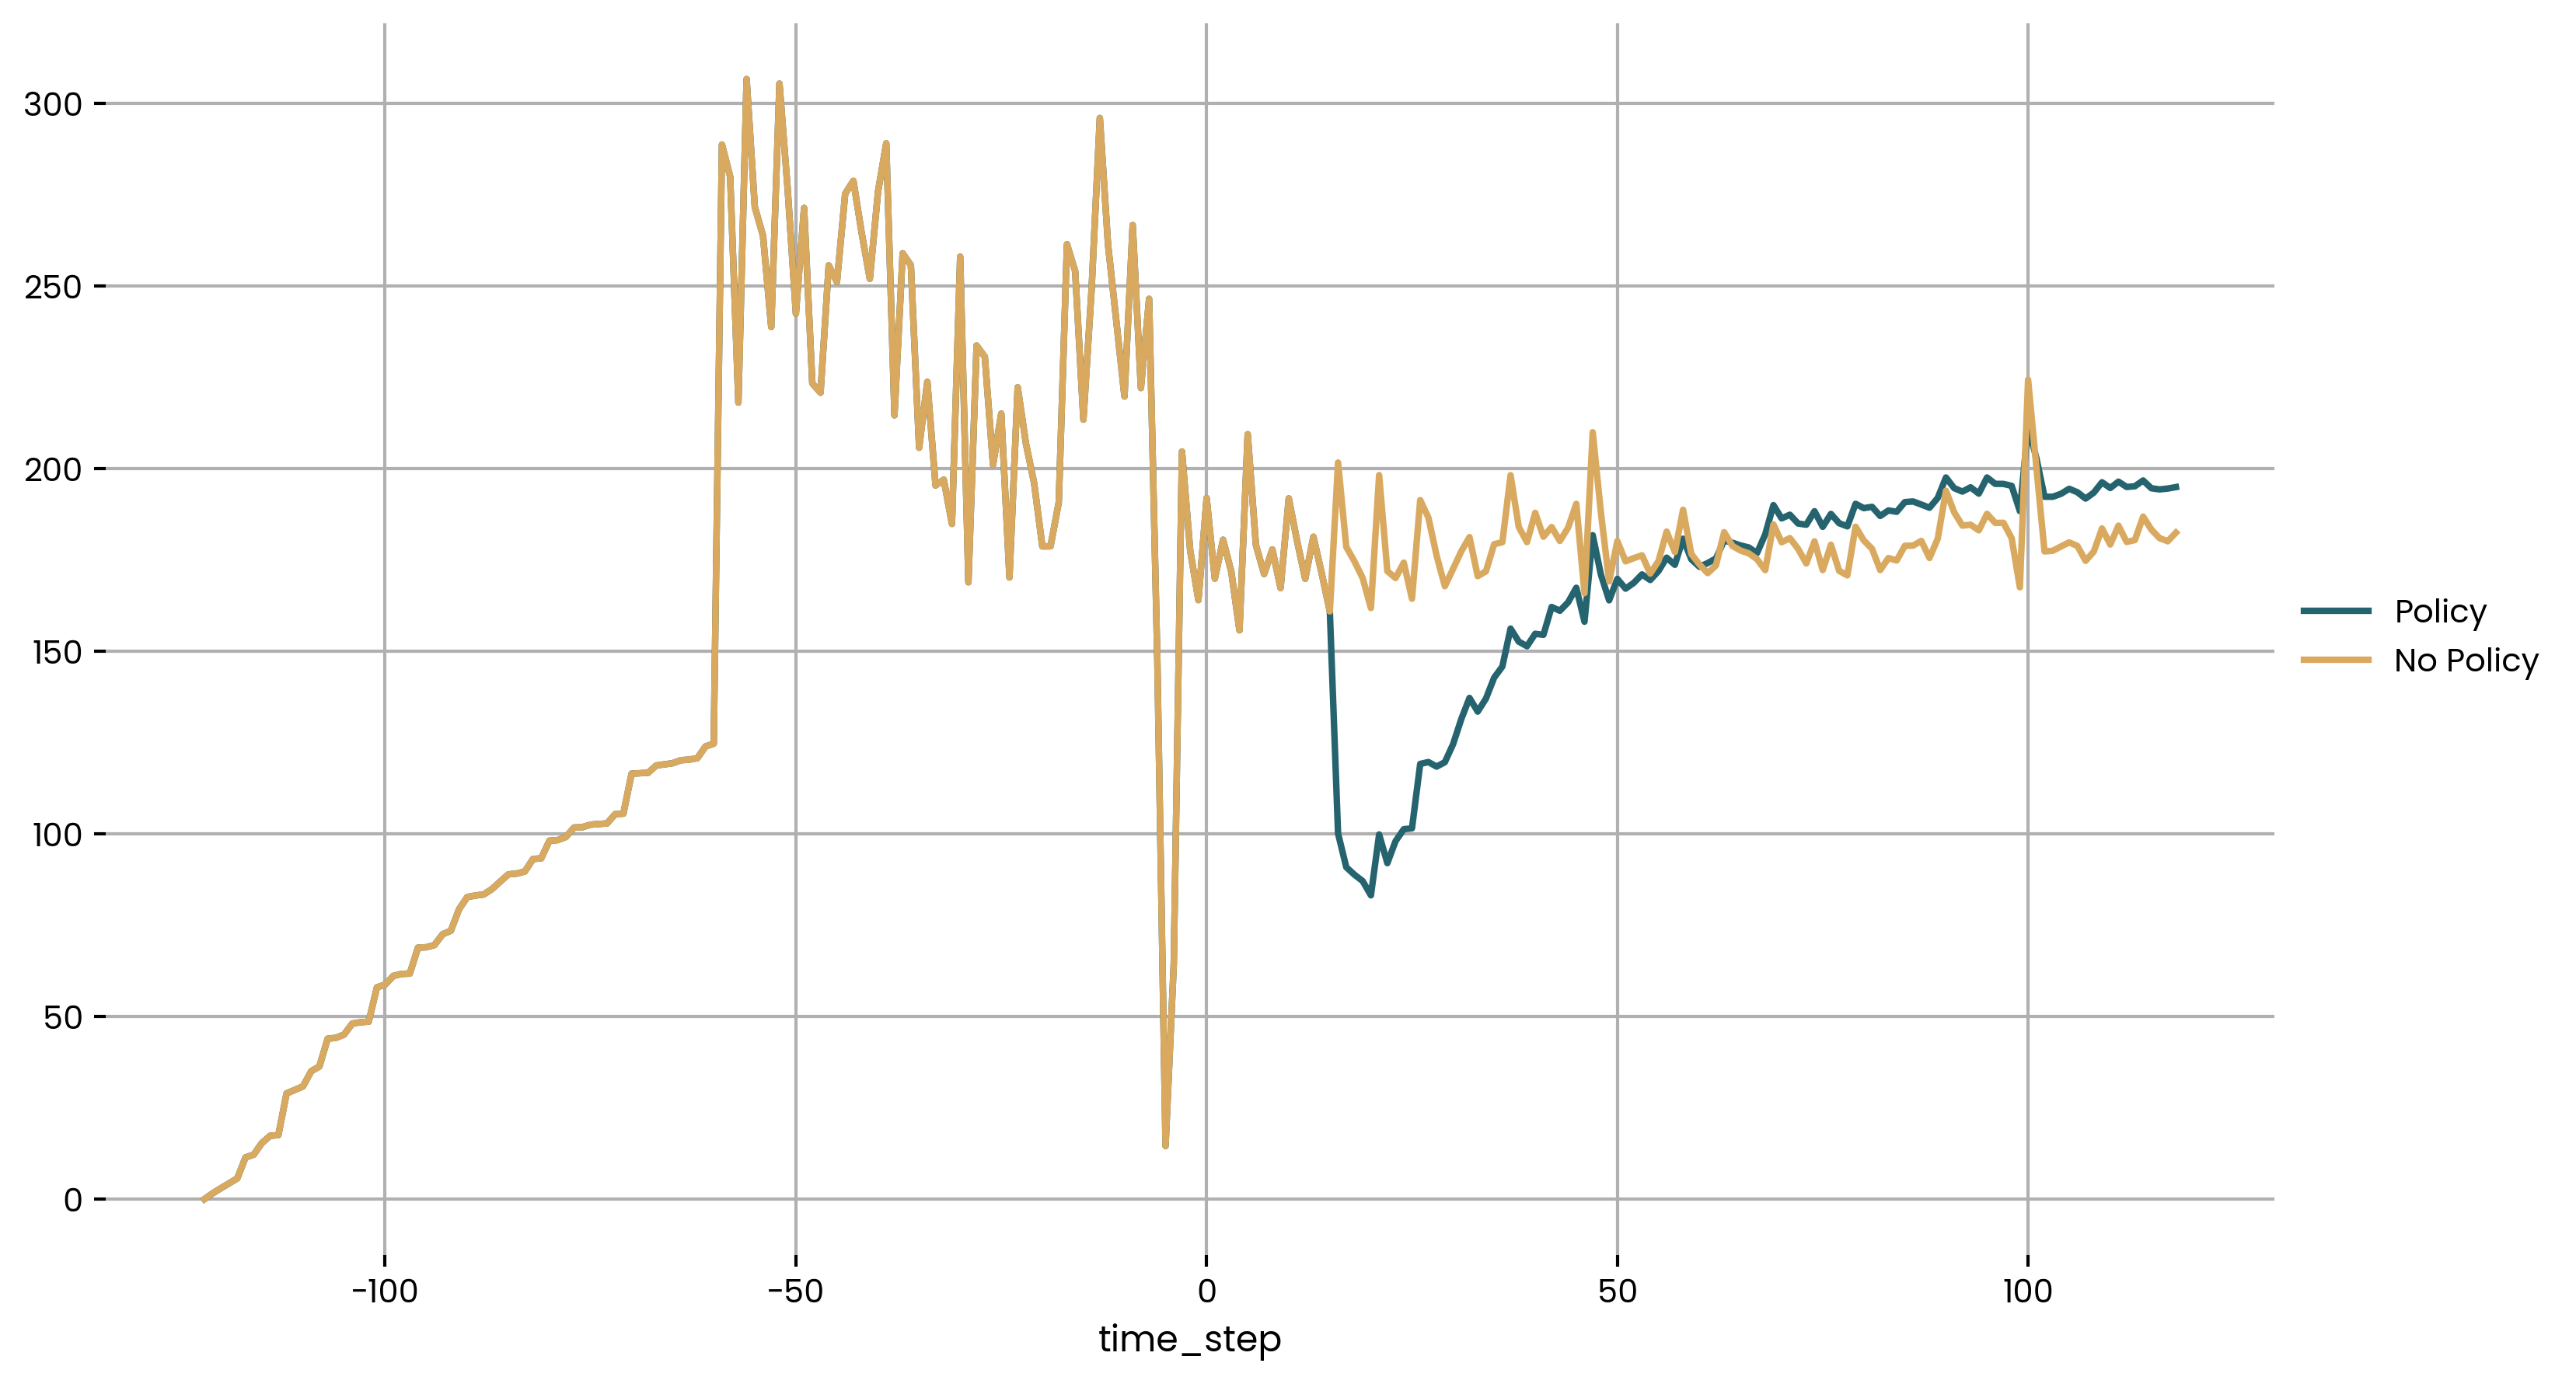

In [135]:
prison_to_release = policy_outflows[policy_outflows["compartment"] == "prison"].loc[
    "release"
]
home_to_release = policy_outflows[policy_outflows["compartment"] == "home_detent"].loc[
    "release"
]
ax = (prison_to_release["total_population"] + home_to_release["total_population"]).plot(
    label="Policy"
)

baseline_outflows[baseline_outflows["compartment"] == "prison"].loc[
    "release", "total_population"
].plot(ax=ax, label="No Policy")
add_legend()

<AxesSubplot:xlabel='time_step'>

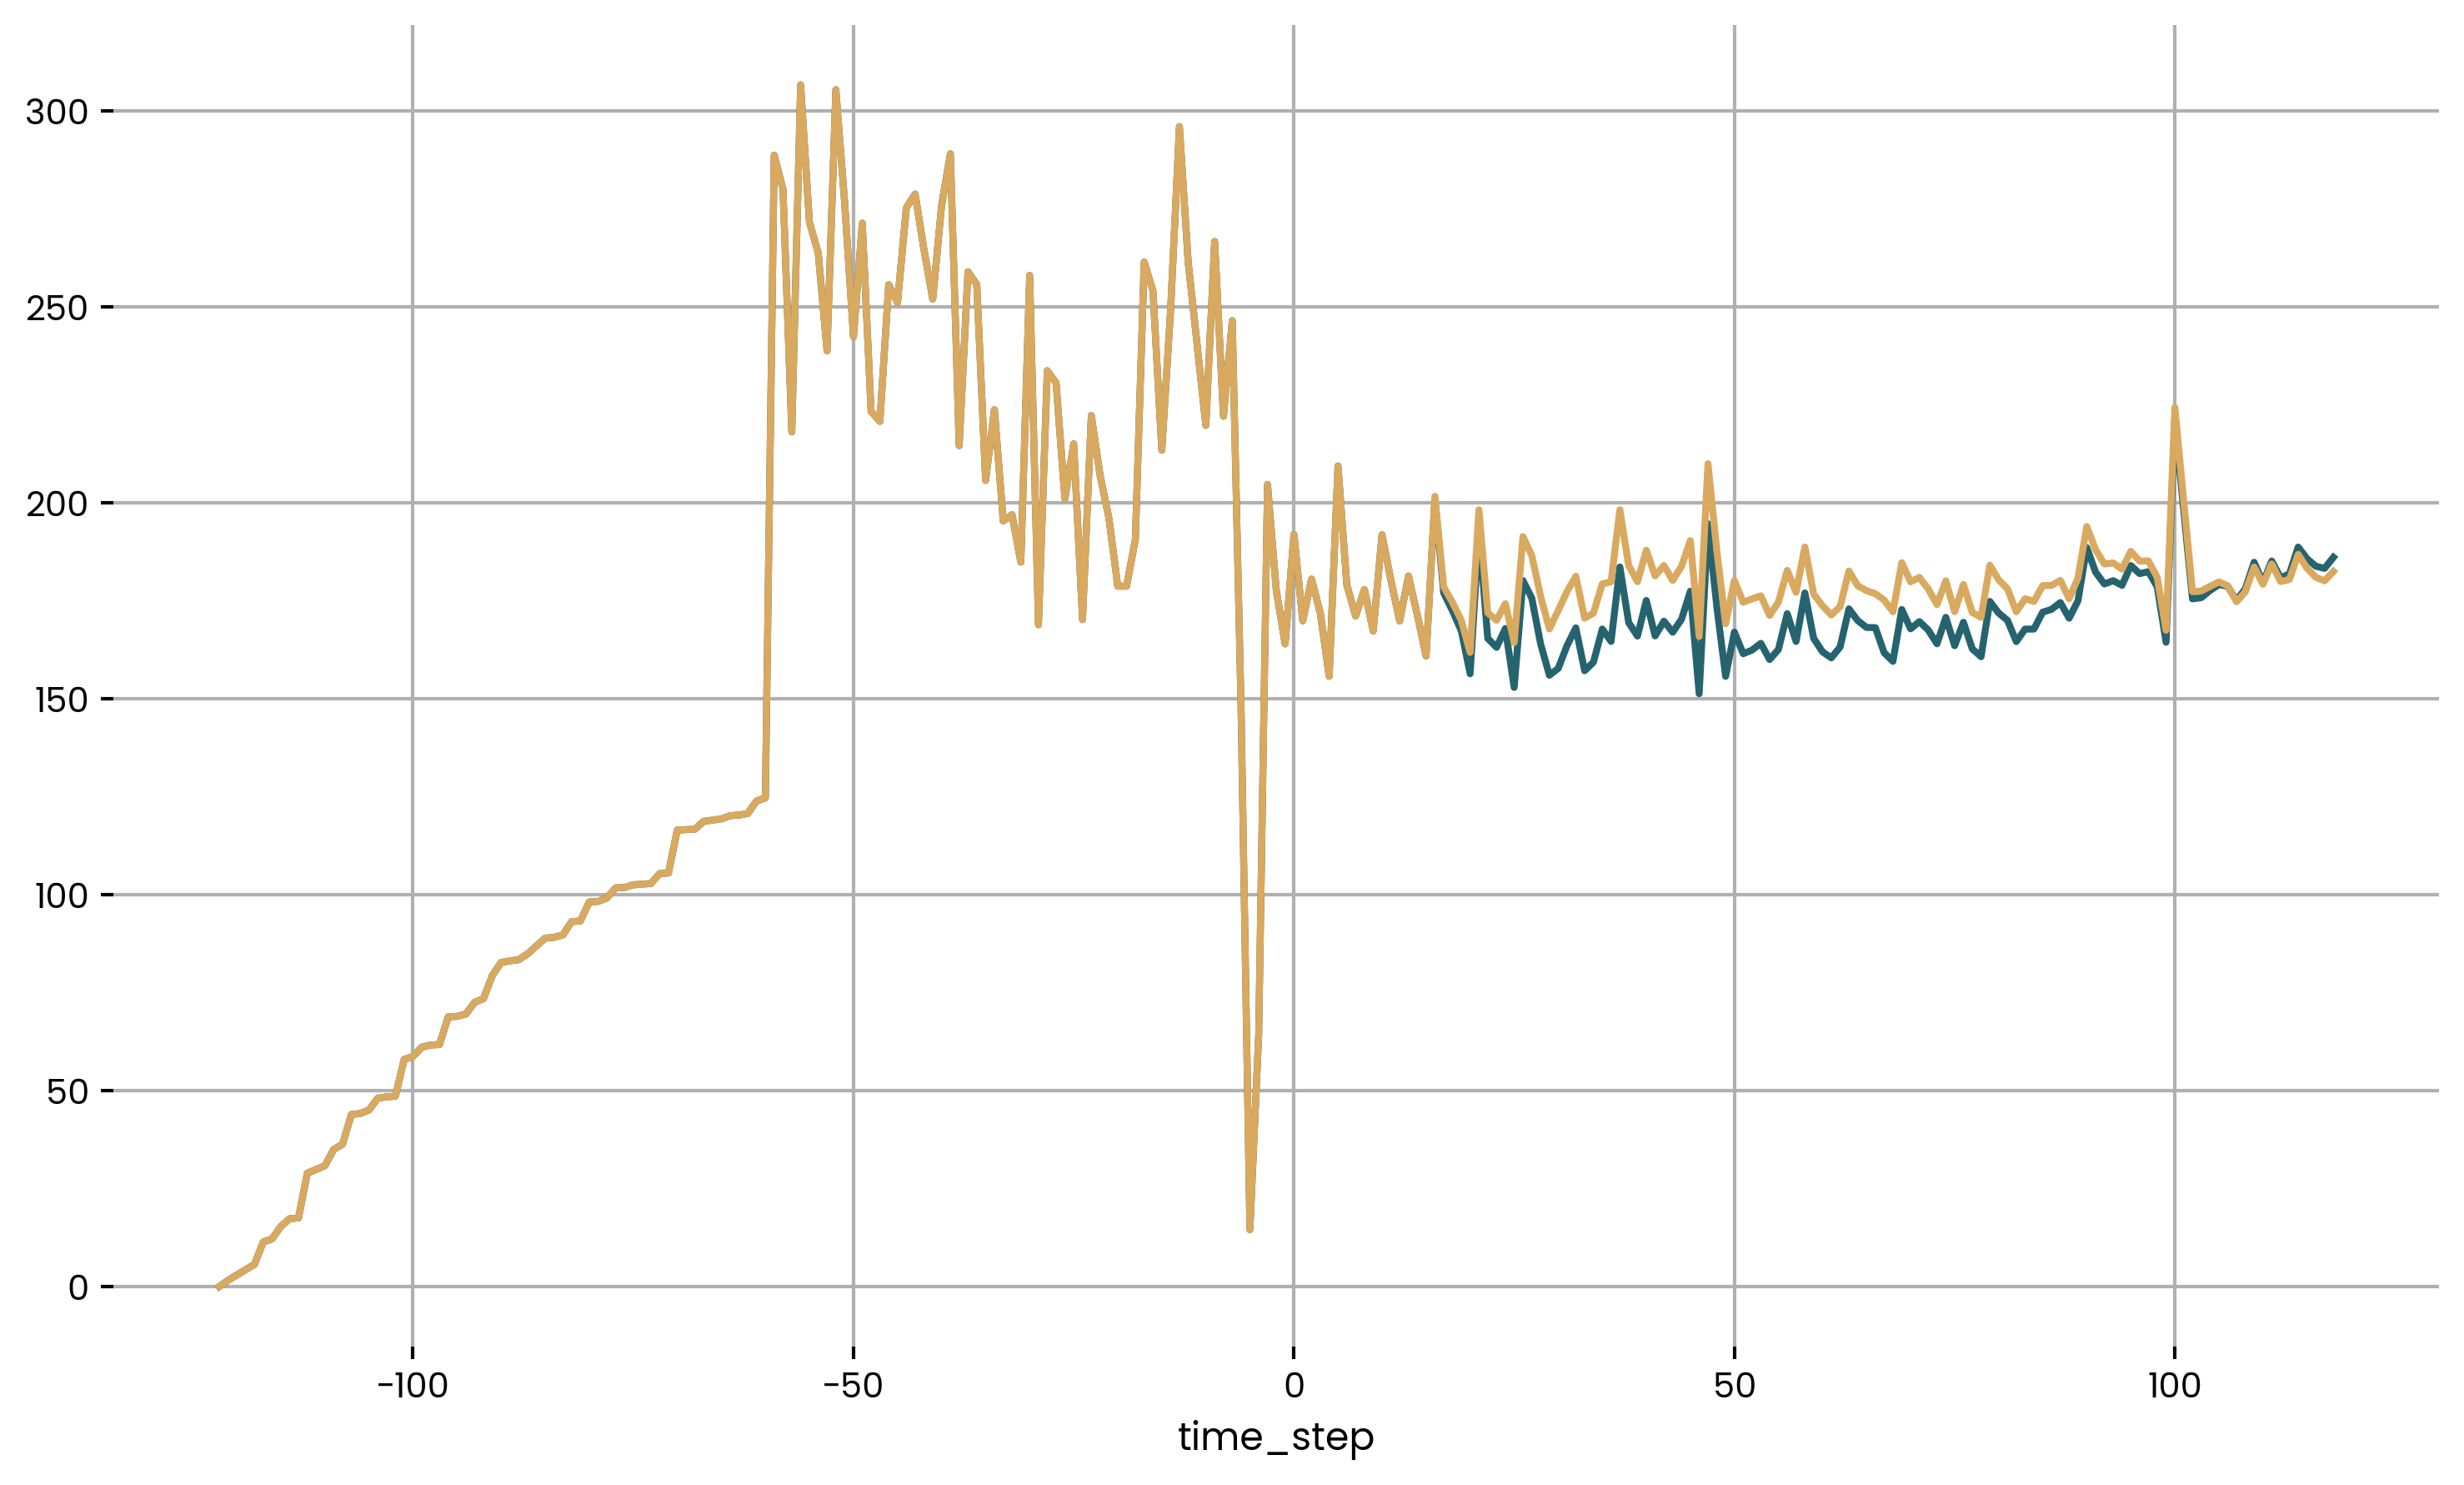

In [24]:
prison_to_release = policy_outflows[policy_outflows["compartment"] == "prison"].loc[
    "release"
]
home_to_release = policy_outflows[policy_outflows["compartment"] == "home_detent"].loc[
    "release"
]
ax = (
    prison_to_release["total_population"] + home_to_release["total_population"]
).plot()

baseline_outflows[baseline_outflows["compartment"] == "prison"].loc[
    "release", "total_population"
].plot(ax=ax)

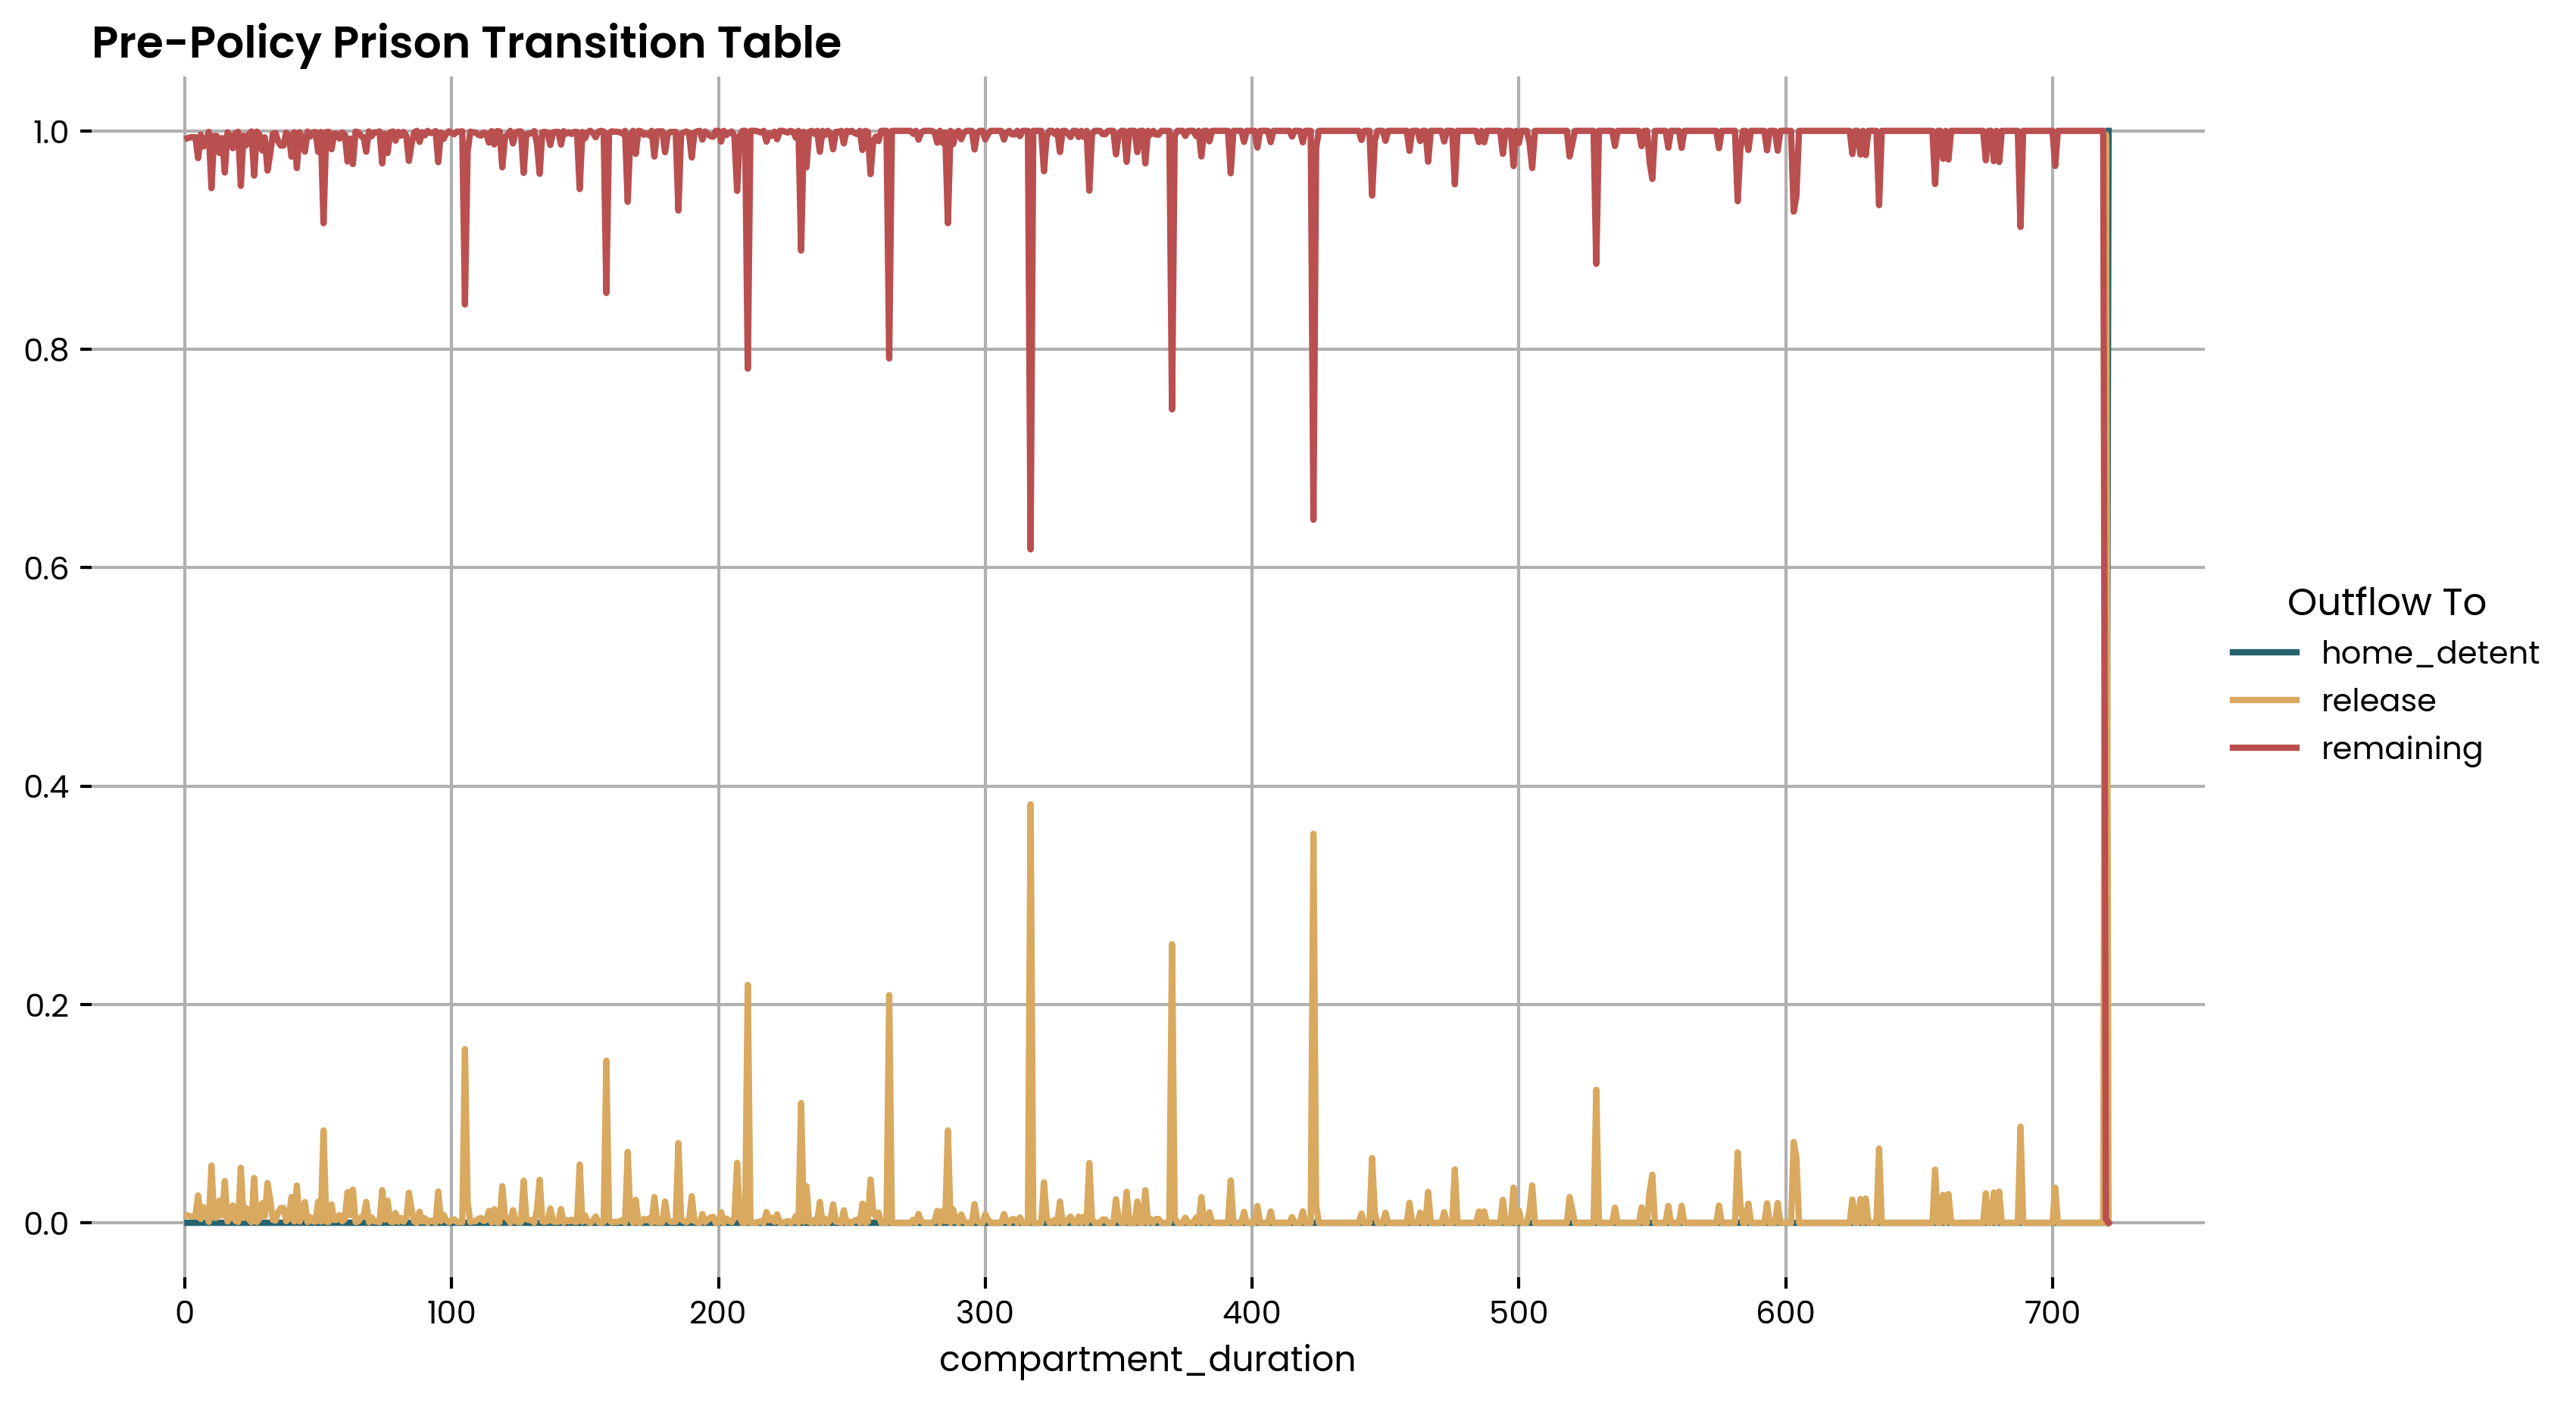

In [261]:
for compartment in ["prison"]:
    transition_dfs = (
        test_sim.validator.pop_simulations["policy"]
        .sub_simulations["x"]
        .simulation_compartments[compartment]
        .compartment_transitions.transition_tables
    )
    policy_key = min(transition_dfs.keys())
    for transition_type in [TransitionTableType.AFTER]:
        transition_dfs[policy_key].transition_dfs[transition_type].plot()
        plt.title(f"Pre-Policy {compartment.title()} Transition Table")
        add_legend(title="Outflow To")

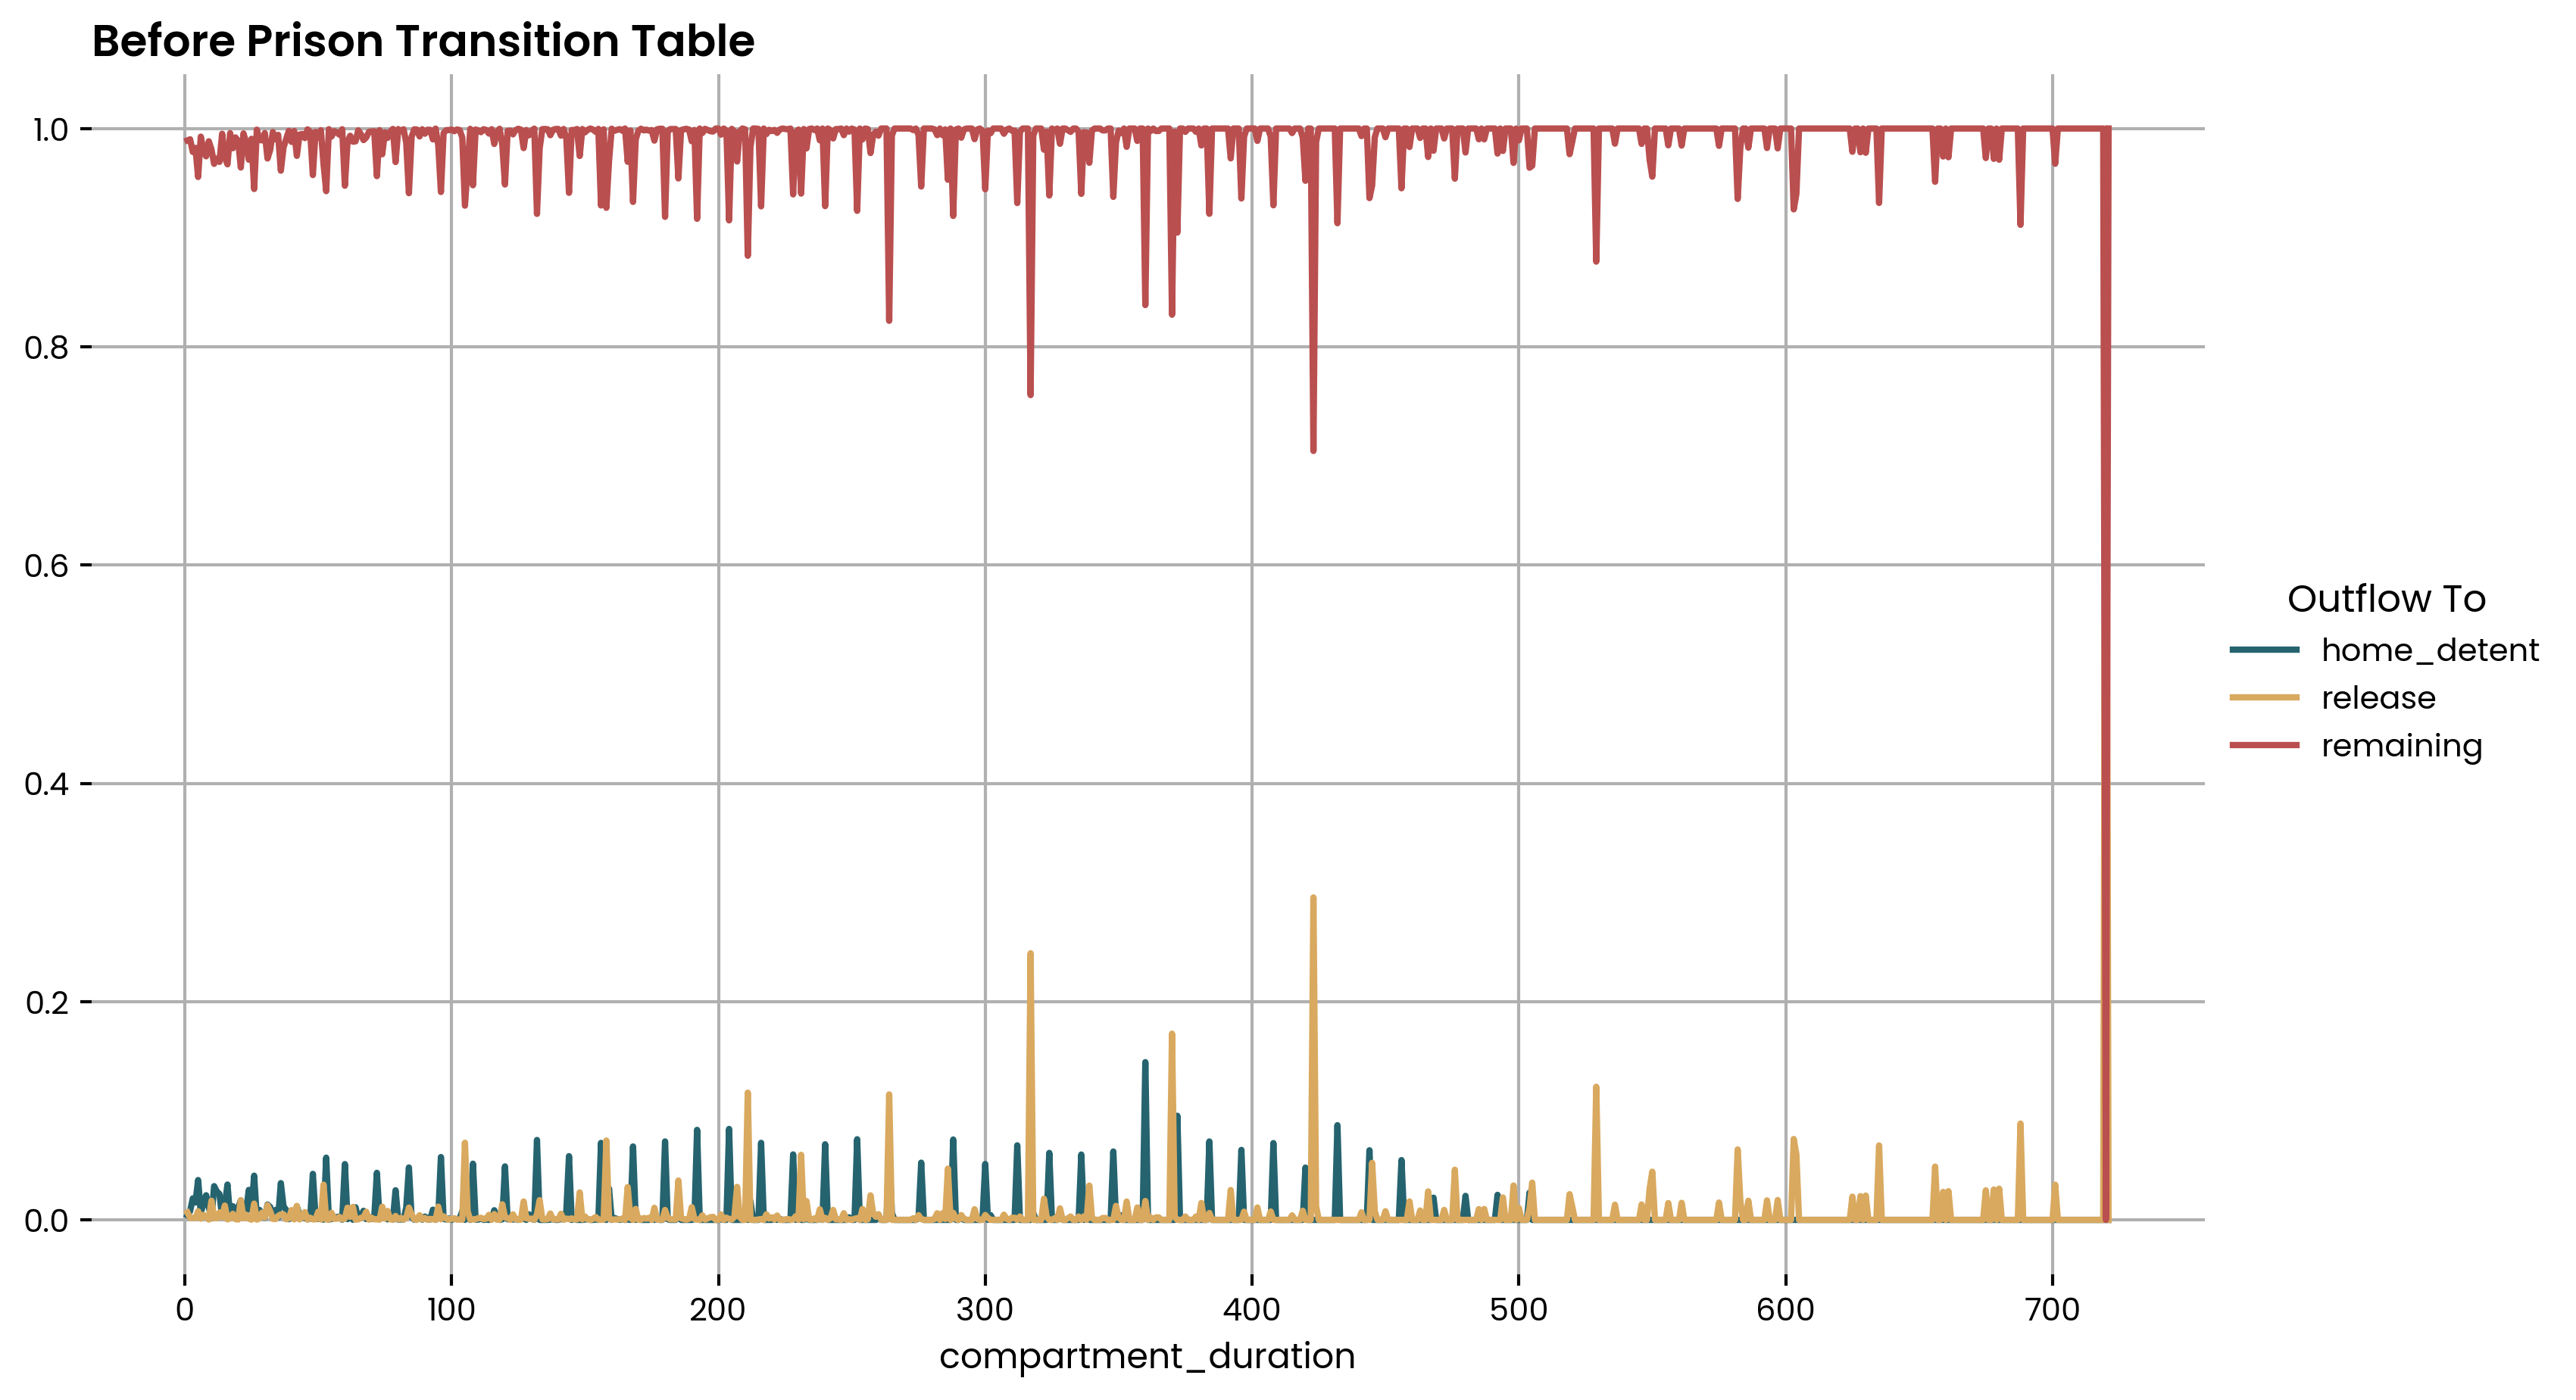

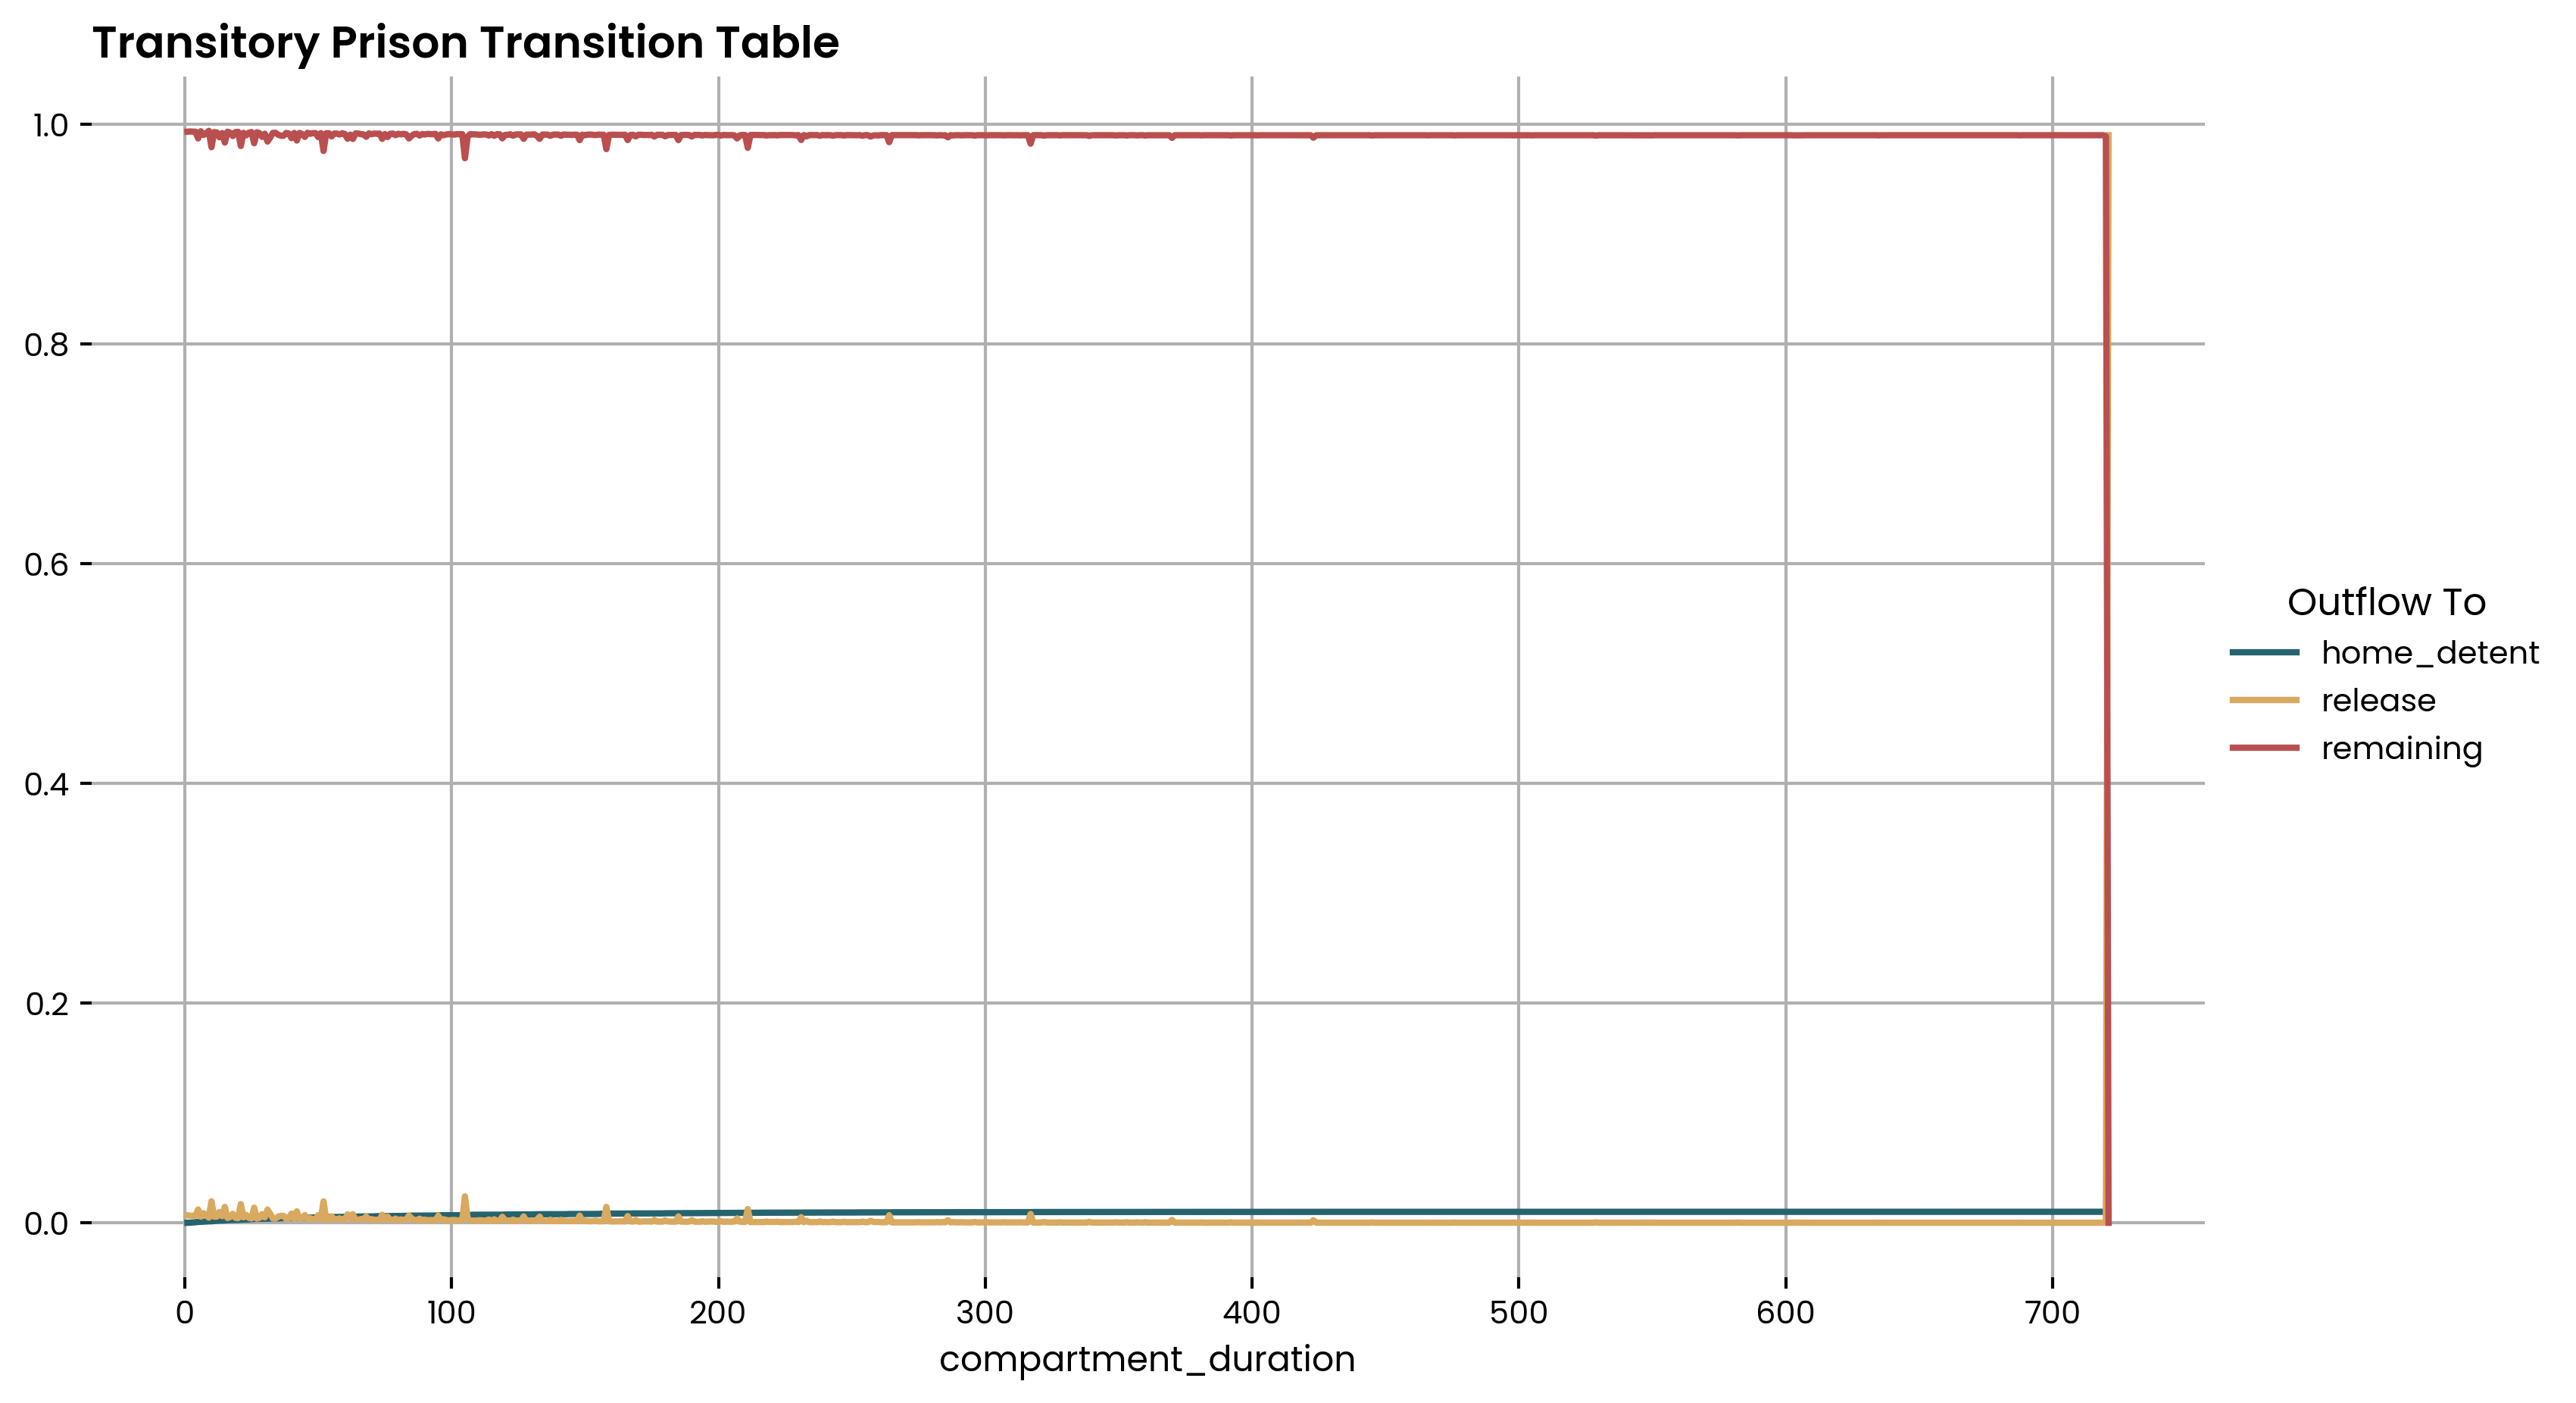

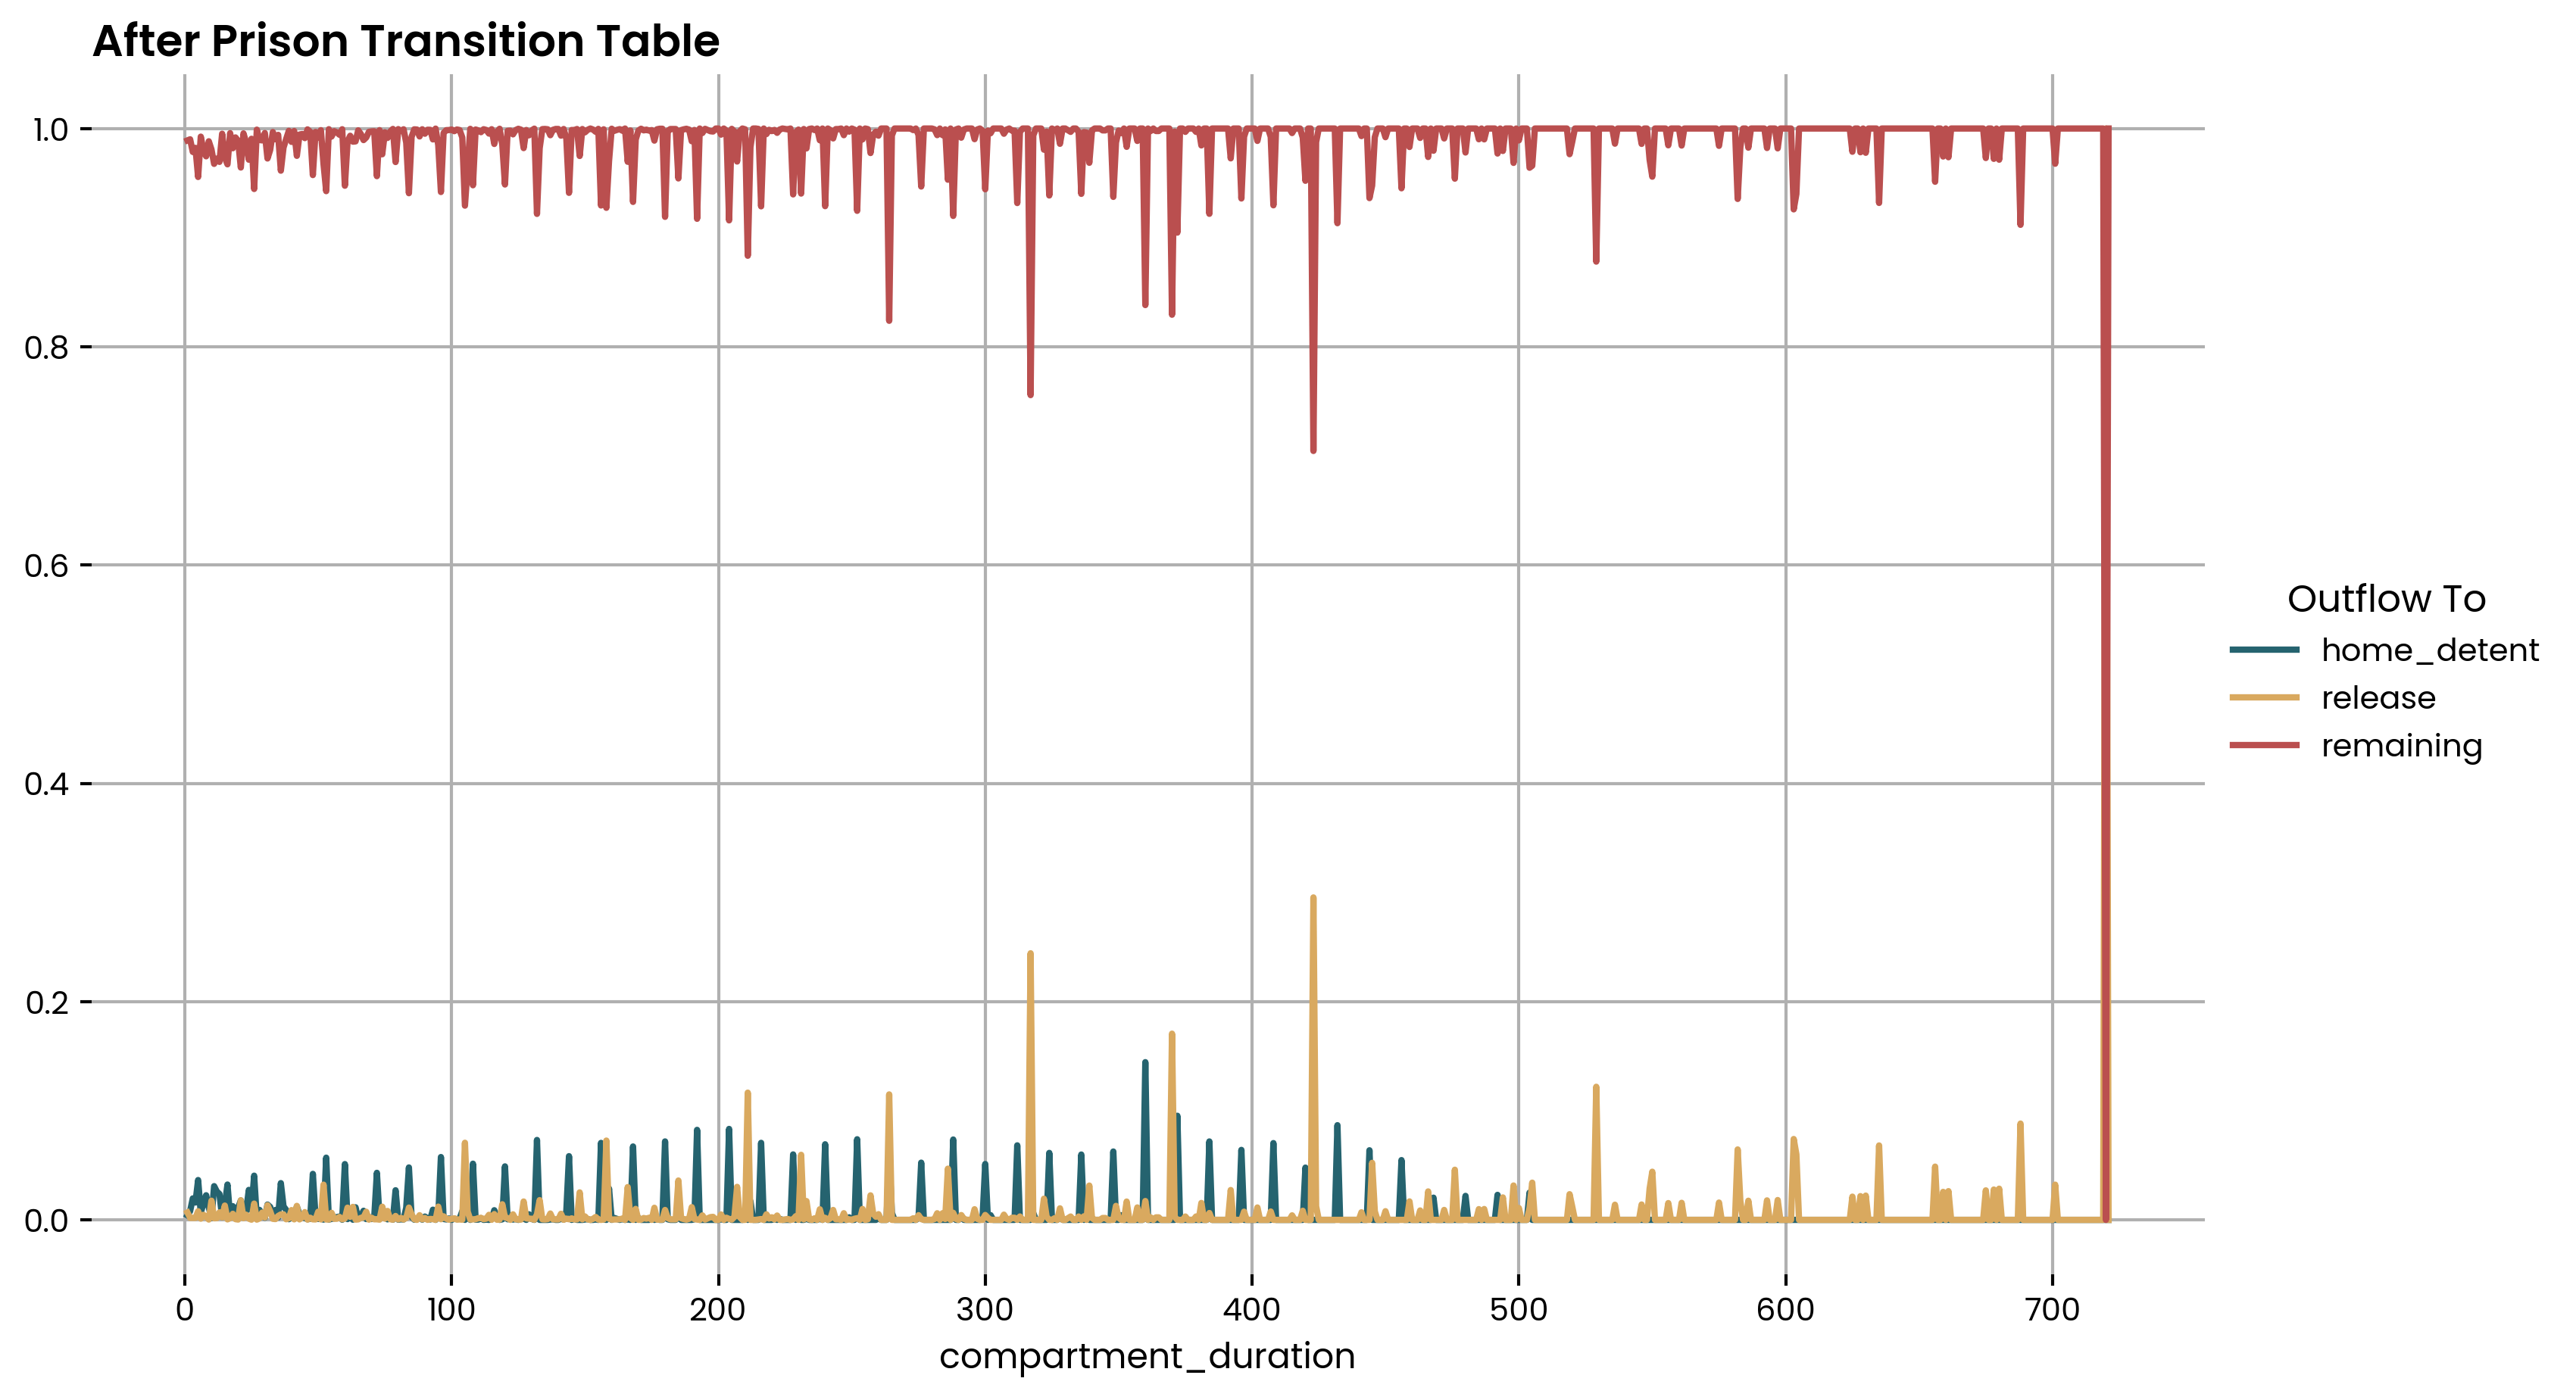

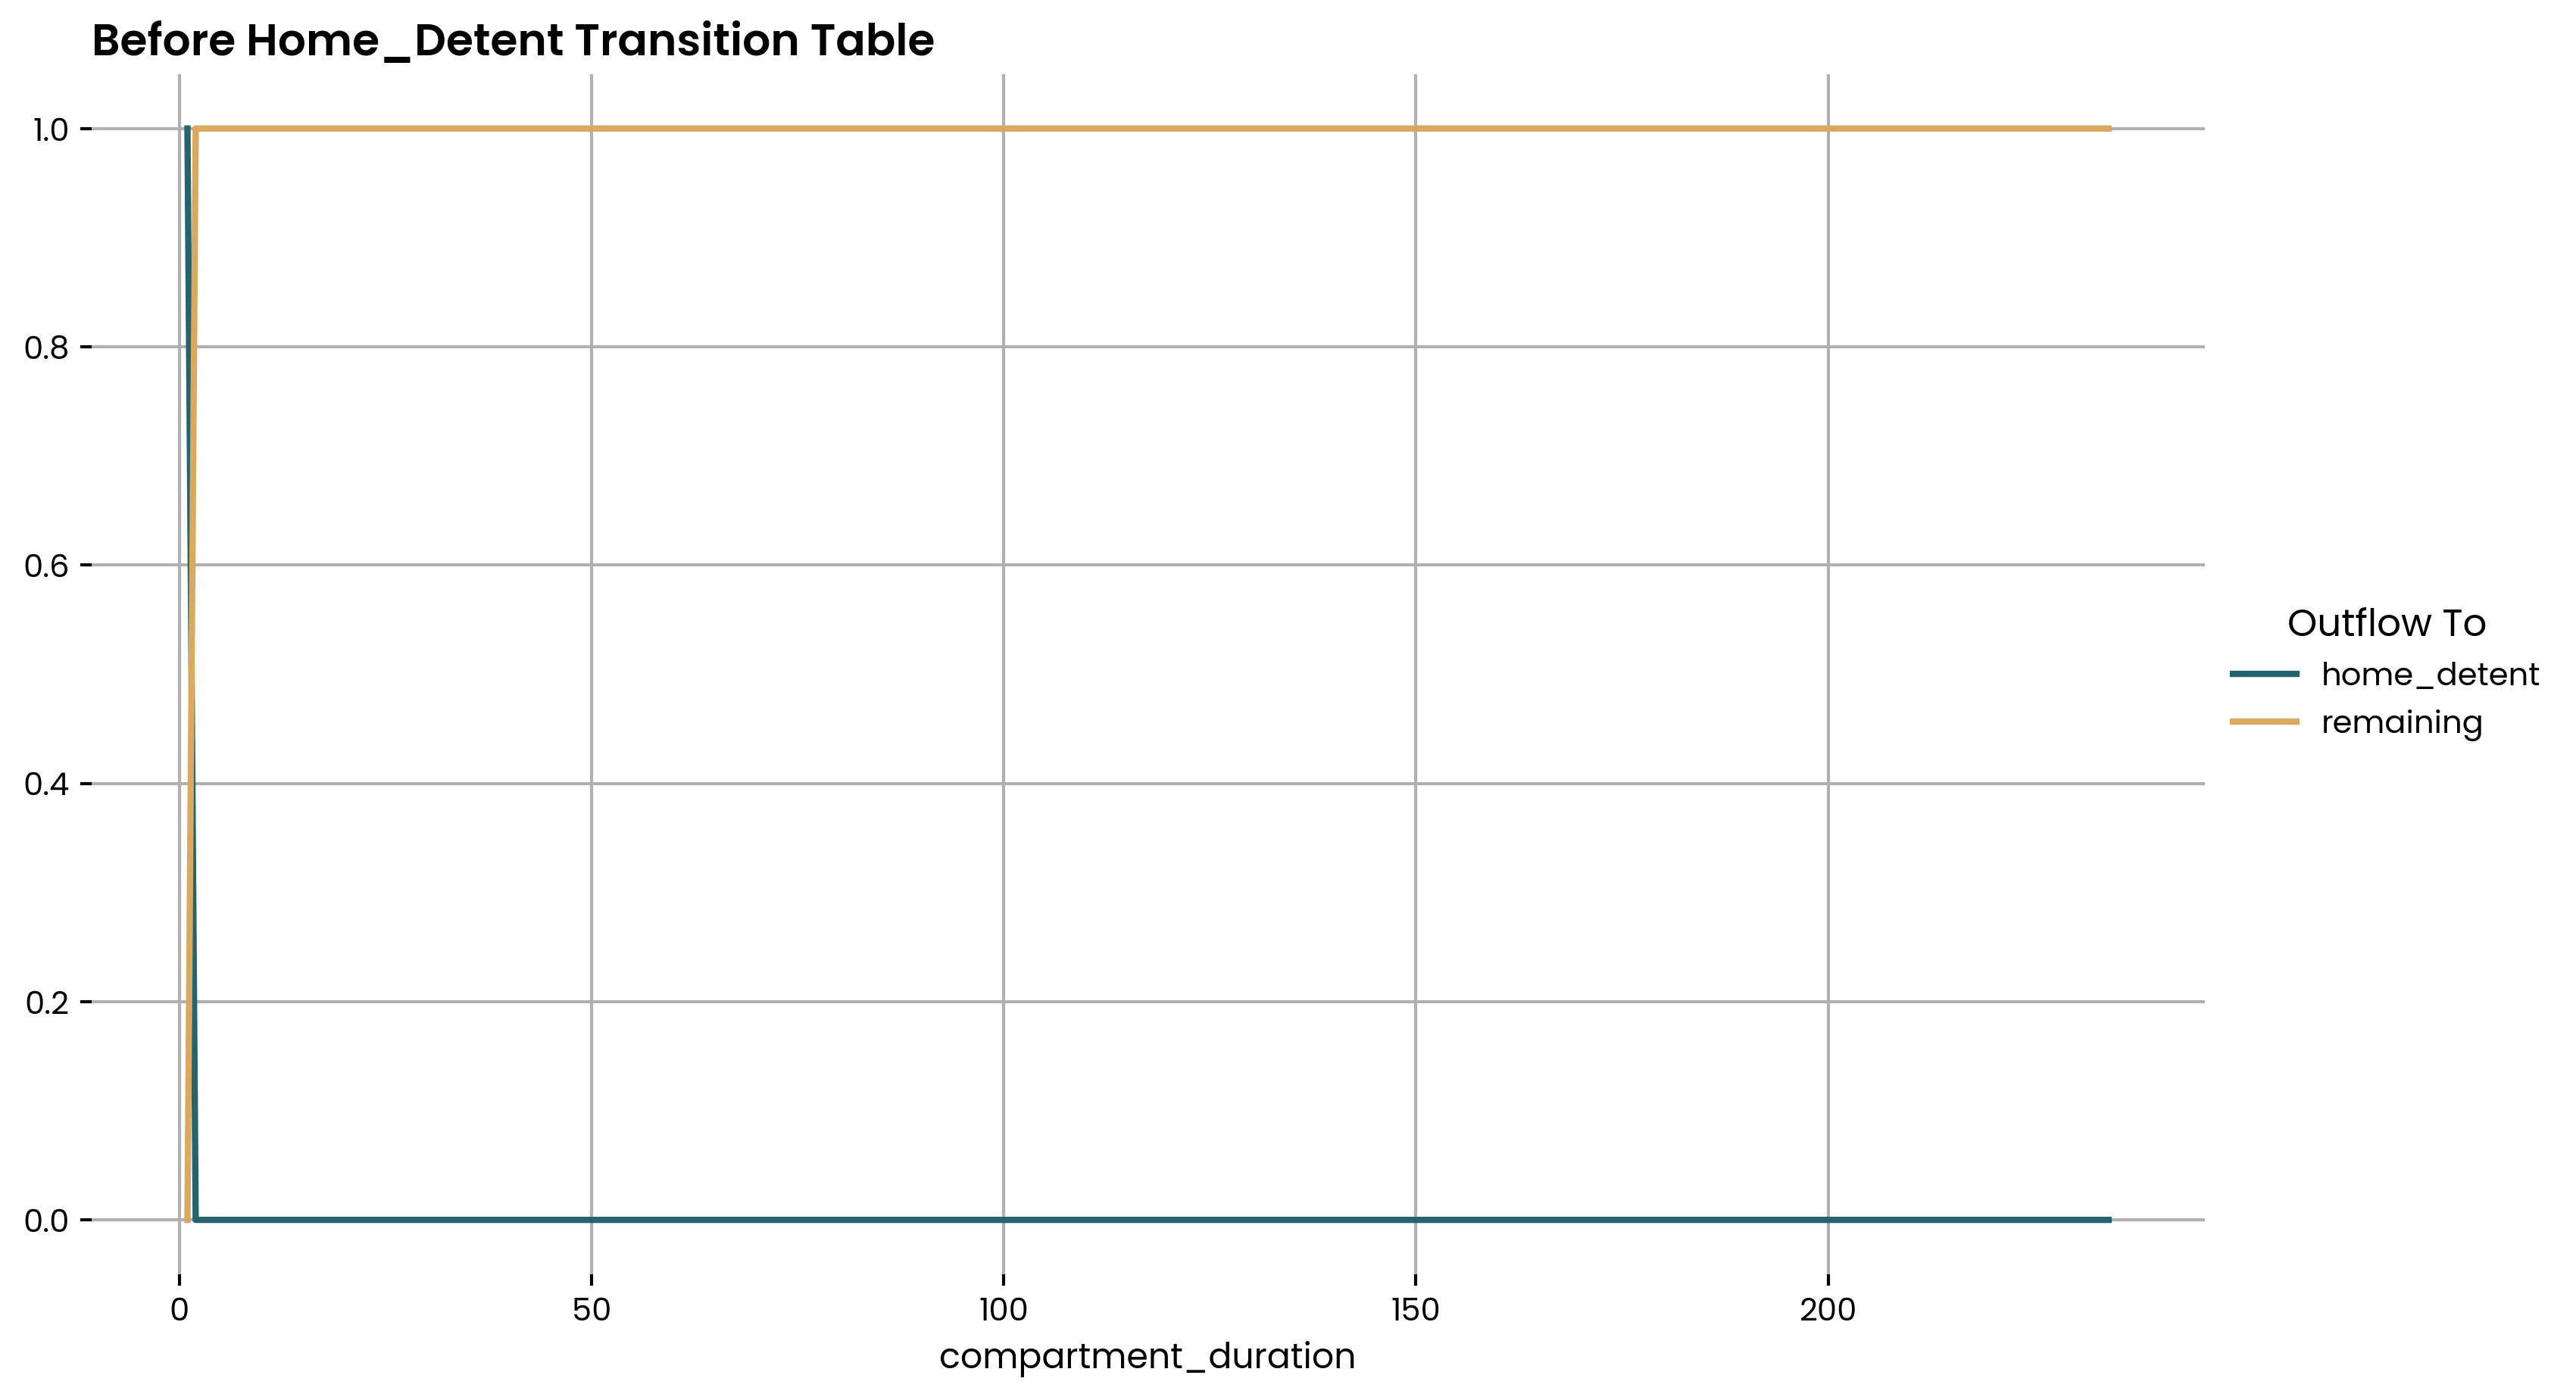

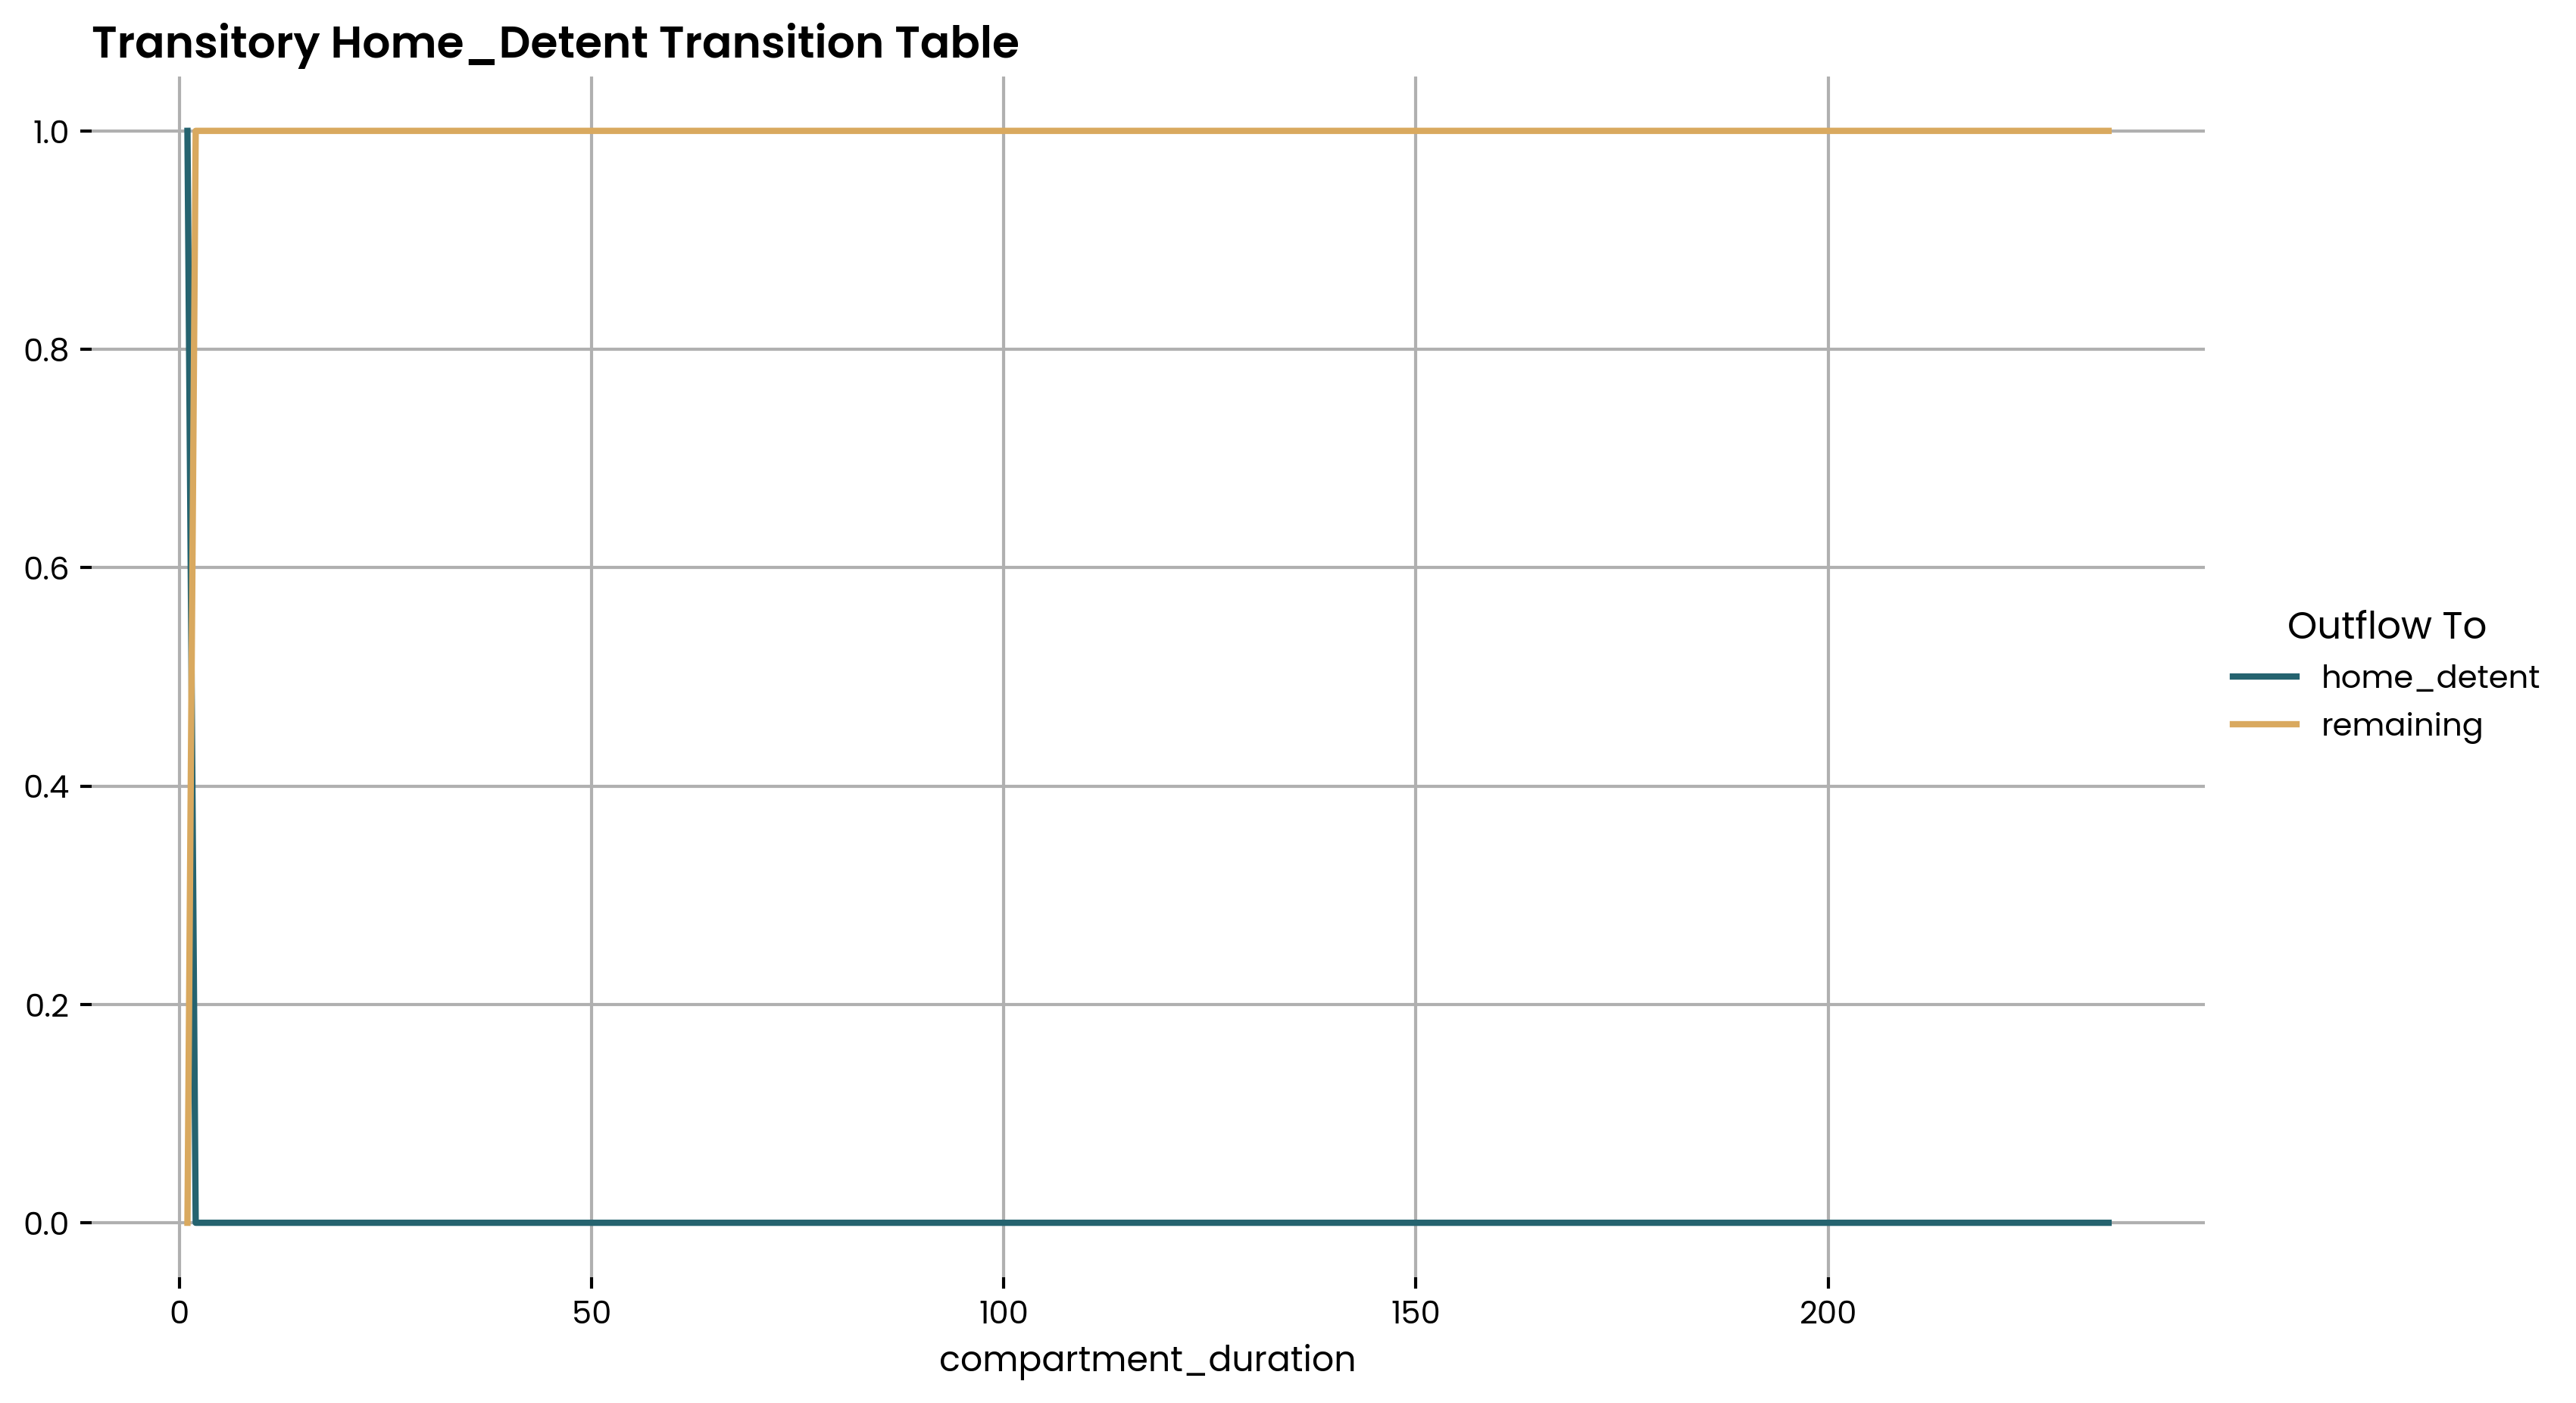

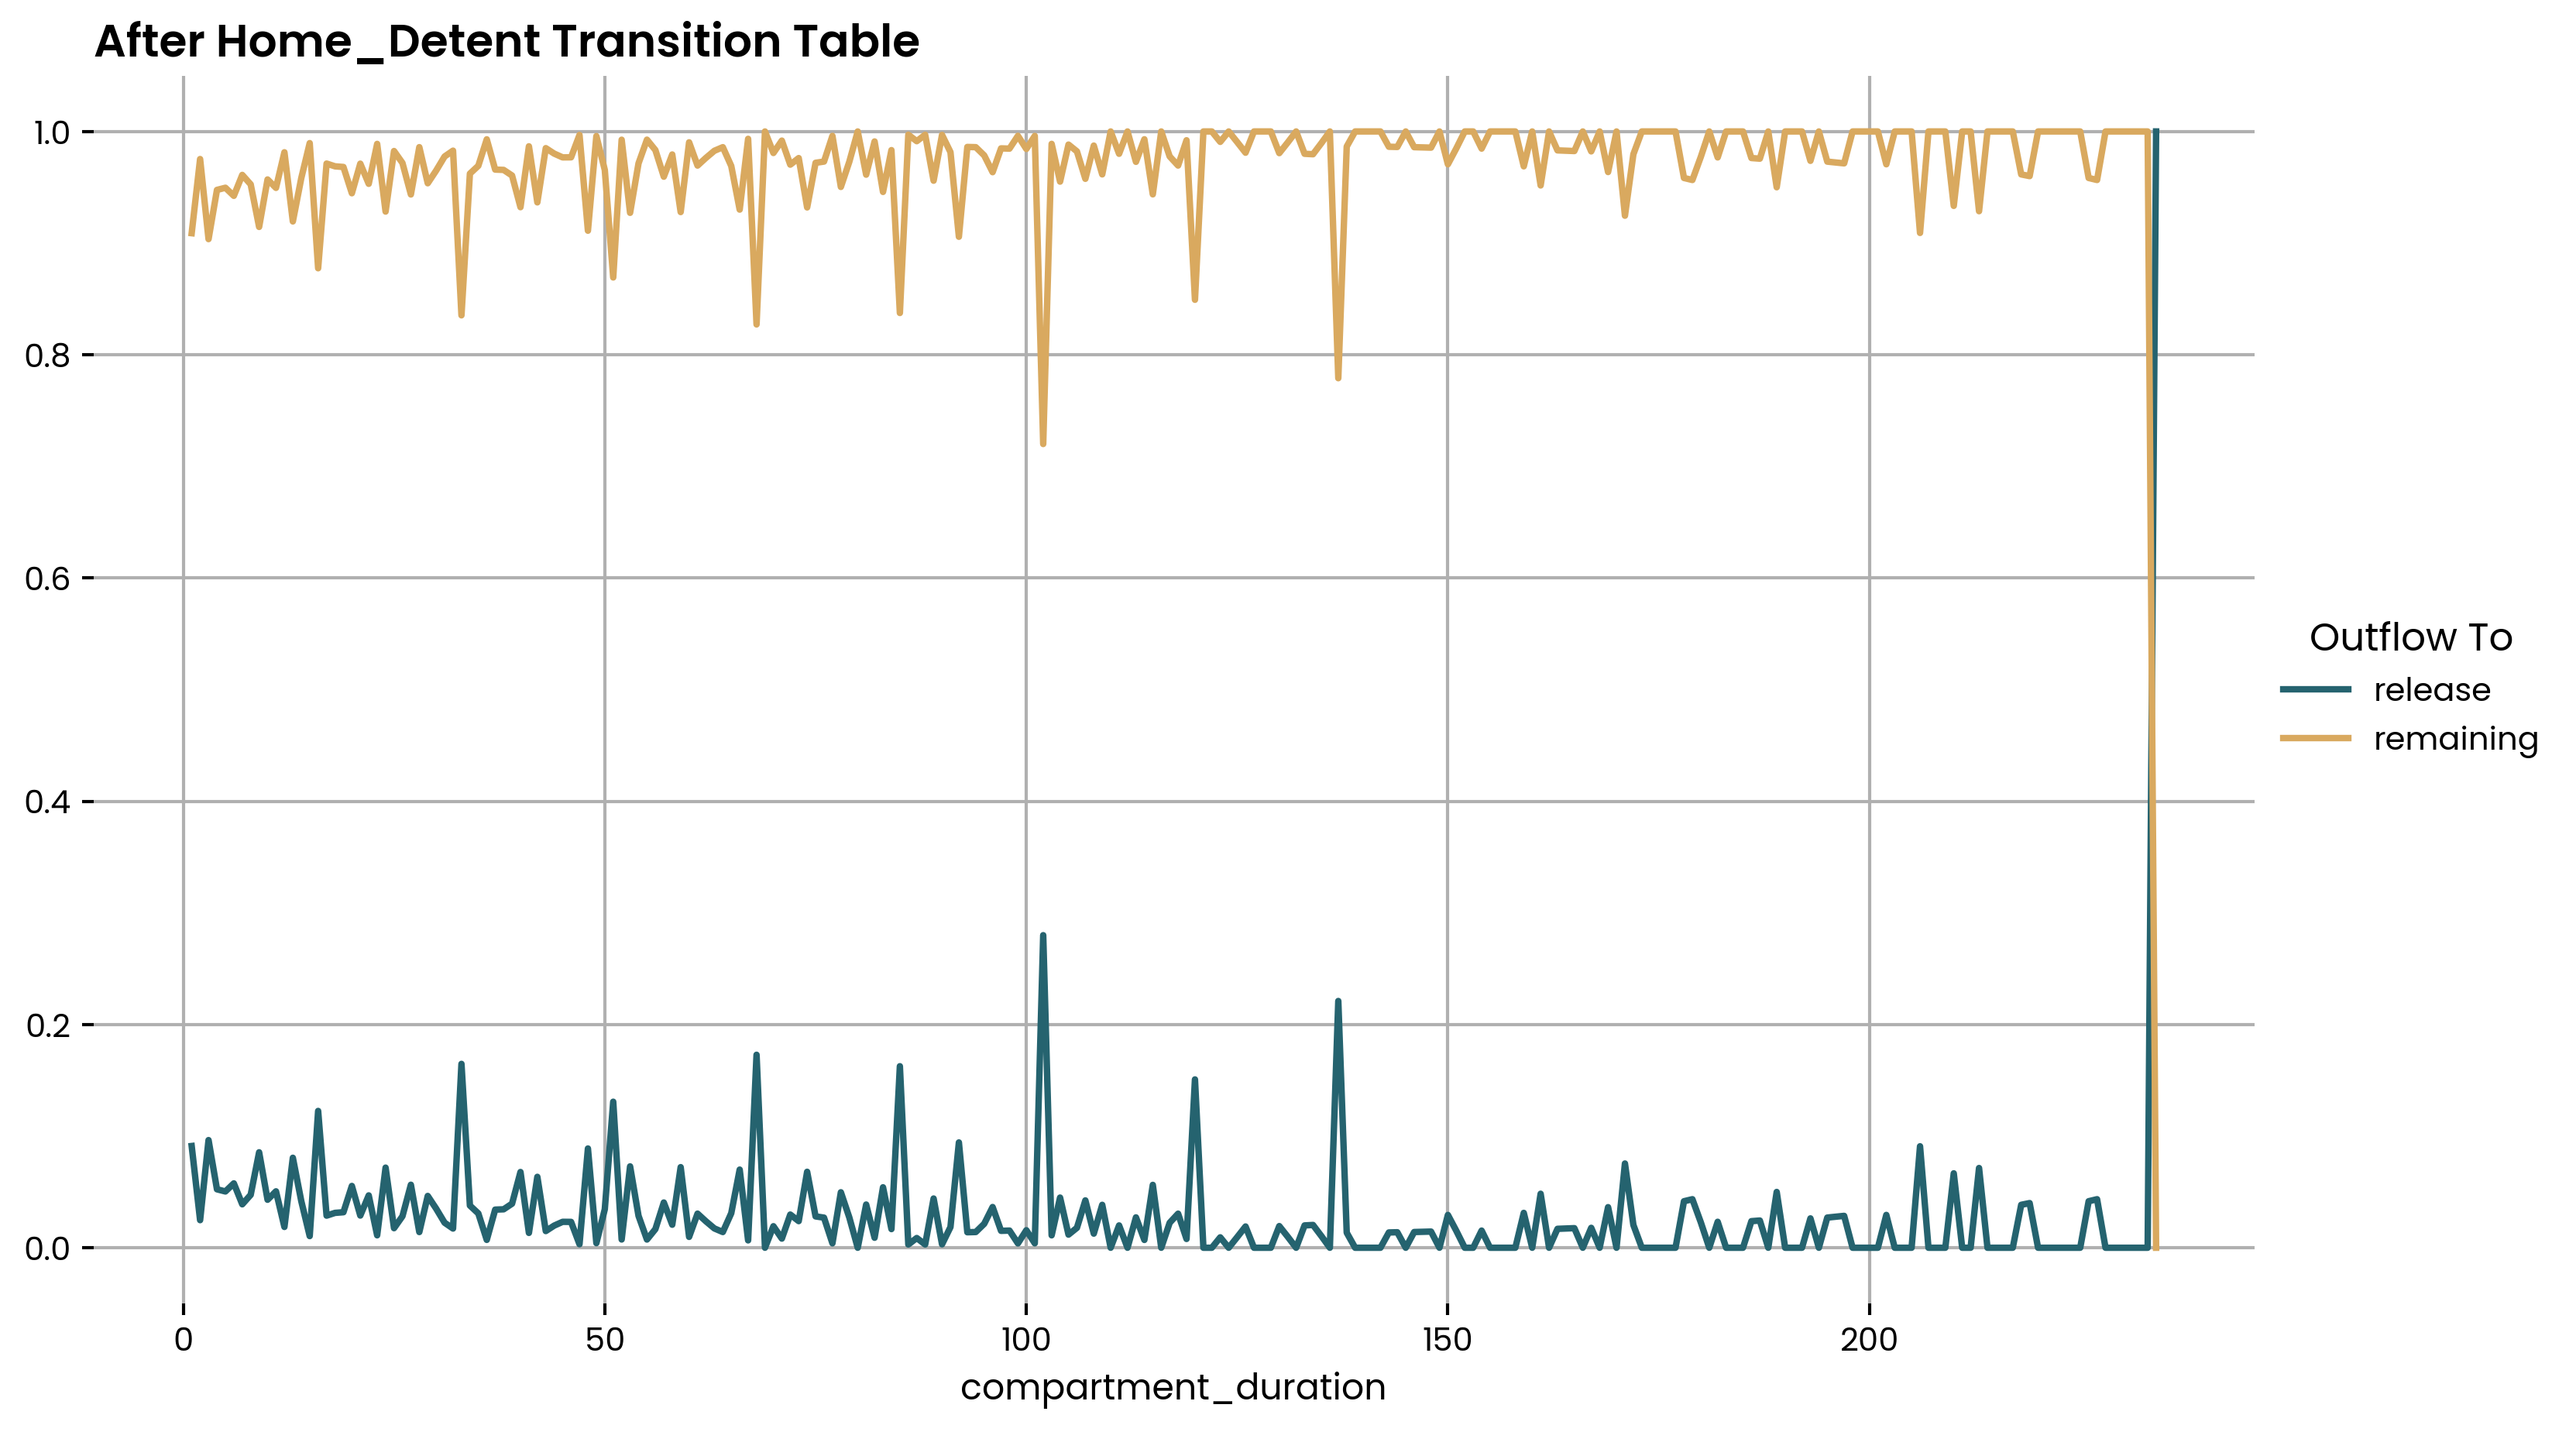

In [262]:
for compartment in ["prison", "home_detent"]:
    transition_dfs = (
        test_sim.validator.pop_simulations["policy"]
        .sub_simulations["x"]
        .simulation_compartments[compartment]
        .compartment_transitions.transition_tables
    )
    policy_key = max(transition_dfs.keys())
    for transition_type in [
        TransitionTableType.BEFORE,
        TransitionTableType.TRANSITORY,
        TransitionTableType.AFTER,
    ]:
        transition_dfs[policy_key].transition_dfs[transition_type].plot()
        plt.title(
            f"{transition_type.name.title()} {compartment.title()} Transition Table"
        )
        add_legend(title="Outflow To")

In [99]:
transition_dfs = (
    test_sim.validator.pop_simulations["policy"]
    .sub_simulations["x"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)
transition_dfs[-9999].transition_dfs[transition_type]["release"].sort_values(
    ascending=False
).head(10)

compartment_duration
720    1.000000
317    0.383360
423    0.356383
370    0.255172
211    0.217828
264    0.208466
105    0.159015
158    0.148481
529    0.121951
231    0.109632
Name: release, dtype: float64

In [136]:
transition_dfs = (
    test_sim.validator.pop_simulations["policy"]
    .sub_simulations["x"]
    .simulation_compartments["home_detent"]
    .compartment_transitions.transition_tables
)
transition_dfs[17].transition_dfs[transition_type]["release"].sort_values(
    ascending=False
).head(10)

compartment_duration
150    1.000000
149    0.714286
143    0.471698
132    0.437086
147    0.300000
105    0.254065
137    0.175000
52     0.168960
79     0.160667
144    0.142857
Name: release, dtype: float64

In [121]:
transition_dfs = (
    test_sim.validator.pop_simulations["policy"]
    .sub_simulations["x"]
    .simulation_compartments["home_detent"]
    .compartment_transitions.transition_tables
)
transition_dfs[17].transition_dfs[transition_type]["release"].sort_values(
    ascending=False
).head(10)

compartment_duration
220    1.000000
158    0.277108
211    0.210526
105    0.166223
132    0.160584
52     0.153686
185    0.142857
79     0.130808
26     0.095993
143    0.079872
Name: release, dtype: float64

In [105]:
transition_dfs[17].transition_dfs[transition_type].loc[200:215]

outflow_to             release  remaining
compartment_duration                     
200                   0.009709   0.990291
201                   0.009804   0.990196
202                   0.009901   0.990099
203                   0.000000   1.000000
204                   0.000000   1.000000
205                   0.020000   0.980000
206                   0.000000   1.000000
207                   0.020408   0.979592
208                   0.000000   1.000000
209                   0.010417   0.989583
210                   0.000000   1.000000
211                   0.210526   0.789474
212                   0.013333   0.986667
213                   0.013513   0.986486
214                   0.000000   1.000000
215                   0.000000   1.000000

In [102]:
transition_dfs = (
    test_sim.validator.pop_simulations["policy"]
    .sub_simulations["x"]
    .simulation_compartments["prison"]
    .compartment_transitions.transition_tables
)
transition_dfs[17].transition_dfs[transition_type]["release"].sort_values(
    ascending=False
).head(10)

compartment_duration
720    1.000000
423    0.322692
317    0.276856
370    0.170618
529    0.121951
211    0.116573
264    0.114950
158    0.090151
688    0.088235
603    0.074074
Name: release, dtype: float64

In [76]:
%%bigquery outflows_df
WITH latest_runs AS
(
SELECT simulation_tag, MAX(date_created) as latest_run
FROM `recidiviz-staging.spark_public_input_data.outflows_data_raw`
GROUP BY simulation_tag
)
SELECT data.*
FROM `recidiviz-staging.spark_public_input_data.outflows_data_raw` data
LEFT JOIN latest_runs ON data.simulation_tag = latest_runs.simulation_tag
WHERE data.simulation_tag = 'fed_s213'
    AND date_created = latest_runs.latest_run
ORDER BY time_step

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.98rows/s]


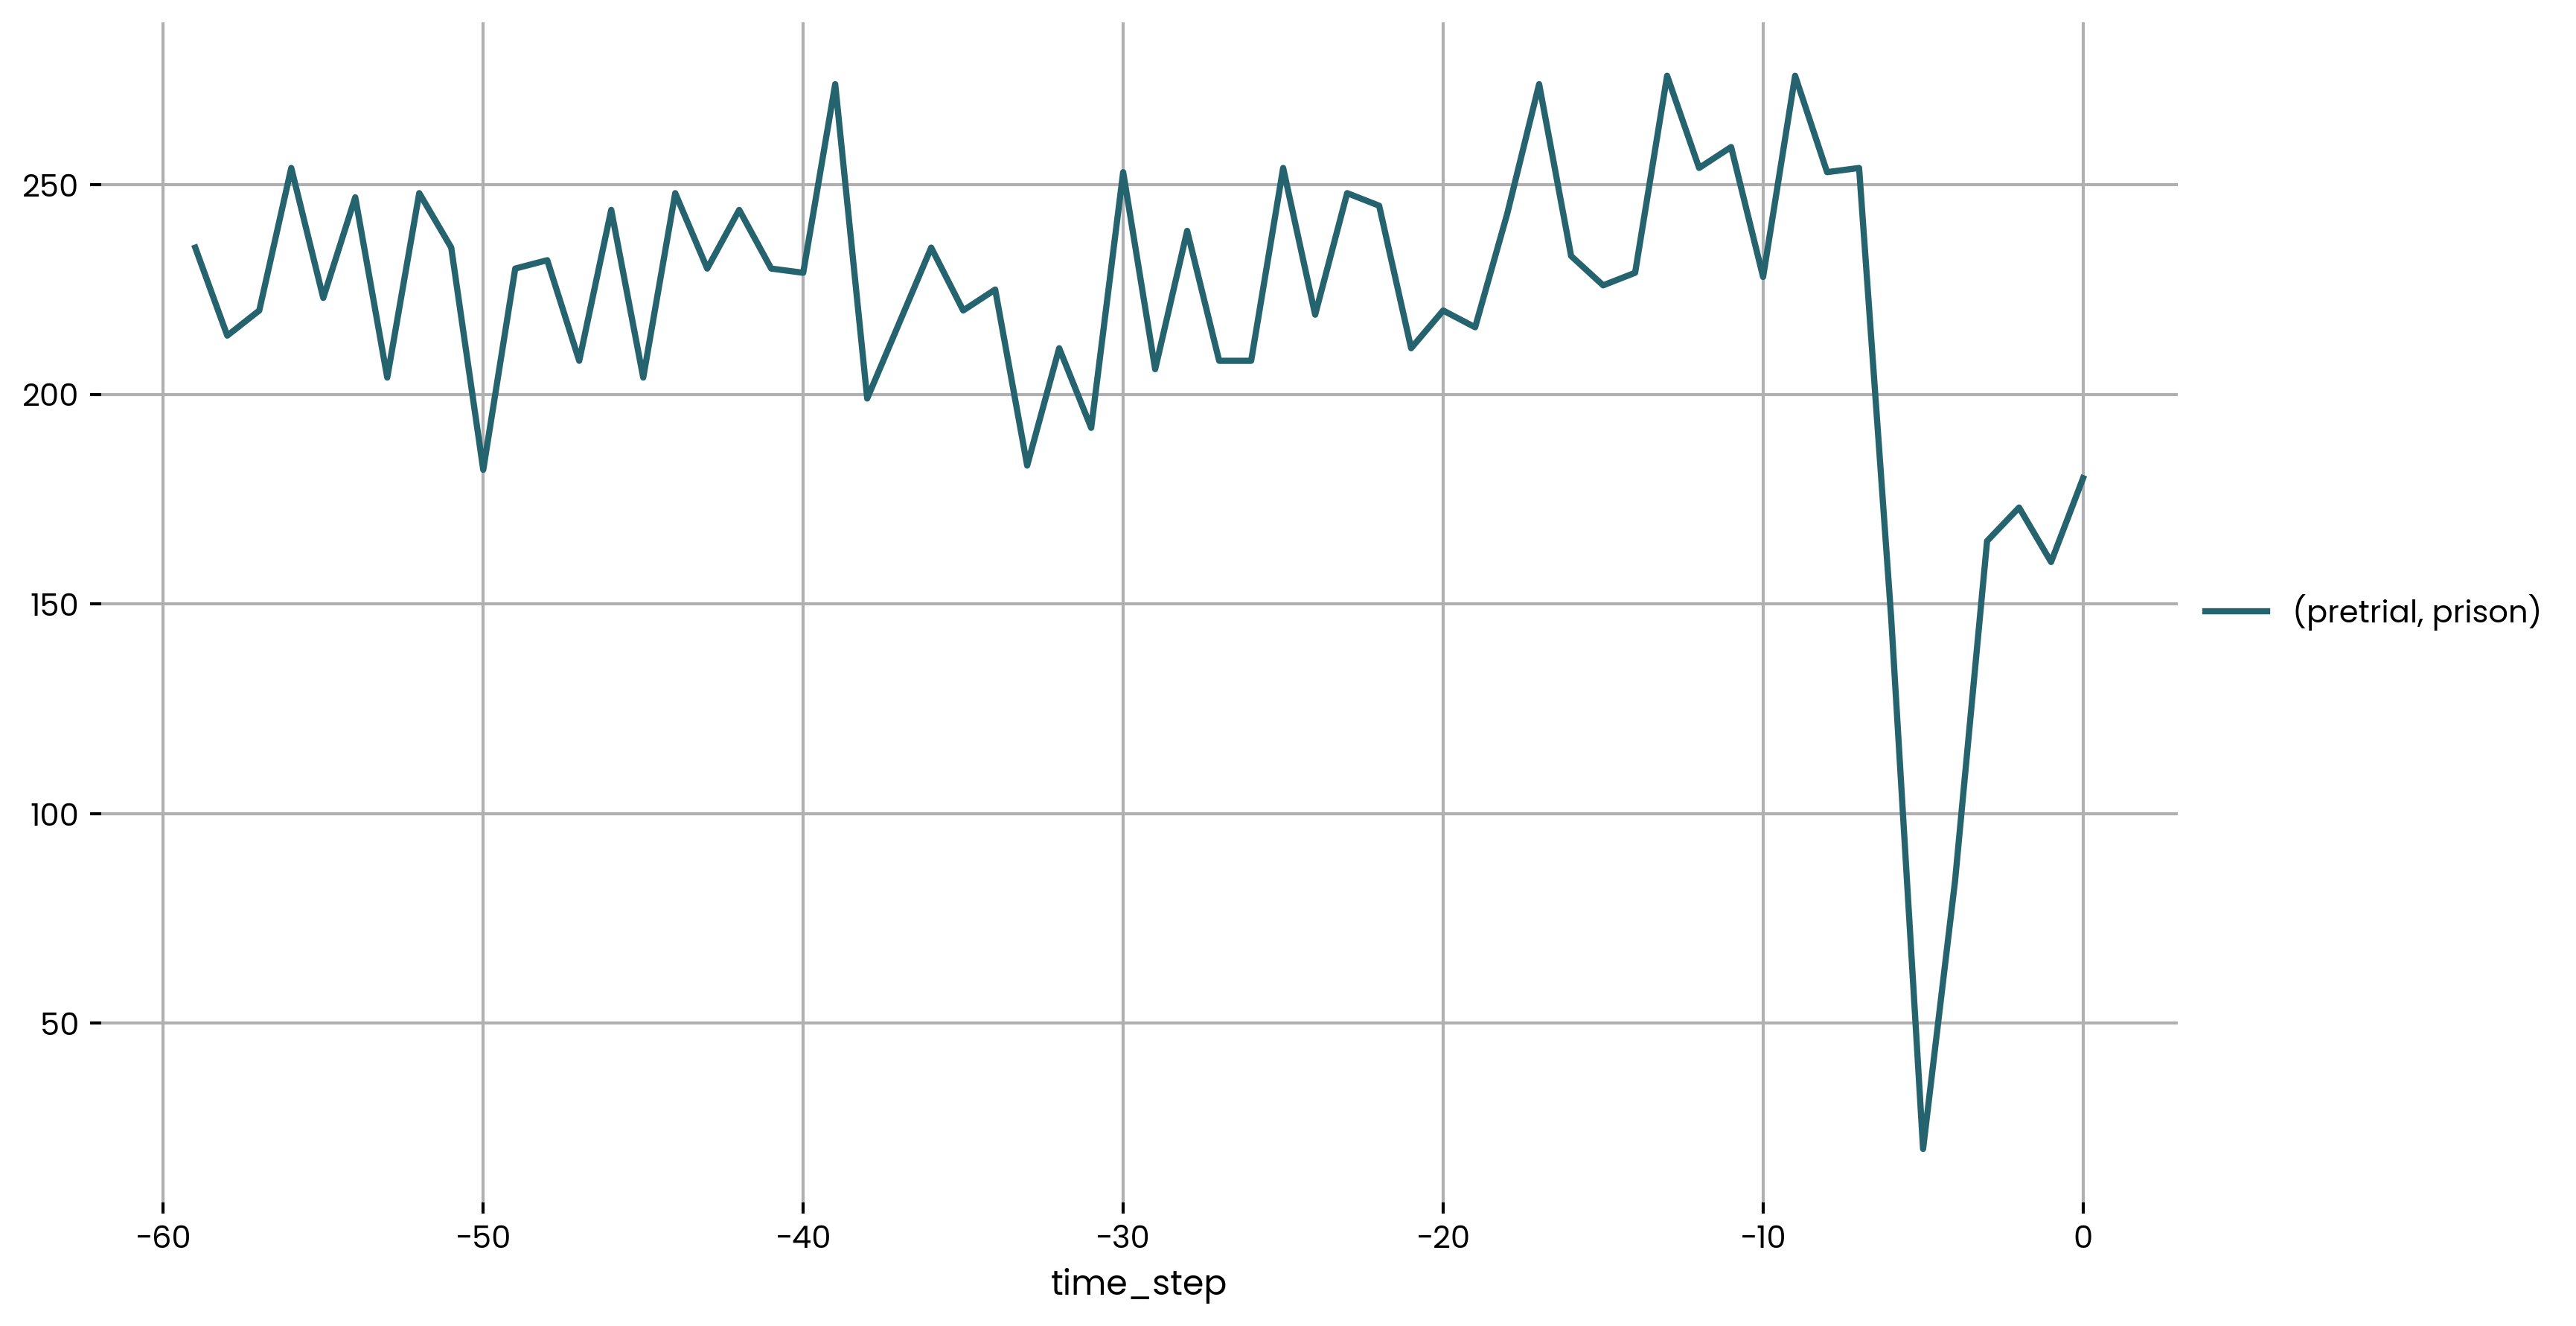

In [92]:
outflows_df.set_index(["time_step", "compartment", "outflow_to"]).unstack(
    ["compartment", "outflow_to"]
)["total_population"].plot()
add_legend()

In [125]:
raw_file_path = "../state/FED/sentencing_data/"
ussc20 = pd.read_spss(raw_file_path + "opafy20nid.sav")
ussc19 = pd.read_spss(raw_file_path + "opafy19nid.sav")
ussc18 = pd.read_spss(raw_file_path + "opafy18nid.sav")
ussc17 = pd.read_spss(raw_file_path + "opafy17nid.sav")
ussc16 = pd.read_spss(raw_file_path + "opafy16nid.sav")


ussc20 = ussc20[["TOTPRISN", "AGE", "VIOL1PTS", "OFFGUIDE", "SENTMON", "SENTYR"]]
ussc18 = ussc18[["TOTPRISN", "AGE", "VIOL1PTS", "OFFGUIDE", "SENTMON", "SENTYR"]]

ussc_recent = ussc20.append([ussc19, ussc18])
ussc_recent = ussc_recent[
    ~ussc_recent["OFFGUIDE"].isin([3, 4, 7, 19, 20, 22, 24, 26, 27])
]  # Offense codes corresponding to violent offenses (2018 and later)

ussc_older = ussc17.append(ussc16)
ussc_older = ussc_older[
    ~ussc_older["OFFTYPSB"].isin([1, 2, 3, 4, 5, 6, 9, 28])
]  # Offense codes corresponding to violent offenses (2017 and earlier)
ussc_older.rename(
    columns={"OFFTYPSB": "OFFGUIDE"}, inplace=True
)  # Standardize column name for primary offense type
ussc_data = ussc_recent.append(ussc_older)
ussc_data = ussc_data[
    (ussc_data["TOTPRISN"] > 0) & (ussc_data["TOTPRISN"] < 9992)
]  # Filter out offenders with no prison sentence, along with offenders with life sentences, death sentences, etc.

ussc_data.rename(
    columns={
        "TOTPRISN": "total_sentence_months",
        "AGE": "age",
        "VIOL1PTS": "violent_criminal_history_points",
        "OFFGUIDE": "offense_code",
        "SENTMON": "sentence_start_month",
        "SENTYR": "sentence_start_year",
    },
    inplace=True,
)
ussc_data.head()

total_sentence_months   age  violent_criminal_history_points  \
0                     6.0  23.0                              0.0   
6                    13.0  20.0                              0.0   
10                   24.0  33.0                              0.0   
11                   14.0  39.0                              0.0   
12                   37.0  46.0                              0.0   

    offense_code  sentence_start_month  sentence_start_year  
0           16.0                  10.0               2019.0  
6           10.0                  10.0               2019.0  
10          17.0                  10.0               2019.0  
11          17.0                  10.0               2019.0  
12          17.0                  10.0               2019.0

In [85]:
ussc_data["violent_criminal_history_points"].value_counts(dropna=False)

0.0    304842
NaN     22161
1.0      1227
2.0       304
3.0       259
6.0         1
8.0         1
Name: violent_criminal_history_points, dtype: int64

In [126]:
len(ussc_data)

221754

In [116]:
len(ussc_data)

229925

In [80]:
ussc_data.groupby(["TOTPRISN", "OFFGUIDE"]).count()["AGE"].unstack("OFFGUIDE").loc[0:10]

OFFGUIDE   1.0   2.0    5.0   6.0    7.0    8.0     9.0      10.0   11.0  \
TOTPRISN                                                                   
0.0       949.0  50.0  328.0  51.0  114.0  109.0  1347.0  10127.0  585.0   
1.0        12.0   3.0    3.0   NaN    1.0    NaN    22.0     55.0    2.0   
2.0         9.0   NaN    2.0   1.0    1.0    1.0    23.0     46.0    7.0   
3.0        20.0   1.0   12.0   NaN    NaN    3.0    27.0    127.0    9.0   
4.0        24.0   9.0   12.0   3.0    NaN    2.0     9.0    145.0    4.0   
5.0        24.0   NaN    6.0   NaN    1.0    4.0     7.0    160.0    7.0   
6.0        65.0   3.0   33.0   3.0   11.0    8.0   266.0    802.0   27.0   
7.0         8.0   NaN    1.0   1.0    1.0    NaN    24.0     93.0    3.0   
8.0        46.0   4.0    9.0   1.0    1.0    8.0     5.0    379.0    4.0   
9.0        15.0   1.0    7.0   1.0    1.0    1.0     3.0    138.0    2.0   
10.0       43.0   2.0    5.0   2.0    2.0    NaN     1.0    474.0    6.0   

OFFGUIDE    12.0  ...  26.0     27.0   28.0   29.0    30.0   31.0  32.0  33.0  \
TOTPRISN          ...                                                           
0.0       1448.0  ...  41.0  13466.0  314.0  755.0  3001.0  223.0  34.0  29.0   
1.0         84.0  ...   1.0   1644.0    NaN   34.0    36.0    3.0   NaN   NaN   
2.0        165.0  ...   NaN    498.0    3.0   26.0    28.0    1.0   NaN   1.0   
3.0         96.0  ...   1.0    434.0    4.0   55.0    24.0    3.0   NaN   NaN   
4.0         40.0  ...   NaN    733.0    3.0   84.0    19.0    2.0   NaN   NaN   
5.0         31.0  ...   1.0    450.0    2.0   35.0    27.0    NaN   NaN   3.0   
6.0       1301.0  ...   3.0   1767.0   19.0  151.0   121.0    7.0   5.0   2.0   
7.0        102.0  ...   NaN    763.0    3.0   18.0    28.0    NaN   NaN   1.0   
8.0         38.0  ...   NaN   1747.0    7.0   81.0    54.0    1.0   NaN   3.0   
9.0         20.0  ...   2.0    584.0    4.0   34.0    27.0    1.0   2.0   NaN   
10.0         8.0  ...   NaN   1633.0    9.0   31.0    45.0    1.0   5.0   2.0   

OFFGUIDE   34.0    35.0  
TOTPRISN                 
0.0       145.0  2553.0  
1.0         1.0    36.0  
2.0         NaN    15.0  
3.0         5.0    29.0  
4.0         1.0    23.0  
5.0         1.0    20.0  
6.0         3.0    73.0  
7.0         NaN    10.0  
8.0         1.0    15.0  
9.0         1.0    17.0  
10.0        3.0    19.0  

[11 rows x 33 columns]

<AxesSubplot:xlabel='TOTPRISN'>

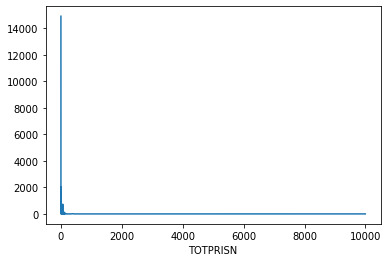

In [83]:
ussc_data[ussc_data["VIOL1PTS"].isnull()].groupby("TOTPRISN").count()["AGE"].plot()

In [128]:
ussc_data["total_sentence_months"].describe()

count    221754.000000
mean         51.371466
std          58.999526
min           1.000000
25%          14.000000
50%          30.000000
75%          65.000000
max        4116.000000
Name: total_sentence_months, dtype: float64

In [120]:
6960 / 12

580.0

In [131]:
ussc_data[ussc_data["total_sentence_months"] > 100 * 12]

total_sentence_months   age  violent_criminal_history_points  \
5411                  1740.0  36.0                              0.0   
34975                 1390.0  35.0                              0.0   
40503                 1662.0  28.0                              0.0   
42863                 1380.0  33.0                              0.0   
44921                 1590.0  45.0                              0.0   
9720                  1846.0  33.0                              0.0   
9861                  1435.0  23.0                              0.0   
16156                 1452.0  48.0                              0.0   
21745                 1384.0  24.0                              0.0   
22084                 1384.0  33.0                              0.0   
37488                 1320.0  30.0                              0.0   
49513                 4116.0  27.0                              0.0   
53796                 1354.0  29.0                              0.0   
58361                 1452.0  37.0                              0.0   

       offense_code  sentence_start_month  sentence_start_year  
5411           10.0                  10.0               2018.0  
34975          13.0                   4.0               2017.0  
40503          13.0                   5.0               2017.0  
42863          18.0                   5.0               2017.0  
44921          13.0                   5.0               2017.0  
9720           13.0                  11.0               2015.0  
9861           13.0                  11.0               2015.0  
16156          13.0                   1.0               2016.0  
21745          13.0                   2.0               2016.0  
22084          13.0                   2.0               2016.0  
37488          13.0                   4.0               2016.0  
49513          13.0                   6.0               2016.0  
53796          13.0                   7.0               2016.0  
58361          13.0                   8.0               2016.0

In [124]:
ussc_data[ussc_data["age"] >= 60]["offense_code"].value_counts(dropna=False)

10.0    1949
16.0    1121
18.0     906
17.0     662
27.0     428
13.0     426
7.0      412
28.0     373
21.0     249
29.0     232
22.0     137
23.0     118
5.0      111
30.0     101
24.0      98
1.0       58
35.0      54
12.0      40
25.0      26
11.0      25
19.0      24
8.0       15
20.0      12
32.0      12
31.0      10
33.0       9
15.0       8
9.0        6
2.0        6
34.0       5
14.0       3
6.0        1
26.0       1
Name: offense_code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

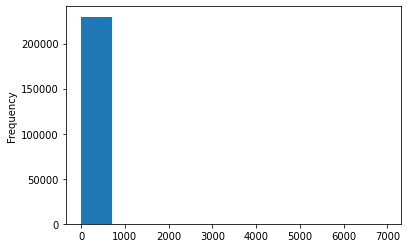

In [118]:
ussc_data["total_sentence_months"].plot.hist()